<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder.



In [ ]:
ls

logs/  models/  orderparams.ipynb  OrderPresentation.gslides


Install non-default packages here.

In [3]:
!pip install bumps
!pip install gym
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

     |████████████████████████████████| 522kB 2.8MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=7aac877ecf04c316ff1006e4dfa47f62b4a0fdf74098bcfe26a9e87e894f400e
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps
TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 2.8MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


"Compile" important methods.

In [4]:
class OrderMethods():

  def bsol(temp,p):
    Tn,Jt,Nf,Bk=p
    t=4.0*(Jt/(Jt+1.0))*Tn/temp
    if (Tn<=0) or (Jt<=0) or temp>=Tn:
      xout=0.0
    else:
      xout=optimize.brentq(OrderMethods.bfun,0.0,t,args=(temp,p),xtol=1e-6)

    return xout


  def bfun(x,T,p):
    Tn,Jt,Nf,Bk=p
    if x==0.0:
      B=-1.0 # so that it wont find solution at zero
    else:
      B=(x-3*OrderMethods.brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
    return B

  def brill(j,x):
    temp=(2*j+1.0)/2/j
    if x==0:
      Br=0.0
    else:
      Br=temp/np.tanh(temp*x)-1.0/np.tanh(x/2/j)/2/j
    return Br

  def Intensity(T,p):
    Tn,Jt,Nf,Bk=p
    br=OrderMethods.brill(Jt,OrderMethods.bsol(T,p))
    bout=Bk+Nf*br**2
    return bout

  def orderparameter(T, Tn, Jt, Nf, Bk):
    p=[Tn, Jt, Nf, Bk]
    I=[]
    for t in T:
      I.append(OrderMethods.Intensity(t,p))
    return np.array(I)

  def fit(model):
    # nllfs = []
    # zin = []
    # for tns in np.arange(50,200, 5):
      # #print("zs", zs)
      # model.Tn.value = tns
      # model.update()
      # schi=model.nllf()
      # nllfs.append(schi)
      # zin.append(tns)
    # plt.scatter(zin, nllfs)
    # plt.xlabel("tn in")
    # plt.ylabel("chi") 
    # plt.show()
    # plt.close()

    # model.Tn.value = 200
    model.update()

    problem = FitProblem(model)
    result = fitters.fit(problem, method='lm')
    for p, v in zip(problem._parameters, result.dx):
      p.dx = v
    return result.x, result.dx, problem.chisq(), problem._parameters
        

Execute main class.

In [27]:
import sys
import numpy as np
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces
import gym
import random 

class OrderEnv(gym.Env):

  def __init__(self):
    self.reward_scale = 100
    self.episodeNum = 0
    self.steps = 0
    self.T = np.array([])
    #self.Bk = .3
    self.error = []

    self.fixedTn = 160
    self.fixedNf = 330
    self.fixedJt = .885
    self.fixedBk = .3

    # self.observation_space = spaces.Box(low = np.array([3]), high = np.array([340]))
    # self.action_space = spaces.Box(low = np.array([3]), high = np.array([340]))
    self.action_space = spaces.Discrete(7)
    self.action_options = [1, 5, 10, 15, 20, 25, 30]
    self.curTemp = 3
    self.x = 150 #startTn value

    #logging arrays and vars
    self.rewards = [] #interepisodic
    self.chisqds = []
    self.convergsTn = []
    self.convergsNf = []
    self.convergsJt = []
    self.convergsBk = []
    self.transTemps = []
    self.Jts = []
    self.Nfs = []
    self.Bks = []
    self.totReward = 0 
    self.info = {}   
  

  def step(self, action): 
      
    print("stepping: ", self.episodeNum)
    print("ACTION            : ", action)

    self.curTemp += self.action_options[action]
    #self.curTemp = action
    self.curTemp = self.round_to(self.curTemp, 0.5)
    print("curtemp: ", self.curTemp)

    self.steps += 1
    reward = -self.reward_scale
    self.T = np.append(self.T, self.curTemp)
    print("Temperature: ", self.T)
    
    if self.steps > 4:
      self.I = self.getData(self.T)
      #self.I = OrderMethods.getData(self.T, self.Bk)
      print("Intensity: ", self.I)
      self.error= np.sqrt(self.I)
      M = Curve(OrderMethods.orderparameter, self.T, self.I, self.error, Tn = self.fixedTn, Jt = self.fixedJt, Nf = self.fixedNf, Bk = self.fixedBk)
      M.Tn.range(self.fixedTn-20, self.fixedTn+20)
      M.Jt.range(0.4, 2)
      M.Nf.range(100,500)
      M.Bk.range(.1, 8)
      # self.Jt = self.fixedJt #DELETE ME LATERRRRRRRRRR
      # self.Nf = self.fixedNf

      self.x, dx, chisq, params = OrderMethods.fit(M)
      self.Nf = self.x[2]
      self.Jt = self.x[1]
      self.Bk = self.x[0] #untested
      self.x = self.x[3]
      # self.x = self.x[0]
      print("ORDER PARAM RESULT (X2):", self.x)
      print("THE JT RESULT {X0}:", self.Jt)
      print("THE NF RESULT {X1}:", self.Nf)
      print("THE BK RESULT {X3}:", self.Bk)

      dx = params[0].dx

      print("chisqds: ", chisq)
      print("BUT ARE WE SURE?:", dx)

      plt.plot(self.T, self.I, 'ro')
      plt.show()
      plt.close()

      # if(action > 0.5):
      #   reward += 1000

      if chisq < 300 and chisq >= 1:
        reward += 400*(1/chisq)
      elif chisq < 1:
        reward += 400

      self.chisqds.append(chisq)
      self.transTemps.append(self.x)
      self.Jts.append(self.Jt)
      self.Nfs.append(self.Nf)
      self.Bks.append(self.Bk)

      if not self.goodTn :
        if abs(self.x - self.fixedTn) < 0.1 :
          self.convergsTn.append(self.steps)
          self.goodTn = True
      if not self.goodNf : 
        if abs (self.Nf - self.fixedNf) < 0.1:
          self.convergsNf.append(self.steps)
          self.goodNf = True 
      if not self.goodJt : 
        if abs(self.Jt - self.fixedJt) < 0.1: 
          self.convergsJt.append(self.steps)
          self.goodNf = True 
      if not self.goodBk : 
        if abs(self.Bk - self.fixedBk) < 0.1: 
          self.convergsBk.append(self.steps)
          self.goodBk = True 

    print("highHIIIIGHHHHHH: ", (340-self.curTemp))
    print("rewaRD:: ", reward)

    self.totReward += reward
    self.state = np.array([self.curTemp])

    if (self.steps > 4 and chisq < 0.05 and dx < 10000000): #less than or equal to?
      print("terminated: excellent conditions")
      terminal = True
      self.log()
    elif (self.curTemp >= 340):
      print("terminated: over max temp")
      terminal = True
      self.log()
    elif (self.steps > 100):
      print("terminated: too long")
      terminal = True
      self.log()
    else:
      terminal = False

    if terminal:
      if not self.goodTn :
        self.convergsTn.append(self.steps)
      if not self.goodNf : 
        self.convergsNf.append(self.steps)
      if not self.goodJt : 
        self.convergsJt.append(self.steps)
      if not self.goodBk : 
        self.convergsBk.append(self.steps)
    
    print("returned state:", self.state)
    o = self.observation_space 
    print("observation space: ", o.shape)
    return self.state, reward, terminal, self.info


  def reset(self):
    print("reset")
    self.steps = 0
    self.T = np.array([])
    self.I = []
    self.chisqds = []
    self.transTemps = []
    self.Jts = []
    self.Nfs = []
    self.totReward = 0
    self.curTemp = 3
    self.state = np.array([self.curTemp])
    self.goodTn = False 
    self.goodNf = False 
    self.goodJt = False 
    self.goodBk = False 

    #basic multiple param set training
    # if (self.steps % 3 == 0):
    #   self.setVars(130, 1.2, 150)
    # elif (self.steps % 3 == 1):
    #   self.setVars(180, .9, 270)
    # else:
    #   self.setVars(160, .885, 330)

    self.setVars(random.randrange(40, 300, 10), .885, 330, .3)

    return self.state #starting state

  def log(self):
    self.episodeNum += 1

    filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.chisqds)

    filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.transTemps)

    filename = "logs/jt/jtLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Jts)

    filename = "logs/nf/nfLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Nfs)

    filename = "logs/bk/bkLog-" + str(self.episodeNum) + ".npy"
    np.savetxt(filename, self.Bks)

    filename = "logs/convergsTn.npy"
    np.savetxt(filename, self.convergsTn)

    filename = "logs/convergsNf.npy"
    np.savetxt(filename, self.convergsNf)
    
    filename = "logs/convergsJt.npy"
    np.savetxt(filename, self.convergsJt)

    filename = "logs/convergsBk.npy"
    np.savetxt(filename, self.convergsBk)

    self.rewards.append(self.totReward)
    filename = "logs/runrewards.npy"
    np.savetxt(filename, self.rewards)

  # @property
  # def action_space(self):
  #     return spaces.Box(low = np.array([0.5]), high = np.array([340 - self.curTemp]))
  #     # return spaces.Box(low = np.array([self.curTemp + 0.5]), high = np.array([340]))

  @property 
  def observation_space(self):
    return spaces.Box(low=3.0, high=340.0, shape=(self.steps + 1,), dtype=np.float32)

  def round_to(self, n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

  def getData(self, T):
    return OrderMethods.orderparameter(T, self.fixedTn, self.fixedJt, self.fixedNf, self.fixedBk)

  def setVars(self, Tn, Jt, Nf, Bk):
    self.fixedTn = Tn
    print("fixed Tn: ", self.fixedTn)
    self.fixedJt = Jt
    print("fixed Jt: ", self.fixedJt)
    self.fixedNf = Nf
    print("fixed Nf: ", self.fixedNf)
    self.fixedBk = Bk
    print("fixed Bk: ", self.fixedBk)

  def getVars(self):
    return self.x, self.Jt, self.Nf, self.Bk

reset
fixed Tn:  50
fixed Jt:  0.885
fixed Nf:  330
fixed Bk:  0.3
stepping:  0
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  0
ACTION            :  3
curtemp:  38.0
Temperature:  [23. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (3,)
stepping:  0
ACTION            :  0
curtemp:  39.0
Temperature:  [23. 38. 39.]
highHIIIIGHHHHHH:  301.0
rewaRD::  -100
returned state: [39.]
observation space:  (4,)
stepping:  0
ACTION            :  3
curtemp:  54.0
Temperature:  [23. 38. 39. 54.]
highHIIIIGHHHHHH:  286.0
rewaRD::  -100
returned state: [54.]
observation space:  (5,)
stepping:  0
ACTION            :  5
curtemp:  79.0
Temperature:  [23. 38. 39. 54. 79.]
Intensity:  [3.02936508e+02 1.79682732e+02 1.67531282e+02 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.885
THE NF RESULT {X1}: 330.0
THE BK RESULT {X3}

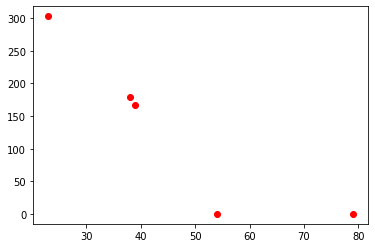

highHIIIIGHHHHHH:  261.0
rewaRD::  300
terminated: excellent conditions


KeyboardInterrupt: ignored

In [28]:
from stable_baselines.common.env_checker import check_env
env = OrderEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = OrderEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1) #retrieve?

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Train a new model.





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



reset
fixed Tn:  70
fixed Jt:  0.9
fixed Nf:  330
stepping:  0
ACTION            :  5
curtemp:  28.0
Temperature:  [28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
returned state: [28.]
observation space:  (2,)
stepping:  0
ACTION            :  6
curtemp:  58.0
Temperature:  [28. 58.]
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
returned state: [58.]
observation space:  (3,)
stepping:  0
ACTION            :  4
curtemp:  78.0
Temperature:  [28. 58. 78.]
highHIIIIGHHHHHH:  262.0
rewaRD::  -100
returned state: [78.]
observation space:  (4,)
stepping:  0
ACTION            :  2
curtemp:  88.0
Temperature:  [28. 58. 78. 88.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036

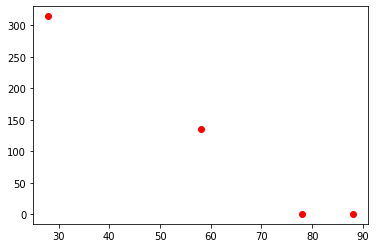

highHIIIIGHHHHHH:  252.0
rewaRD::  -97.07246166145674
returned state: [88.]
observation space:  (5,)
stepping:  0
ACTION            :  0
curtemp:  89.0
Temperature:  [28. 58. 78. 88. 89.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 274.4863758808335
chisqds:  76.20792195991557
BUT ARE WE SURE?: 1.2962628998671505e-10


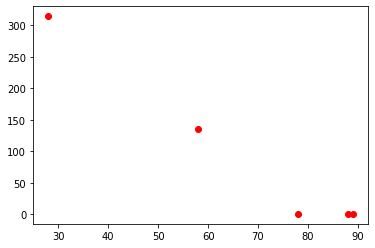

highHIIIIGHHHHHH:  251.0
rewaRD::  -94.75120184735657
returned state: [89.]
observation space:  (6,)
stepping:  0
ACTION            :  2
curtemp:  99.0
Temperature:  [28. 58. 78. 88. 89. 99.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 217.3220114631119
chisqds:  61.31410892637837
BUT ARE WE SURE?: 12272243.17032306


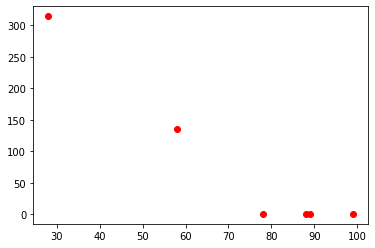

highHIIIIGHHHHHH:  241.0
rewaRD::  -93.47621604547345
returned state: [99.]
observation space:  (7,)
stepping:  0
ACTION            :  6
curtemp:  129.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 359.2698252916682
chisqds:  33.73688781524875
BUT ARE WE SURE?: 11780220.92067701


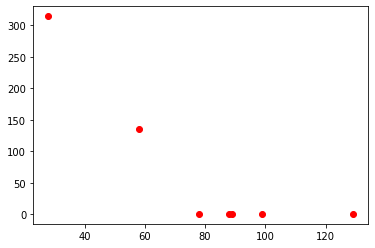

highHIIIIGHHHHHH:  211.0
rewaRD::  -88.14354180532314
returned state: [129.]
observation space:  (8,)
stepping:  0
ACTION            :  2
curtemp:  139.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 281.7948717052996
chisqds:  29.90639361181627
BUT ARE WE SURE?: 1.1588813951105376e-10


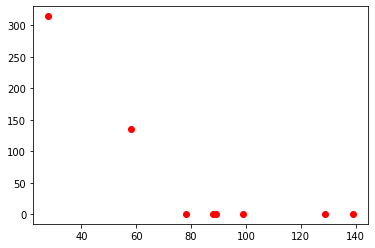

highHIIIIGHHHHHH:  201.0
rewaRD::  -86.62493361145502
returned state: [139.]
observation space:  (9,)
stepping:  0
ACTION            :  4
curtemp:  159.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 432.4537575597732
chisqds:  22.541545386458953
BUT ARE WE SURE?: 23346475.98912583


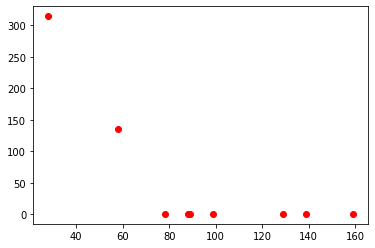

highHIIIIGHHHHHH:  181.0
rewaRD::  -82.25498770637589
returned state: [159.]
observation space:  (10,)
stepping:  0
ACTION            :  4
curtemp:  179.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 413.4703488357504
chisqds:  19.28734302649233
BUT ARE WE SURE?: 23365433.957702138


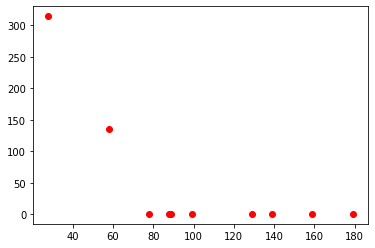

highHIIIIGHHHHHH:  161.0
rewaRD::  -79.26101073379698
returned state: [179.]
observation space:  (11,)
stepping:  0
ACTION            :  0
curtemp:  180.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 419.4362816431623
chisqds:  16.868442718528087
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


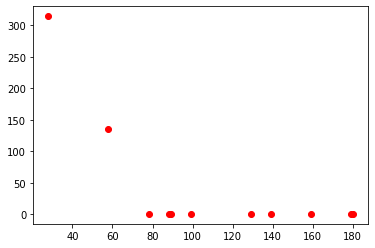

highHIIIIGHHHHHH:  160.0
rewaRD::  -76.28708193906691
returned state: [180.]
observation space:  (12,)
stepping:  0
ACTION            :  1
curtemp:  185.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 433.06127101894987
chisqds:  15.030903090576325
BUT ARE WE SURE?: 23345909.840873297


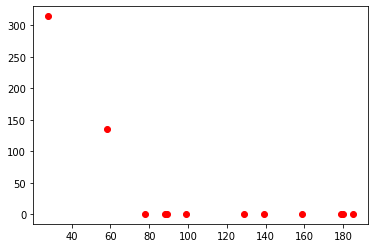

highHIIIIGHHHHHH:  155.0
rewaRD::  -73.38815920842565
returned state: [185.]
observation space:  (13,)
stepping:  0
ACTION            :  3
curtemp:  200.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 419.9526599307736
chisqds:  13.494798896352123
BUT ARE WE SURE?: 23358672.805926297


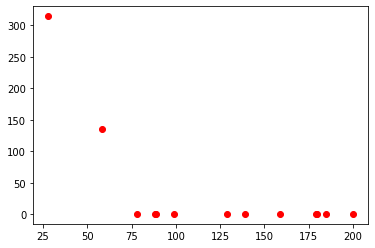

highHIIIIGHHHHHH:  140.0
rewaRD::  -70.35895065408296
returned state: [200.]
observation space:  (14,)
stepping:  0
ACTION            :  0
curtemp:  201.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 423.6000791532677
chisqds:  12.270750442287534
BUT ARE WE SURE?: 23355003.201444294


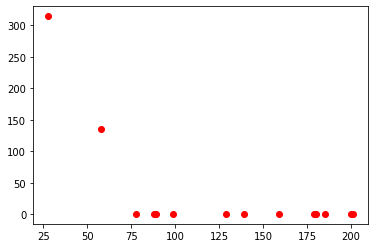

highHIIIIGHHHHHH:  139.0
rewaRD::  -67.40215670742373
returned state: [201.]
observation space:  (15,)
stepping:  0
ACTION            :  4
curtemp:  221.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 316.5837732610366
chisqds:  11.61407344326752
BUT ARE WE SURE?: 1.229695714293878e-09


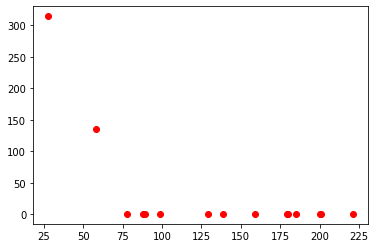

highHIIIIGHHHHHH:  119.0
rewaRD::  -65.55902612860838
returned state: [221.]
observation space:  (16,)
stepping:  0
ACTION            :  2
curtemp:  231.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 357.70534295327394
chisqds:  10.381001646998168
BUT ARE WE SURE?: 11782764.627686094


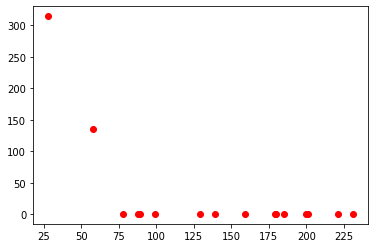

highHIIIIGHHHHHH:  109.0
rewaRD::  -61.46807277352987
returned state: [231.]
observation space:  (17,)
stepping:  0
ACTION            :  1
curtemp:  236.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 419.44154082996954
chisqds:  9.639110107510621
BUT ARE WE SURE?: 23359194.637868013


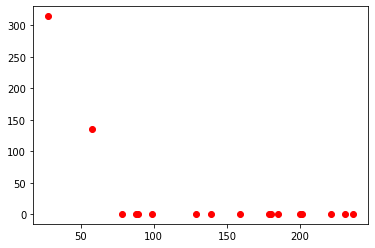

highHIIIIGHHHHHH:  104.0
rewaRD::  -58.50239331861899
returned state: [236.]
observation space:  (18,)
stepping:  0
ACTION            :  6
curtemp:  266.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 315.5756110684161
chisqds:  9.305367685515826
BUT ARE WE SURE?: 1.8463535811959369e-09


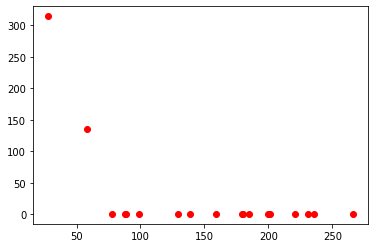

highHIIIIGHHHHHH:  74.0
rewaRD::  -57.01405752911668
returned state: [266.]
observation space:  (19,)
stepping:  0
ACTION            :  1
curtemp:  271.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266. 271.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 268.131010643149
chisqds:  9.69593559957391
BUT ARE WE SURE?: 9.519467582105795e-10


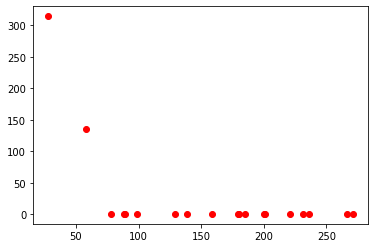

highHIIIIGHHHHHH:  69.0
rewaRD::  -58.74560057746484
returned state: [271.]
observation space:  (20,)
stepping:  0
ACTION            :  1
curtemp:  276.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266. 271. 276.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 359.15717534459327
chisqds:  7.938091005467538
BUT ARE WE SURE?: 11780402.98886841


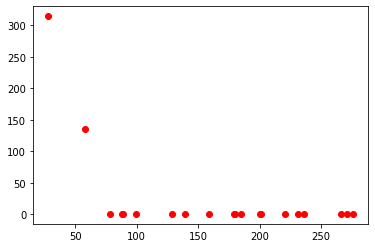

highHIIIIGHHHHHH:  64.0
rewaRD::  -49.61005111625818
returned state: [276.]
observation space:  (21,)
stepping:  0
ACTION            :  6
curtemp:  306.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266. 271. 276. 306.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.1529397308325
chisqds:  7.562843076248705
BUT ARE WE SURE?: 9.150733039846587e-09


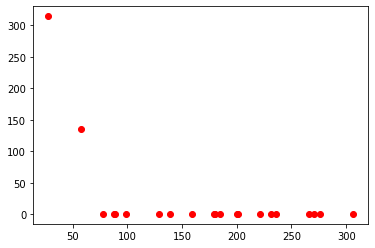

highHIIIIGHHHHHH:  34.0
rewaRD::  -47.10983740278708
returned state: [306.]
observation space:  (22,)
stepping:  0
ACTION            :  5
curtemp:  331.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266. 271. 276. 306. 331.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 313.01680079625453
chisqds:  7.375782941010049
BUT ARE WE SURE?: 159955020.45735037


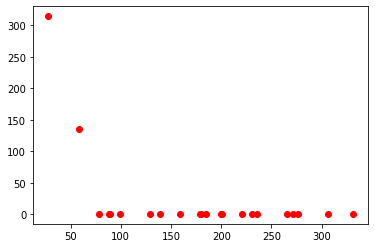

highHIIIIGHHHHHH:  9.0
rewaRD::  -45.76846916468186
returned state: [331.]
observation space:  (23,)
stepping:  0
ACTION            :  4
curtemp:  351.0
Temperature:  [ 28.  58.  78.  88.  89.  99. 129. 139. 159. 179. 180. 185. 200. 201.
 221. 231. 236. 266. 271. 276. 306. 331. 351.]
Intensity:  [3.14629340e+02 1.35546877e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 338.4380650588086
chisqds:  6.7998621757395865
BUT ARE WE SURE?: 9.6142962391014e-09


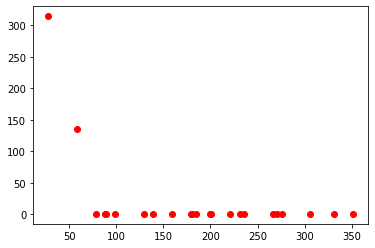

highHIIIIGHHHHHH:  -11.0
rewaRD::  -41.17527831268226
terminated: over max temp
returned state: [351.]
observation space:  (24,)
reset
fixed Tn:  70
fixed Jt:  0.8
fixed Nf:  330
stepping:  1
ACTION            :  2
curtemp:  13.0
Temperature:  [13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
returned state: [13.]
observation space:  (2,)
stepping:  1
ACTION            :  1
curtemp:  18.0
Temperature:  [13. 18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (3,)
stepping:  1
ACTION            :  4
curtemp:  38.0
Temperature:  [13. 18. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (4,)
stepping:  1
ACTION            :  5
curtemp:  63.0
Temperature:  [13. 18. 38. 63.]
Intensity:  [330.19538905 329.01984155 282.21574314  85.45206792]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 349.50409520801134
chisqds:  106.29201292804802
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


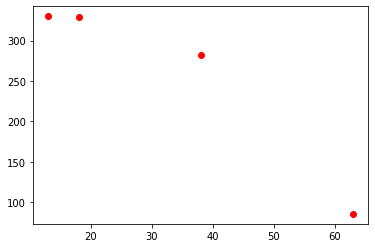

highHIIIIGHHHHHH:  277.0
rewaRD::  -96.23678215341758
returned state: [63.]
observation space:  (5,)
stepping:  1
ACTION            :  6
curtemp:  93.0
Temperature:  [13. 18. 38. 63. 93.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.40940761540094
chisqds:  54.88775587147059
BUT ARE WE SURE?: 3.1742148677844856e-09


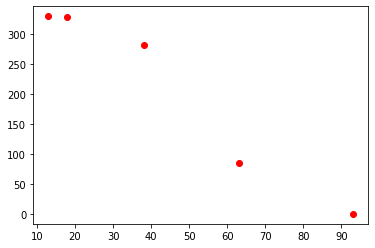

highHIIIIGHHHHHH:  247.0
rewaRD::  -92.71240017652259
returned state: [93.]
observation space:  (6,)
stepping:  1
ACTION            :  2
curtemp:  103.0
Temperature:  [ 13.  18.  38.  63.  93. 103.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.02463804113034
chisqds:  36.634879026811795
BUT ARE WE SURE?: 4.79821418274762


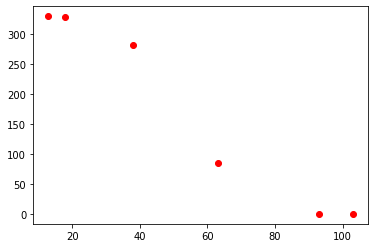

highHIIIIGHHHHHH:  237.0
rewaRD::  -89.08144340514258
returned state: [103.]
observation space:  (7,)
stepping:  1
ACTION            :  0
curtemp:  104.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 274.2328214393866
chisqds:  38.697509663021734
BUT ARE WE SURE?: 3.8448801196235776e-09


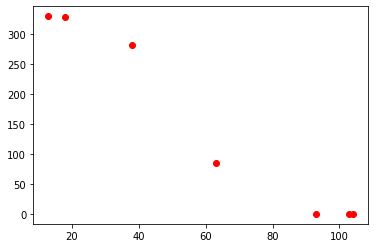

highHIIIIGHHHHHH:  236.0
rewaRD::  -89.66341753039914
returned state: [104.]
observation space:  (8,)
stepping:  1
ACTION            :  1
curtemp:  109.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.85416922291944
chisqds:  21.586190140046263
BUT ARE WE SURE?: 4.264659886485865e-09


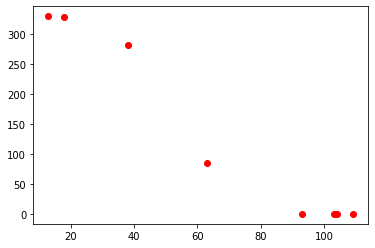

highHIIIIGHHHHHH:  231.0
rewaRD::  -81.46963417792156
returned state: [109.]
observation space:  (9,)
stepping:  1
ACTION            :  6
curtemp:  139.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 261.5242259553331
chisqds:  28.51044311589865
BUT ARE WE SURE?: 2.0402298417948324e-09


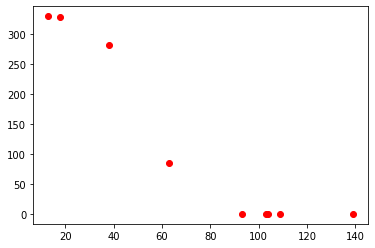

highHIIIIGHHHHHH:  201.0
rewaRD::  -85.97005320562897
returned state: [139.]
observation space:  (10,)
stepping:  1
ACTION            :  5
curtemp:  164.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 480.41206839068406
chisqds:  31.014235489960317
BUT ARE WE SURE?: 9.991993915483495e-10


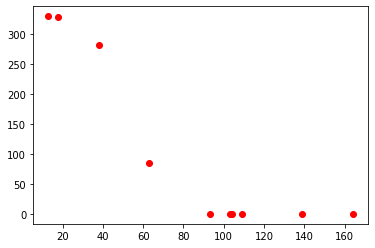

highHIIIIGHHHHHH:  176.0
rewaRD::  -87.10269675583379
returned state: [164.]
observation space:  (11,)
stepping:  1
ACTION            :  6
curtemp:  194.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.3269066554529
chisqds:  13.858762360065388
BUT ARE WE SURE?: 4.837400495578352


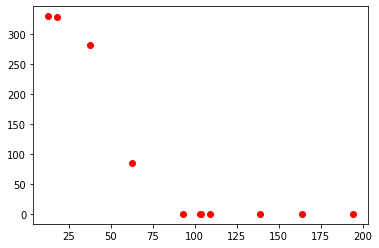

highHIIIIGHHHHHH:  146.0
rewaRD::  -71.1373938301578
returned state: [194.]
observation space:  (12,)
stepping:  1
ACTION            :  0
curtemp:  195.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.12716379712174
chisqds:  12.207780121741406
BUT ARE WE SURE?: 4.796737448444702


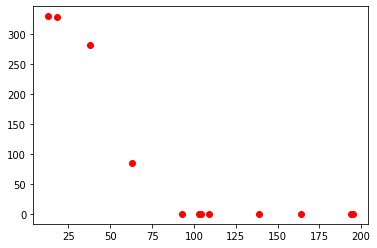

highHIIIIGHHHHHH:  145.0
rewaRD::  -67.23401011395828
returned state: [195.]
observation space:  (13,)
stepping:  1
ACTION            :  5
curtemp:  220.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 373.27961825087743
chisqds:  10.80000681260275
BUT ARE WE SURE?: 4.2807682597617385


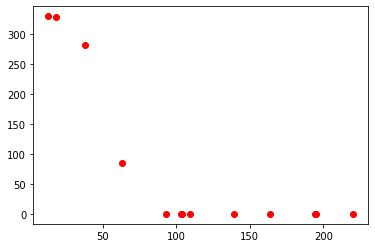

highHIIIIGHHHHHH:  120.0
rewaRD::  -62.96298632578344
returned state: [220.]
observation space:  (14,)
stepping:  1
ACTION            :  0
curtemp:  221.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.329452644894
chisqds:  10.079012555402182
BUT ARE WE SURE?: 6.753105277898565e-09


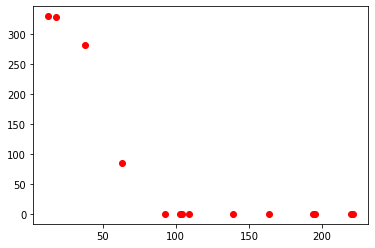

highHIIIIGHHHHHH:  119.0
rewaRD::  -60.31357260433149
returned state: [221.]
observation space:  (15,)
stepping:  1
ACTION            :  2
curtemp:  231.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 440.1949403450405
chisqds:  13.057163021934088
BUT ARE WE SURE?: 1.3887834852499948e-09


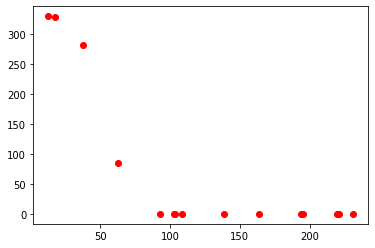

highHIIIIGHHHHHH:  109.0
rewaRD::  -69.36547400625545
returned state: [231.]
observation space:  (16,)
stepping:  1
ACTION            :  4
curtemp:  251.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231. 251.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.1330776746749
chisqds:  8.451386847517576
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


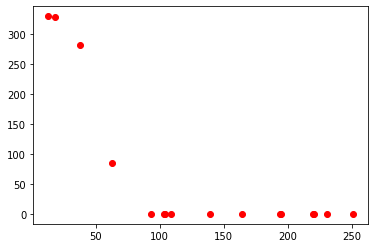

highHIIIIGHHHHHH:  89.0
rewaRD::  -52.670489800441224
returned state: [251.]
observation space:  (17,)
stepping:  1
ACTION            :  4
curtemp:  271.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231. 251. 271.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.142710677487
chisqds:  7.847484660189747
BUT ARE WE SURE?: 4.79651359820669


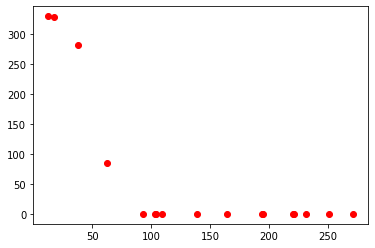

highHIIIIGHHHHHH:  69.0
rewaRD::  -49.02825334222084
returned state: [271.]
observation space:  (18,)
stepping:  1
ACTION            :  6
curtemp:  301.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231. 251. 271. 301.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.3006806327897
chisqds:  7.39200007723641
BUT ARE WE SURE?: 33.020558948733196


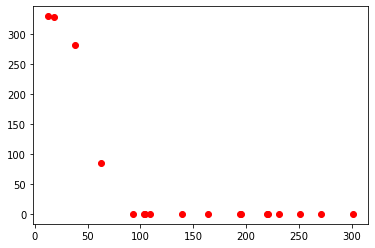

highHIIIIGHHHHHH:  39.0
rewaRD::  -45.887446452848934
returned state: [301.]
observation space:  (19,)
stepping:  1
ACTION            :  6
curtemp:  331.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231. 251. 271. 301. 331.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.12209779084185
chisqds:  6.866982998252737
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


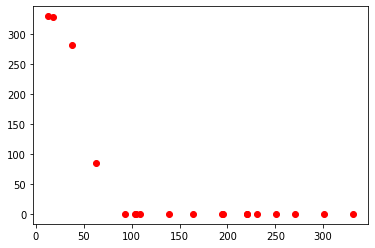

highHIIIIGHHHHHH:  9.0
rewaRD::  -41.75025624764505
returned state: [331.]
observation space:  (20,)
stepping:  1
ACTION            :  2
curtemp:  341.0
Temperature:  [ 13.  18.  38.  63.  93. 103. 104. 109. 139. 164. 194. 195. 220. 221.
 231. 251. 271. 301. 331. 341.]
Intensity:  [3.30195389e+02 3.29019842e+02 2.82215743e+02 8.54520679e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.1286026306576
chisqds:  6.462913904758202
BUT ARE WE SURE?: 90234587989.84796


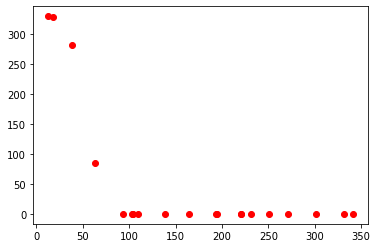

highHIIIIGHHHHHH:  -1.0
rewaRD::  -38.10841272301224
terminated: over max temp
returned state: [341.]
observation space:  (21,)
reset
fixed Tn:  280
fixed Jt:  1.0
fixed Nf:  330
stepping:  2
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  2
ACTION            :  6
curtemp:  53.0
Temperature:  [23. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
returned state: [53.]
observation space:  (3,)
stepping:  2
ACTION            :  5
curtemp:  78.0
Temperature:  [23. 53. 78.]
highHIIIIGHHHHHH:  262.0
rewaRD::  -100
returned state: [78.]
observation space:  (4,)
stepping:  2
ACTION            :  3
curtemp:  93.0
Temperature:  [23. 53. 78. 93.]
Intensity:  [330.29999226 330.06050708 327.18770642 322.65476181]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 266.8187393234269
chisqds:  46.29423691948921
BUT ARE WE SURE?: 9.99484656416361e-10


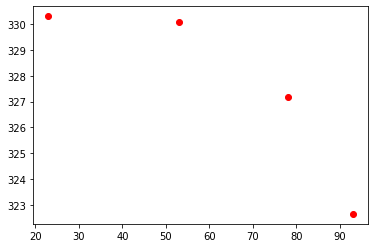

highHIIIIGHHHHHH:  247.0
rewaRD::  -91.35961565376606
returned state: [93.]
observation space:  (5,)
stepping:  2
ACTION            :  6
curtemp:  123.0
Temperature:  [ 23.  53.  78.  93. 123.]
Intensity:  [330.29999226 330.06050708 327.18770642 322.65476181 305.14941374]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 289.3509706066101
chisqds:  11.070121622907333
BUT ARE WE SURE?: 2.82922459394889e-09


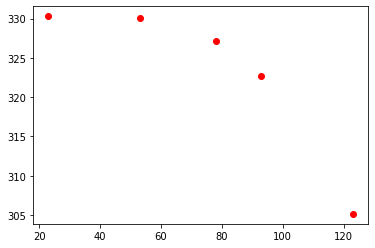

highHIIIIGHHHHHH:  217.0
rewaRD::  -63.866702315873155
returned state: [123.]
observation space:  (6,)
stepping:  2
ACTION            :  5
curtemp:  148.0
Temperature:  [ 23.  53.  78.  93. 123. 148.]
Intensity:  [330.29999226 330.06050708 327.18770642 322.65476181 305.14941374
 281.1071106 ]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.374395479904
chisqds:  0.4340857899358346
BUT ARE WE SURE?: 3.3719453631120637e-09


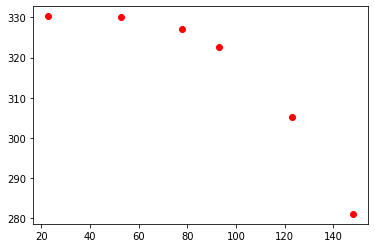

highHIIIIGHHHHHH:  192.0
rewaRD::  300
returned state: [148.]
observation space:  (7,)
stepping:  2
ACTION            :  0
curtemp:  149.0
Temperature:  [ 23.  53.  78.  93. 123. 148. 149.]
Intensity:  [330.29999226 330.06050708 327.18770642 322.65476181 305.14941374
 281.1071106  279.95996188]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.9367199040538
chisqds:  0.03530357578145543
BUT ARE WE SURE?: 3.5377676605694814e-09


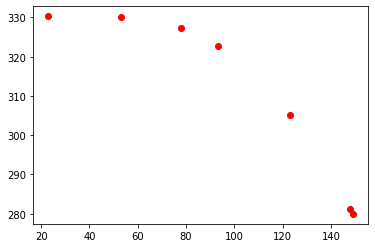

highHIIIIGHHHHHH:  191.0
rewaRD::  300
terminated: excellent conditions
returned state: [149.]
observation space:  (8,)
reset
fixed Tn:  220
fixed Jt:  1.0
fixed Nf:  330
stepping:  3
ACTION            :  5
curtemp:  28.0
Temperature:  [28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
returned state: [28.]
observation space:  (2,)
stepping:  3
ACTION            :  1
curtemp:  33.0
Temperature:  [28. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (3,)
stepping:  3
ACTION            :  5
curtemp:  58.0
Temperature:  [28. 33. 58.]
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
returned state: [58.]
observation space:  (4,)
stepping:  3
ACTION            :  6
curtemp:  88.0
Temperature:  [28. 33. 58. 88.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 287.30490342250243
chisqds:  20.615192725652772
BUT ARE WE SURE?: 2.4535090647255196e-09


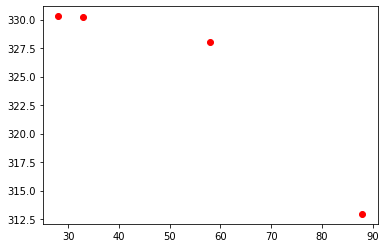

highHIIIIGHHHHHH:  252.0
rewaRD::  -80.59683431907698
returned state: [88.]
observation space:  (5,)
stepping:  3
ACTION            :  4
curtemp:  108.0
Temperature:  [ 28.  33.  58.  88. 108.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 315.9642735861671
chisqds:  1.1528079185769895
BUT ARE WE SURE?: 6.026117876354727e-09


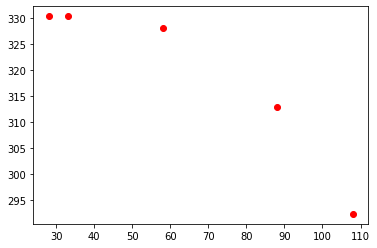

highHIIIIGHHHHHH:  232.0
rewaRD::  246.97887961574258
returned state: [108.]
observation space:  (6,)
stepping:  3
ACTION            :  2
curtemp:  118.0
Temperature:  [ 28.  33.  58.  88. 108. 118.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 328.73935585496093
chisqds:  0.014324930199351264
BUT ARE WE SURE?: 27515091.28592165


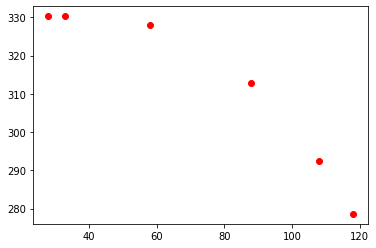

highHIIIIGHHHHHH:  222.0
rewaRD::  300
returned state: [118.]
observation space:  (7,)
stepping:  3
ACTION            :  4
curtemp:  138.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472 244.04551378]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 319.6286422881775
chisqds:  0.6019701257129113
BUT ARE WE SURE?: 1.3287777037483224


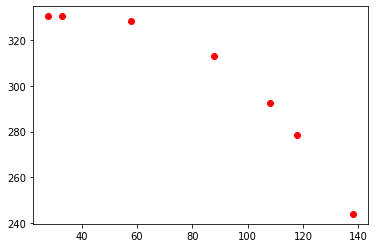

highHIIIIGHHHHHH:  202.0
rewaRD::  300
returned state: [138.]
observation space:  (8,)
stepping:  3
ACTION            :  6
curtemp:  168.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472 244.04551378 174.19451162]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 407.57750209351127
chisqds:  23.477333559049338
BUT ARE WE SURE?: 2.892880528071053e-10


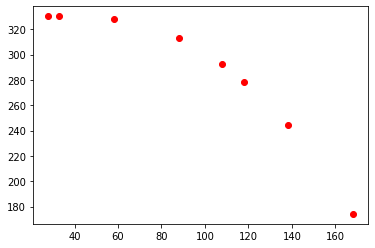

highHIIIIGHHHHHH:  172.0
rewaRD::  -82.96229003204583
returned state: [168.]
observation space:  (9,)
stepping:  3
ACTION            :  3
curtemp:  183.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472 244.04551378 174.19451162 130.98289572]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 101.37426914747006
chisqds:  199.55701874755212
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


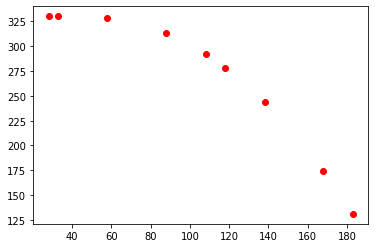

highHIIIIGHHHHHH:  157.0
rewaRD::  -97.99556035407596
returned state: [183.]
observation space:  (10,)
stepping:  3
ACTION            :  3
curtemp:  198.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472 244.04551378 174.19451162 130.98289572  82.16142922]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 382.87233598677807
chisqds:  17.992853345329724
BUT ARE WE SURE?: 4.809672052976816e-10


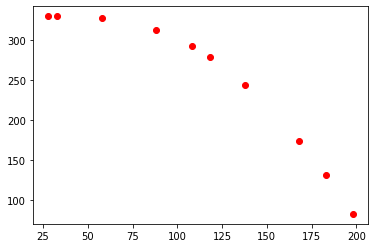

highHIIIIGHHHHHH:  142.0
rewaRD::  -77.76895124286526
returned state: [198.]
observation space:  (11,)
stepping:  3
ACTION            :  4
curtemp:  218.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218.]
Intensity:  [330.29497526 330.27002175 328.02049894 312.95945662 292.33017504
 278.58563472 244.04551378 174.19451162 130.98289572  82.16142922
   8.24910561]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 302.8652341334268
chisqds:  15.29186855830564
BUT ARE WE SURE?: 1.0300605491351695e-09


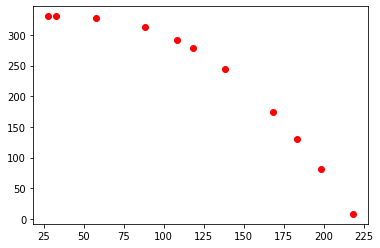

highHIIIIGHHHHHH:  122.0
rewaRD::  -73.84230720563292
returned state: [218.]
observation space:  (12,)
stepping:  3
ACTION            :  5
curtemp:  243.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218. 243.]
Intensity:  [3.30294975e+02 3.30270022e+02 3.28020499e+02 3.12959457e+02
 2.92330175e+02 2.78585635e+02 2.44045514e+02 1.74194512e+02
 1.30982896e+02 8.21614292e+01 8.24910561e+00 3.00000000e-01]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 338.64649828104496
chisqds:  10.474717656454304
BUT ARE WE SURE?: 1.1402614219797543e-08


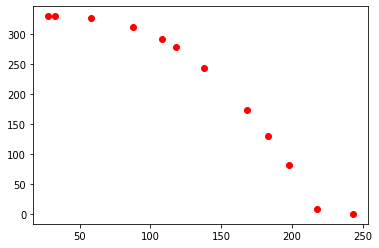

highHIIIIGHHHHHH:  97.0
rewaRD::  -61.81281318322425
returned state: [243.]
observation space:  (13,)
stepping:  3
ACTION            :  6
curtemp:  273.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218. 243. 273.]
Intensity:  [3.30294975e+02 3.30270022e+02 3.28020499e+02 3.12959457e+02
 2.92330175e+02 2.78585635e+02 2.44045514e+02 1.74194512e+02
 1.30982896e+02 8.21614292e+01 8.24910561e+00 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 361.7650519809713
chisqds:  10.462737735084726
BUT ARE WE SURE?: 1.2357609477094677e-08


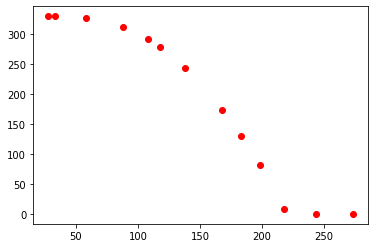

highHIIIIGHHHHHH:  67.0
rewaRD::  -61.769088538014394
returned state: [273.]
observation space:  (14,)
stepping:  3
ACTION            :  6
curtemp:  303.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218. 243. 273. 303.]
Intensity:  [3.30294975e+02 3.30270022e+02 3.28020499e+02 3.12959457e+02
 2.92330175e+02 2.78585635e+02 2.44045514e+02 1.74194512e+02
 1.30982896e+02 8.21614292e+01 8.24910561e+00 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 320.31997566332154
chisqds:  9.268506934162728
BUT ARE WE SURE?: 3.185306450407214e-10


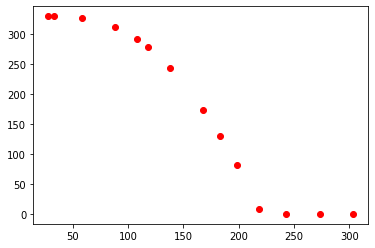

highHIIIIGHHHHHH:  37.0
rewaRD::  -56.84310290305306
returned state: [303.]
observation space:  (15,)
stepping:  3
ACTION            :  6
curtemp:  333.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218. 243. 273. 303.
 333.]
Intensity:  [3.30294975e+02 3.30270022e+02 3.28020499e+02 3.12959457e+02
 2.92330175e+02 2.78585635e+02 2.44045514e+02 1.74194512e+02
 1.30982896e+02 8.21614292e+01 8.24910561e+00 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 320.05363713615407
chisqds:  8.514066777674843
BUT ARE WE SURE?: 2.7985133313642424e-10


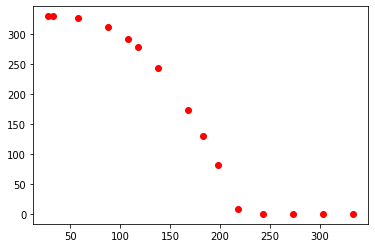

highHIIIIGHHHHHH:  7.0
rewaRD::  -53.0189261553762
returned state: [333.]
observation space:  (16,)
stepping:  3
ACTION            :  6
curtemp:  363.0
Temperature:  [ 28.  33.  58.  88. 108. 118. 138. 168. 183. 198. 218. 243. 273. 303.
 333. 363.]
Intensity:  [3.30294975e+02 3.30270022e+02 3.28020499e+02 3.12959457e+02
 2.92330175e+02 2.78585635e+02 2.44045514e+02 1.74194512e+02
 1.30982896e+02 8.21614292e+01 8.24910561e+00 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 200.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 316.39752039181855
chisqds:  8.109483025590329
BUT ARE WE SURE?: 7.392440094498181e-10


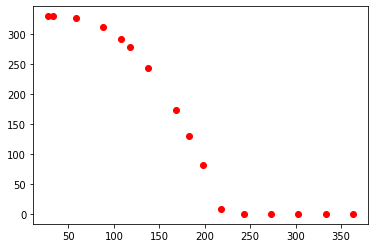

highHIIIIGHHHHHH:  -23.0
rewaRD::  -50.67503085736072
terminated: over max temp
returned state: [363.]
observation space:  (17,)
reset
fixed Tn:  40
fixed Jt:  1.2
fixed Nf:  330
stepping:  4
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  4
ACTION            :  4
curtemp:  24.0
Temperature:  [ 4. 24.]
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
returned state: [24.]
observation space:  (3,)
stepping:  4
ACTION            :  3
curtemp:  39.0
Temperature:  [ 4. 24. 39.]
highHIIIIGHHHHHH:  301.0
rewaRD::  -100
returned state: [39.]
observation space:  (4,)
stepping:  4
ACTION            :  4
curtemp:  59.0
Temperature:  [ 4. 24. 39. 59.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.5811017894470265
THE NF RESULT {X1}: 330.0633564991004
chisqds:  269.5930995103232
BUT ARE WE SURE?: 3824350123.736246


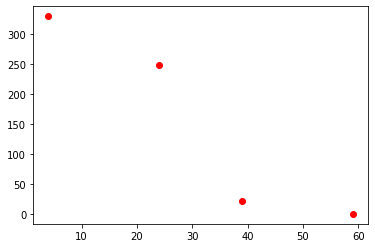

highHIIIIGHHHHHH:  281.0
rewaRD::  -98.51628249860052
returned state: [59.]
observation space:  (5,)
stepping:  4
ACTION            :  5
curtemp:  84.0
Temperature:  [ 4. 24. 39. 59. 84.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 332.2813128245677
chisqds:  134.79654909593927
BUT ARE WE SURE?: 2932094124.557208


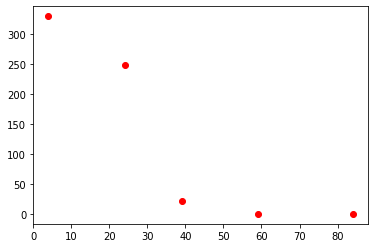

highHIIIIGHHHHHH:  256.0
rewaRD::  -97.03256498268878
returned state: [84.]
observation space:  (6,)
stepping:  4
ACTION            :  1
curtemp:  89.0
Temperature:  [ 4. 24. 39. 59. 84. 89.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 1.238654060541786
THE NF RESULT {X1}: 330.633475964431
chisqds:  89.86436677413487
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


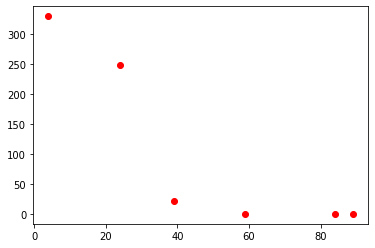

highHIIIIGHHHHHH:  251.0
rewaRD::  -95.54884750920951
returned state: [89.]
observation space:  (7,)
stepping:  4
ACTION            :  1
curtemp:  94.0
Temperature:  [ 4. 24. 39. 59. 84. 89. 94.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.6718172930977792
THE NF RESULT {X1}: 330.1082365912233
chisqds:  67.39827469753853
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


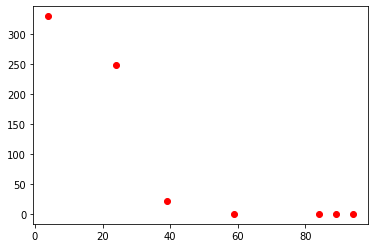

highHIIIIGHHHHHH:  246.0
rewaRD::  -94.06512997854813
returned state: [94.]
observation space:  (8,)
stepping:  4
ACTION            :  3
curtemp:  109.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 322.1689510939
chisqds:  53.95608690175537
BUT ARE WE SURE?: 4.299985766234867e-09


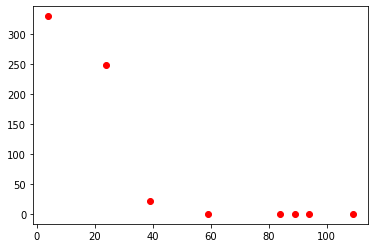

highHIIIIGHHHHHH:  231.0
rewaRD::  -92.58656394544826
returned state: [109.]
observation space:  (9,)
stepping:  4
ACTION            :  3
curtemp:  124.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 1.240177220973528
THE NF RESULT {X1}: 330.6927959277646
chisqds:  44.932183437643836
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


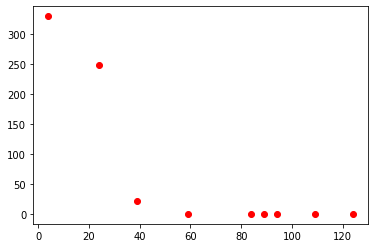

highHIIIIGHHHHHH:  216.0
rewaRD::  -91.09769502843962
returned state: [124.]
observation space:  (10,)
stepping:  4
ACTION            :  2
curtemp:  134.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 358.76942585739715
chisqds:  38.87030258907362
BUT ARE WE SURE?: 5.049474322128411e-09


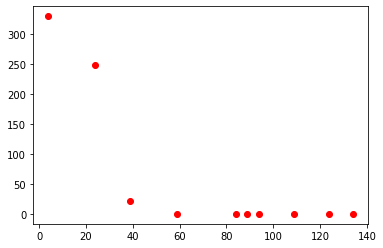

highHIIIIGHHHHHH:  206.0
rewaRD::  -89.70936747705073
returned state: [134.]
observation space:  (11,)
stepping:  4
ACTION            :  6
curtemp:  164.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4179559181612753
THE NF RESULT {X1}: 330.01344763986833
chisqds:  33.699137509726825
BUT ARE WE SURE?: 97980998.05854994


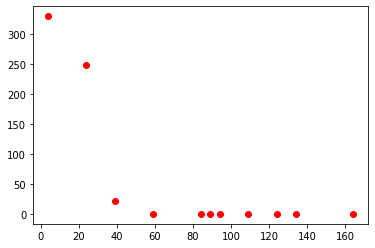

highHIIIIGHHHHHH:  176.0
rewaRD::  -88.13026001378981
returned state: [164.]
observation space:  (12,)
stepping:  4
ACTION            :  6
curtemp:  194.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.45705432570451726
THE NF RESULT {X1}: 330.03971934235796
chisqds:  29.954788692452
BUT ARE WE SURE?: 97270674.54462998


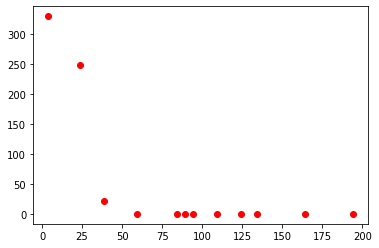

highHIIIIGHHHHHH:  146.0
rewaRD::  -86.64654242409021
returned state: [194.]
observation space:  (13,)
stepping:  4
ACTION            :  2
curtemp:  204.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.5135621228122691
THE NF RESULT {X1}: 330.0584224810387
chisqds:  26.959309808410687
BUT ARE WE SURE?: 95936021.12977055


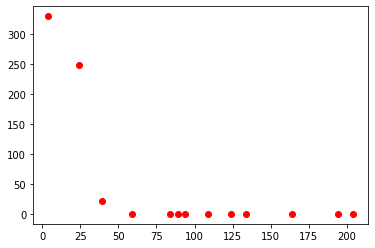

highHIIIIGHHHHHH:  136.0
rewaRD::  -85.16282490751269
returned state: [204.]
observation space:  (14,)
stepping:  4
ACTION            :  3
curtemp:  219.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.47580644706656183
THE NF RESULT {X1}: 330.0426420704033
chisqds:  24.50846348446545
BUT ARE WE SURE?: 96870305.13379905


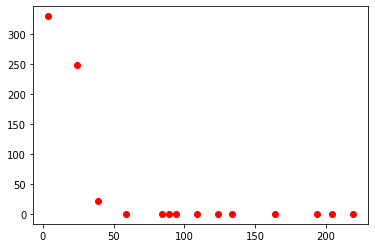

highHIIIIGHHHHHH:  121.0
rewaRD::  -83.6791074130968
returned state: [219.]
observation space:  (15,)
stepping:  4
ACTION            :  3
curtemp:  234.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 203.01613149838522
chisqds:  26.53575024582086
BUT ARE WE SURE?: 7.842591078676427e-10


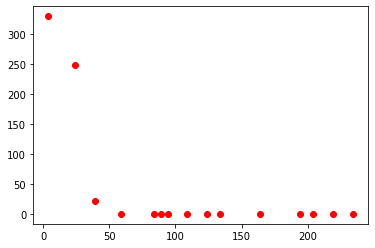

highHIIIIGHHHHHH:  106.0
rewaRD::  -84.92599620155845
returned state: [234.]
observation space:  (16,)
stepping:  4
ACTION            :  3
curtemp:  249.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.7054778191141822
THE NF RESULT {X1}: 330.11672044223127
chisqds:  20.73793075789363
BUT ARE WE SURE?: 88311715.45450163


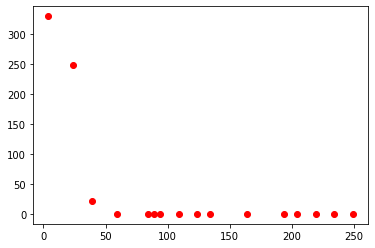

highHIIIIGHHHHHH:  91.0
rewaRD::  -80.71167250629645
returned state: [249.]
observation space:  (17,)
stepping:  4
ACTION            :  4
curtemp:  269.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249. 269.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.0072968898828
chisqds:  19.25665003662092
BUT ARE WE SURE?: 98255070.37452129


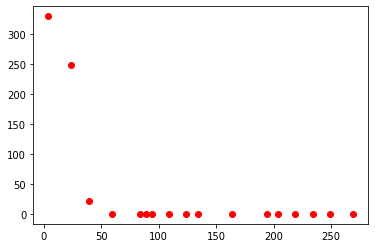

highHIIIIGHHHHHH:  71.0
rewaRD::  -79.22795505763938
returned state: [269.]
observation space:  (18,)
stepping:  4
ACTION            :  6
curtemp:  299.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249. 269. 299.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 327.9350314493097
chisqds:  17.97376394848791
BUT ARE WE SURE?: 6.578357636904133e-10


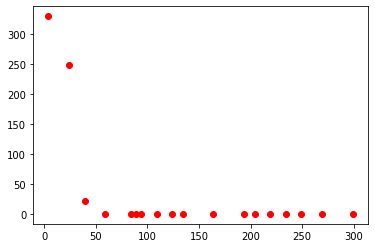

highHIIIIGHHHHHH:  41.0
rewaRD::  -77.7453403112234
returned state: [299.]
observation space:  (19,)
stepping:  4
ACTION            :  6
curtemp:  329.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249. 269. 299. 329.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 236.50578132067147
chisqds:  18.50449967597498
BUT ARE WE SURE?: 144200044.54791233


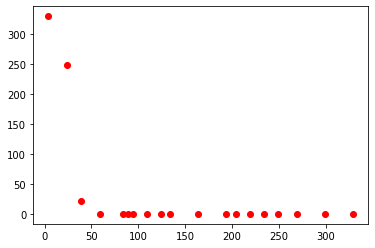

highHIIIIGHHHHHH:  11.0
rewaRD::  -78.38363603424881
returned state: [329.]
observation space:  (20,)
stepping:  4
ACTION            :  2
curtemp:  339.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249. 269. 299. 329. 339.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 419.3189192146022
chisqds:  17.27774733043919
BUT ARE WE SURE?: 8.690161231686185e-10


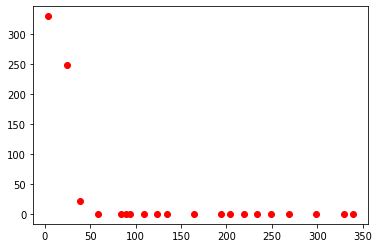

highHIIIIGHHHHHH:  1.0
rewaRD::  -76.84883380049799
returned state: [339.]
observation space:  (21,)
stepping:  4
ACTION            :  3
curtemp:  354.0
Temperature:  [  4.  24.  39.  59.  84.  89.  94. 109. 124. 134. 164. 194. 204. 219.
 234. 249. 269. 299. 329. 339. 354.]
Intensity:  [3.30299342e+02 2.49652068e+02 2.11364117e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.01557148241824
chisqds:  14.97739440448847
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


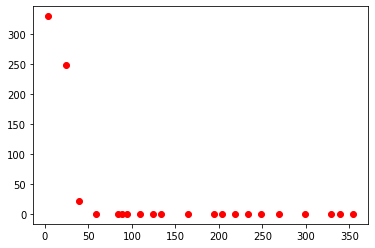

highHIIIIGHHHHHH:  -14.0
rewaRD::  -73.29308495207104
terminated: over max temp
returned state: [354.]
observation space:  (22,)
reset
fixed Tn:  290
fixed Jt:  0.7
fixed Nf:  330
stepping:  5
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
stepping:  5
ACTION            :  0
curtemp:  34.0
Temperature:  [33. 34.]
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
returned state: [34.]
observation space:  (3,)
stepping:  5
ACTION            :  5
curtemp:  59.0
Temperature:  [33. 34. 59.]
highHIIIIGHHHHHH:  281.0
rewaRD::  -100
returned state: [59.]
observation space:  (4,)
stepping:  5
ACTION            :  4
curtemp:  79.0
Temperature:  [33. 34. 59. 79.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 291.47537968463257
chisqds:  17.85966900845226
BUT ARE WE SURE?: 1.169877381979609e-09


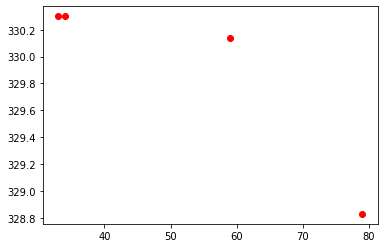

highHIIIIGHHHHHH:  261.0
rewaRD::  -77.60316835599271
returned state: [79.]
observation space:  (5,)
stepping:  5
ACTION            :  0
curtemp:  80.0
Temperature:  [33. 34. 59. 79. 80.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 357.71406043726796
chisqds:  5.878929196282436
BUT ARE WE SURE?: 1.3344588546731218e-10


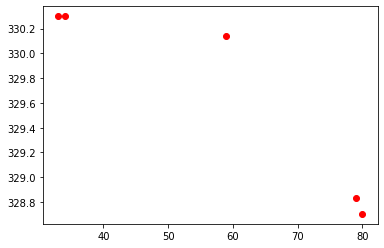

highHIIIIGHHHHHH:  260.0
rewaRD::  -31.960398459477688
returned state: [80.]
observation space:  (6,)
stepping:  5
ACTION            :  5
curtemp:  105.0
Temperature:  [ 33.  34.  59.  79.  80. 105.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 238.20021646791685
chisqds:  50.53982495081192
BUT ARE WE SURE?: 1.0871510362162633e-09


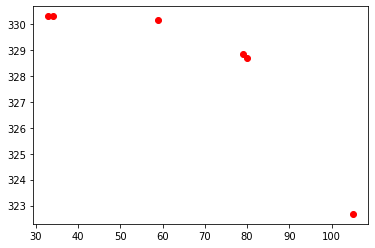

highHIIIIGHHHHHH:  235.0
rewaRD::  -92.08544943736348
returned state: [105.]
observation space:  (7,)
stepping:  5
ACTION            :  1
curtemp:  110.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086 ]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 325.45983562432747
chisqds:  0.09404830152005077
BUT ARE WE SURE?: 1.7211926888594695e-10


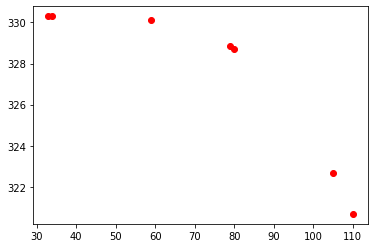

highHIIIIGHHHHHH:  230.0
rewaRD::  300
returned state: [110.]
observation space:  (8,)
stepping:  5
ACTION            :  6
curtemp:  140.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 272.61577405268366
chisqds:  15.591260085931726
BUT ARE WE SURE?: 4.064362383304876e-09


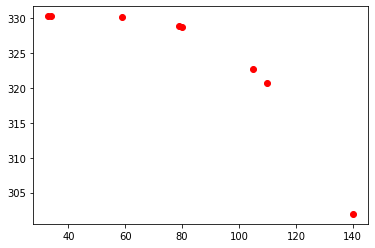

highHIIIIGHHHHHH:  200.0
rewaRD::  -74.34460089849138
returned state: [140.]
observation space:  (9,)
stepping:  5
ACTION            :  6
curtemp:  170.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031 ]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 347.06472383557315
chisqds:  1.2065155502765568
BUT ARE WE SURE?: 4.471081053886924e-09


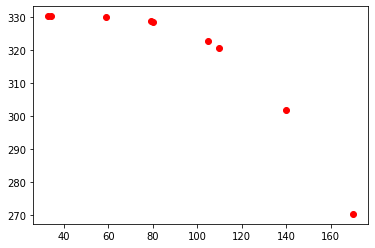

highHIIIIGHHHHHH:  170.0
rewaRD::  231.53323213141533
returned state: [170.]
observation space:  (10,)
stepping:  5
ACTION            :  5
curtemp:  195.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 1.5953239842746898
THE NF RESULT {X1}: 329.9936383930902
chisqds:  3.3311512422097342
BUT ARE WE SURE?: 1.2472653892700025


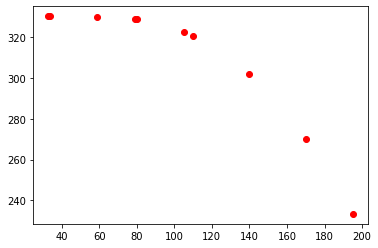

highHIIIIGHHHHHH:  145.0
rewaRD::  20.07860673856952
returned state: [195.]
observation space:  (11,)
stepping:  5
ACTION            :  4
curtemp:  215.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 385.23774678688704
chisqds:  10.045723532849687
BUT ARE WE SURE?: 0.6467628801704907


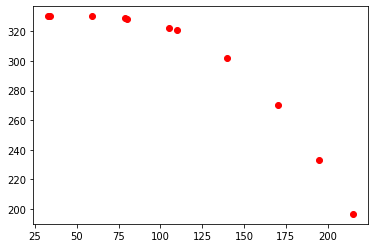

highHIIIIGHHHHHH:  125.0
rewaRD::  -60.18206168107322
returned state: [215.]
observation space:  (12,)
stepping:  5
ACTION            :  1
curtemp:  220.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 398.90801986007176
chisqds:  14.136650127082182
BUT ARE WE SURE?: 1.22425410792702e-09


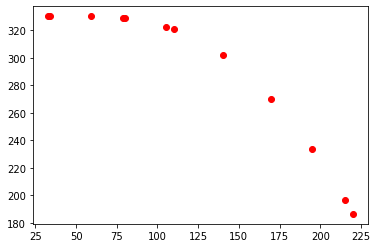

highHIIIIGHHHHHH:  120.0
rewaRD::  -71.70475350212544
returned state: [220.]
observation space:  (13,)
stepping:  5
ACTION            :  1
curtemp:  225.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935 175.83528566]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 287.20155561182884
chisqds:  9.341810845988544
BUT ARE WE SURE?: 0.7022913121701599


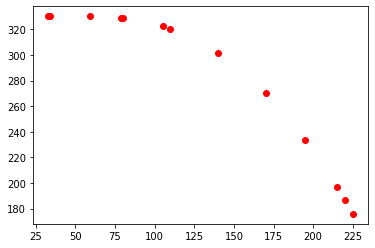

highHIIIIGHHHHHH:  115.0
rewaRD::  -57.18174917106531
returned state: [225.]
observation space:  (14,)
stepping:  5
ACTION            :  6
curtemp:  255.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935 175.83528566 103.5502253 ]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 310.2445139406641
chisqds:  5.649199464954319
BUT ARE WE SURE?: 7.092074296550386e-10


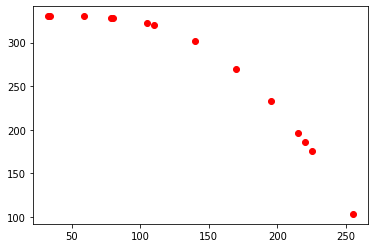

highHIIIIGHHHHHH:  85.0
rewaRD::  -29.193507419686313
returned state: [255.]
observation space:  (15,)
stepping:  5
ACTION            :  3
curtemp:  270.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935 175.83528566 103.5502253   61.80841095]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 315.85444758023414
chisqds:  9.452112083889359
BUT ARE WE SURE?: 7.309736671669028e-10


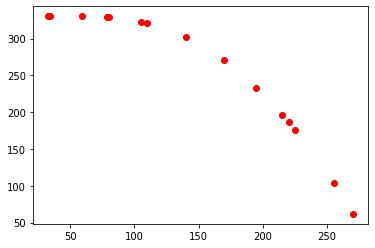

highHIIIIGHHHHHH:  70.0
rewaRD::  -57.68141591530855
returned state: [270.]
observation space:  (16,)
stepping:  5
ACTION            :  0
curtemp:  271.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270. 271.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935 175.83528566 103.5502253   61.80841095
  58.89213875]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 390.8801064323428
chisqds:  17.911318863343816
BUT ARE WE SURE?: 61509645.59712193


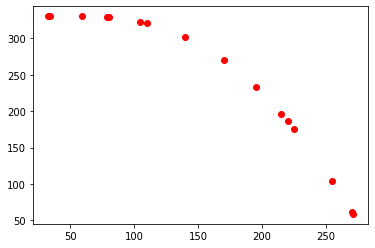

highHIIIIGHHHHHH:  69.0
rewaRD::  -77.66775282982567
returned state: [271.]
observation space:  (17,)
stepping:  5
ACTION            :  1
curtemp:  276.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270. 271. 276.]
Intensity:  [330.29982646 330.29972616 330.13844404 328.82966306 328.70398315
 322.67775186 320.6801086  301.93757589 270.3239031  233.38118042
 196.64109276 186.44242935 175.83528566 103.5502253   61.80841095
  58.89213875  44.05974674]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 313.883107415622
chisqds:  15.60277497380963
BUT ARE WE SURE?: 8.303957361479796e-10


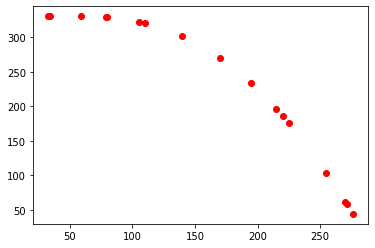

highHIIIIGHHHHHH:  64.0
rewaRD::  -74.3635346487129
returned state: [276.]
observation space:  (18,)
stepping:  5
ACTION            :  4
curtemp:  296.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270. 271. 276. 296.]
Intensity:  [3.30299826e+02 3.30299726e+02 3.30138444e+02 3.28829663e+02
 3.28703983e+02 3.22677752e+02 3.20680109e+02 3.01937576e+02
 2.70323903e+02 2.33381180e+02 1.96641093e+02 1.86442429e+02
 1.75835286e+02 1.03550225e+02 6.18084110e+01 5.88921388e+01
 4.40597467e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.64573233286575
chisqds:  13.16839131859327
BUT ARE WE SURE?: 7.76581631447935e-09


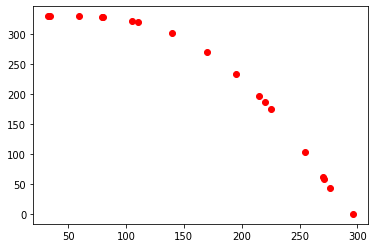

highHIIIIGHHHHHH:  44.0
rewaRD::  -69.62423197165965
returned state: [296.]
observation space:  (19,)
stepping:  5
ACTION            :  5
curtemp:  321.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270. 271. 276. 296. 321.]
Intensity:  [3.30299826e+02 3.30299726e+02 3.30138444e+02 3.28829663e+02
 3.28703983e+02 3.22677752e+02 3.20680109e+02 3.01937576e+02
 2.70323903e+02 2.33381180e+02 1.96641093e+02 1.86442429e+02
 1.75835286e+02 1.03550225e+02 6.18084110e+01 5.88921388e+01
 4.40597467e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 321.44003279653515
chisqds:  12.956383397548294
BUT ARE WE SURE?: 8.180867677947782e-09


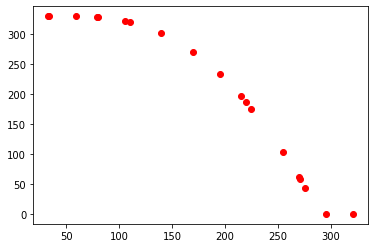

highHIIIIGHHHHHH:  19.0
rewaRD::  -69.12718713806423
returned state: [321.]
observation space:  (20,)
stepping:  5
ACTION            :  5
curtemp:  346.0
Temperature:  [ 33.  34.  59.  79.  80. 105. 110. 140. 170. 195. 215. 220. 225. 255.
 270. 271. 276. 296. 321. 346.]
Intensity:  [3.30299826e+02 3.30299726e+02 3.30138444e+02 3.28829663e+02
 3.28703983e+02 3.22677752e+02 3.20680109e+02 3.01937576e+02
 2.70323903e+02 2.33381180e+02 1.96641093e+02 1.86442429e+02
 1.75835286e+02 1.03550225e+02 6.18084110e+01 5.88921388e+01
 4.40597467e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.80120183300096
chisqds:  11.720315648956092
BUT ARE WE SURE?: 8.423909522571664e-09


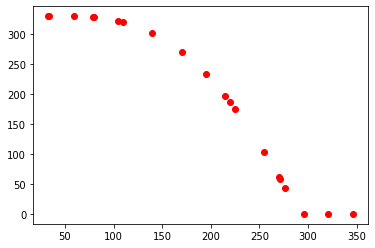

highHIIIIGHHHHHH:  -6.0
rewaRD::  -65.87122634059543
terminated: over max temp
returned state: [346.]
observation space:  (21,)
reset
fixed Tn:  230
fixed Jt:  1.0
fixed Nf:  330
stepping:  6
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  6
ACTION            :  0
curtemp:  24.0
Temperature:  [23. 24.]
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
returned state: [24.]
observation space:  (3,)
stepping:  6
ACTION            :  0
curtemp:  25.0
Temperature:  [23. 24. 25.]
highHIIIIGHHHHHH:  315.0
rewaRD::  -100
returned state: [25.]
observation space:  (4,)
stepping:  6
ACTION            :  0
curtemp:  26.0
Temperature:  [23. 24. 25. 26.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.47432961321450695
THE NF RESULT {X1}: 200.00001234091417
chisqds:  204.66097004591074
BUT ARE WE SURE?: 480382.2153436066


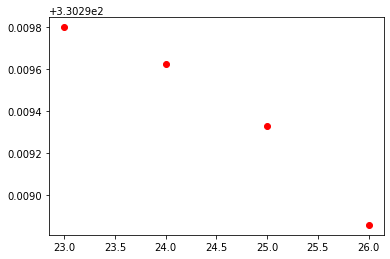

highHIIIIGHHHHHH:  314.0
rewaRD::  -98.04554820633231
returned state: [26.]
observation space:  (5,)
stepping:  6
ACTION            :  2
curtemp:  36.0
Temperature:  [23. 24. 25. 26. 36.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.46430093610916245
THE NF RESULT {X1}: 200.00136997825985
chisqds:  127.89841804731165
BUT ARE WE SURE?: 35586.92667049826


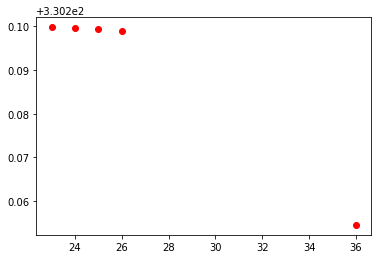

highHIIIIGHHHHHH:  304.0
rewaRD::  -96.87251800212233
returned state: [36.]
observation space:  (6,)
stepping:  6
ACTION            :  4
curtemp:  56.0
Temperature:  [23. 24. 25. 26. 36. 56.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 205.3581468846655
chisqds:  93.85657834487091
BUT ARE WE SURE?: 2.0992215961370062e-10


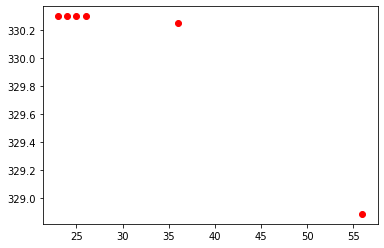

highHIIIIGHHHHHH:  284.0
rewaRD::  -95.73817832427024
returned state: [56.]
observation space:  (7,)
stepping:  6
ACTION            :  2
curtemp:  66.0
Temperature:  [23. 24. 25. 26. 36. 56. 66.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.5492917901214802
THE NF RESULT {X1}: 325.9362682935935
chisqds:  0.0782945983438571
BUT ARE WE SURE?: 77.17149992303027


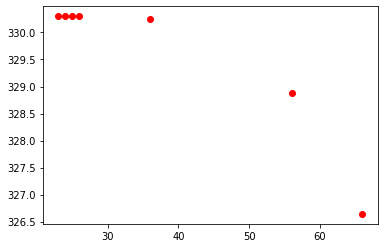

highHIIIIGHHHHHH:  274.0
rewaRD::  300
returned state: [66.]
observation space:  (8,)
stepping:  6
ACTION            :  0
curtemp:  67.0
Temperature:  [23. 24. 25. 26. 36. 56. 66. 67.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 221.69065287916402
chisqds:  56.218560638237726
BUT ARE WE SURE?: 4.4178932810724604e-10


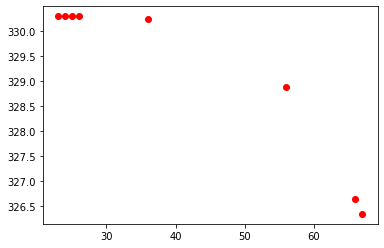

highHIIIIGHHHHHH:  273.0
rewaRD::  -92.88491210982845
returned state: [67.]
observation space:  (9,)
stepping:  6
ACTION            :  3
curtemp:  82.0
Temperature:  [23. 24. 25. 26. 36. 56. 66. 67. 82.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 332.93990763182654
chisqds:  0.07429952939341895
BUT ARE WE SURE?: 16.56084919995656


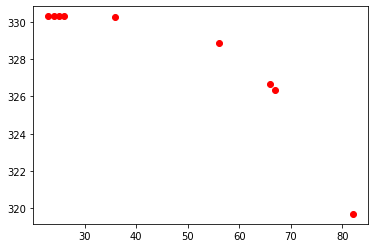

highHIIIIGHHHHHH:  258.0
rewaRD::  300
returned state: [82.]
observation space:  (10,)
stepping:  6
ACTION            :  4
curtemp:  102.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699 304.21754763]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 364.9569904110078
chisqds:  5.651595740823997
BUT ARE WE SURE?: 4.789075931121233e-09


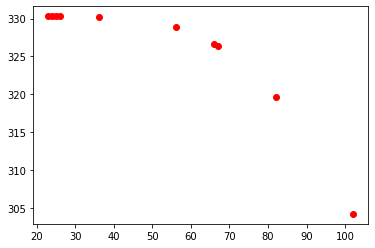

highHIIIIGHHHHHH:  238.0
rewaRD::  -29.22352936346428
returned state: [102.]
observation space:  (11,)
stepping:  6
ACTION            :  6
curtemp:  132.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699 304.21754763
 265.46782105]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 321.4267147803851
chisqds:  0.24113668263042382
BUT ARE WE SURE?: 5.231072378081425e-09


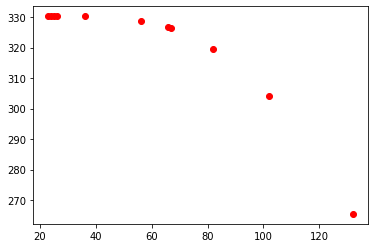

highHIIIIGHHHHHH:  208.0
rewaRD::  300
returned state: [132.]
observation space:  (12,)
stepping:  6
ACTION            :  4
curtemp:  152.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699 304.21754763
 265.46782105 228.86470104]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 1.9816605491209898
THE NF RESULT {X1}: 438.1903631744133
chisqds:  32.26501402934013
BUT ARE WE SURE?: 0.9747311493822289


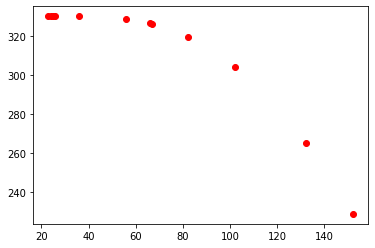

highHIIIIGHHHHHH:  188.0
rewaRD::  -87.60267081749102
returned state: [152.]
observation space:  (13,)
stepping:  6
ACTION            :  6
curtemp:  182.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699 304.21754763
 265.46782105 228.86470104 157.3319175 ]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 280.7450687514685
chisqds:  10.264741226772893
BUT ARE WE SURE?: 0.6168956543464739


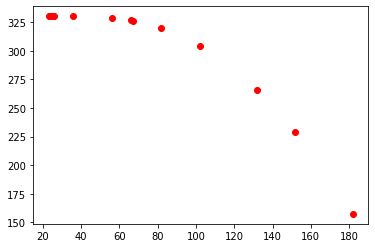

highHIIIIGHHHHHH:  158.0
rewaRD::  -61.031652804193
returned state: [182.]
observation space:  (14,)
stepping:  6
ACTION            :  5
curtemp:  207.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.]
Intensity:  [330.2997981  330.29962281 330.29932967 330.29886027 330.25451618
 328.88690081 326.64286094 326.33749394 319.70702699 304.21754763
 265.46782105 228.86470104 157.3319175   82.16142922]
ORDER PARAM RESULT (X2): 223.563834349082
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 327.3205384088061
chisqds:  0.2661781445271006
BUT ARE WE SURE?: 1.4034820287587406e-09


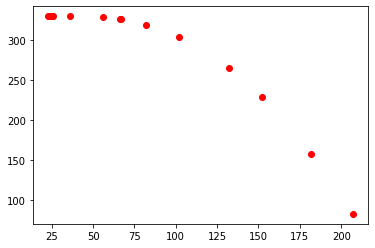

highHIIIIGHHHHHH:  133.0
rewaRD::  300
returned state: [207.]
observation space:  (15,)
stepping:  6
ACTION            :  5
curtemp:  232.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 211.22117568508148
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.3131769009162
chisqds:  4.473332944883478
BUT ARE WE SURE?: 8.967189355599015


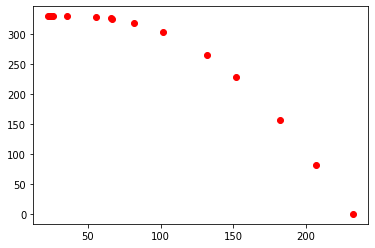

highHIIIIGHHHHHH:  108.0
rewaRD::  -10.58121429179262
returned state: [232.]
observation space:  (16,)
stepping:  6
ACTION            :  4
curtemp:  252.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 304.6301296986941
chisqds:  7.1693103993636615
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


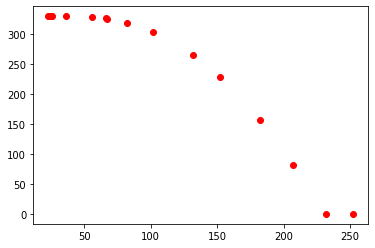

highHIIIIGHHHHHH:  88.0
rewaRD::  -44.20662829224084
returned state: [252.]
observation space:  (17,)
stepping:  6
ACTION            :  4
curtemp:  272.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 423.0767458018974
chisqds:  24.864244251905237
BUT ARE WE SURE?: 7.3167856737433e-09


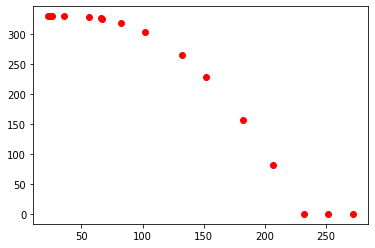

highHIIIIGHHHHHH:  68.0
rewaRD::  -83.91264194690535
returned state: [272.]
observation space:  (18,)
stepping:  6
ACTION            :  5
curtemp:  297.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272. 297.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 307.2650016635681
chisqds:  5.874011757135689
BUT ARE WE SURE?: 2.0070312706885906e-09


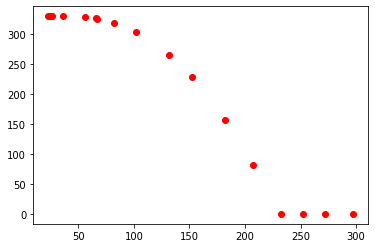

highHIIIIGHHHHHH:  43.0
rewaRD::  -31.903438988850482
returned state: [297.]
observation space:  (19,)
stepping:  6
ACTION            :  1
curtemp:  302.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272. 297. 302.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 292.05430670643983
chisqds:  12.854441226139521
BUT ARE WE SURE?: 0.7567996263968142


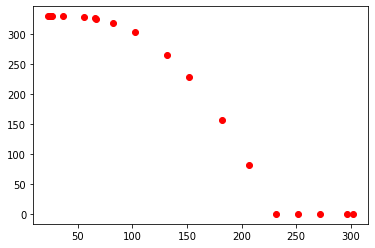

highHIIIIGHHHHHH:  38.0
rewaRD::  -68.88235023498342
returned state: [302.]
observation space:  (20,)
stepping:  6
ACTION            :  5
curtemp:  327.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272. 297. 302. 327.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 330.503259031119
chisqds:  3.7890816997032375
BUT ARE WE SURE?: 2.625024649634935e-09


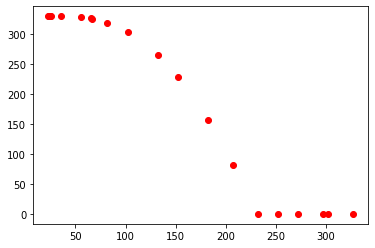

highHIIIIGHHHHHH:  13.0
rewaRD::  5.566475389361017
returned state: [327.]
observation space:  (21,)
stepping:  6
ACTION            :  2
curtemp:  337.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272. 297. 302. 327. 337.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3.26337494e+02
 3.19707027e+02 3.04217548e+02 2.65467821e+02 2.28864701e+02
 1.57331918e+02 8.21614292e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 309.90363907666404
chisqds:  4.639041814538949
BUT ARE WE SURE?: 8.885840807077434e-10


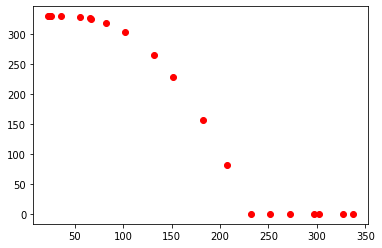

highHIIIIGHHHHHH:  3.0
rewaRD::  -13.77529757408449
returned state: [337.]
observation space:  (22,)
---------------------------------------
| approxkl           | 5.745553e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 17.7           |
| ep_reward_mean     | -864           |
| explained_variance | -5.13e-05      |
| fps                | 0              |
| n_updates          | 1              |
| policy_entropy     | 1.9458119      |
| policy_loss        | -0.00092442357 |
| serial_timesteps   | 128            |
| time_elapsed       | 6.13e-05       |
| total_timesteps    | 128            |
| value_loss         | 121004.18      |
---------------------------------------
stepping:  6
ACTION            :  6
curtemp:  367.0
Temperature:  [ 23.  24.  25.  26.  36.  56.  66.  67.  82. 102. 132. 152. 182. 207.
 232. 252. 272. 297. 302. 327. 337. 367.]
Intensity:  [3.30299798e+02 3.30299623e+02 3.30299330e+02 3.30298860e+02
 3.30254516e+02 3.28886901e+02 3.26642861e+02 3

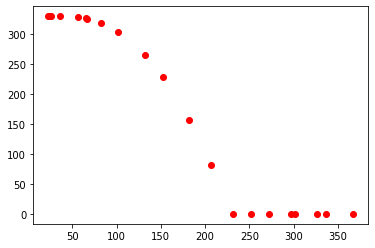

highHIIIIGHHHHHH:  -27.0
rewaRD::  -48.65422440111
terminated: over max temp
returned state: [367.]
observation space:  (23,)
reset
fixed Tn:  70
fixed Jt:  0.9
fixed Nf:  330
stepping:  7
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  7
ACTION            :  5
curtemp:  43.0
Temperature:  [18. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
returned state: [43.]
observation space:  (3,)
stepping:  7
ACTION            :  0
curtemp:  44.0
Temperature:  [18. 43. 44.]
highHIIIIGHHHHHH:  296.0
rewaRD::  -100
returned state: [44.]
observation space:  (4,)
stepping:  7
ACTION            :  4
curtemp:  64.0
Temperature:  [18. 43. 44. 64.]
Intensity:  [328.69499751 252.69216166 246.63930341  72.60152549]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 316.31443373957285
chisqds:  221.95093507325555
BUT ARE WE SURE?: 28963231.288633037


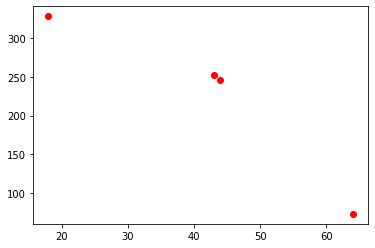

highHIIIIGHHHHHH:  276.0
rewaRD::  -98.19779988821412
returned state: [64.]
observation space:  (5,)
stepping:  7
ACTION            :  6
curtemp:  94.0
Temperature:  [18. 43. 44. 64. 94.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.86661693848924
chisqds:  103.89896693652841
BUT ARE WE SURE?: 3.1901748696161422e-09


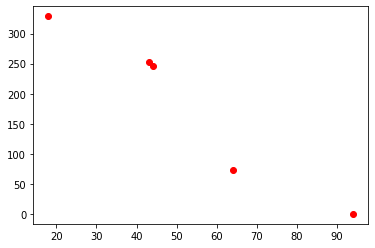

highHIIIIGHHHHHH:  246.0
rewaRD::  -96.15010609061822
returned state: [94.]
observation space:  (6,)
stepping:  7
ACTION            :  4
curtemp:  114.0
Temperature:  [ 18.  43.  44.  64.  94. 114.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 365.0856568722956
chisqds:  62.8992721183516
BUT ARE WE SURE?: 3.5024707598414384e-09


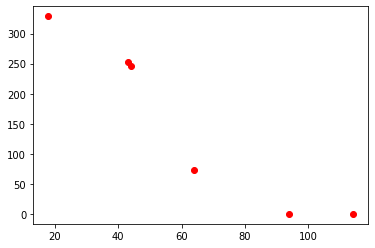

highHIIIIGHHHHHH:  226.0
rewaRD::  -93.64062593208777
returned state: [114.]
observation space:  (7,)
stepping:  7
ACTION            :  6
curtemp:  144.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 358.38524134953127
chisqds:  48.035482699389135
BUT ARE WE SURE?: 3.772585374326171e-10


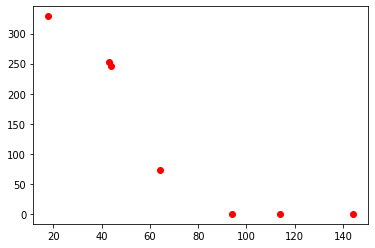

highHIIIIGHHHHHH:  196.0
rewaRD::  -91.67282230714241
returned state: [144.]
observation space:  (8,)
stepping:  7
ACTION            :  6
curtemp:  174.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 380.98330100360573
chisqds:  36.39182279306586
BUT ARE WE SURE?: 4.089064117313918e-09


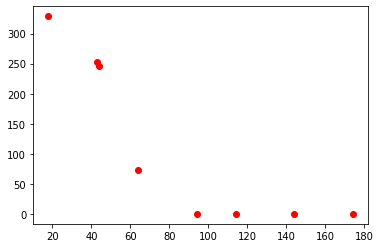

highHIIIIGHHHHHH:  166.0
rewaRD::  -89.00851979098402
returned state: [174.]
observation space:  (9,)
stepping:  7
ACTION            :  5
curtemp:  199.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.2568629771748
chisqds:  34.58519857480817
BUT ARE WE SURE?: 5.522959920134856


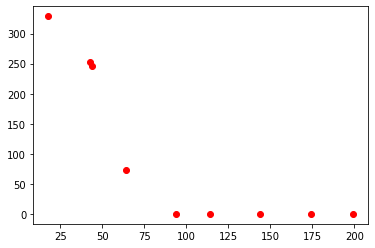

highHIIIIGHHHHHH:  141.0
rewaRD::  -88.4343587290732
returned state: [199.]
observation space:  (10,)
stepping:  7
ACTION            :  6
curtemp:  229.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 383.39269516543976
chisqds:  25.8733929983313
BUT ARE WE SURE?: 4.970875214997093e-09


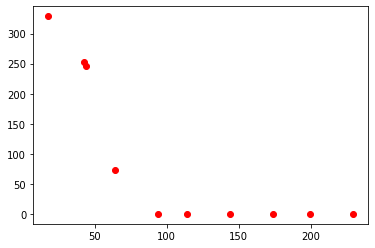

highHIIIIGHHHHHH:  111.0
rewaRD::  -84.54010264421841
returned state: [229.]
observation space:  (11,)
stepping:  7
ACTION            :  5
curtemp:  254.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 362.288570833001
chisqds:  23.76150167751942
BUT ARE WE SURE?: 4.228706520282117e-10


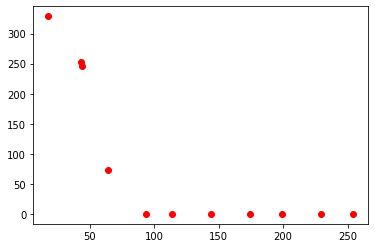

highHIIIIGHHHHHH:  86.0
rewaRD::  -83.16604710305674
returned state: [254.]
observation space:  (12,)
stepping:  7
ACTION            :  5
curtemp:  279.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254. 279.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 297.53861891631504
chisqds:  26.645685422777845
BUT ARE WE SURE?: 3.7709783070983814e-10


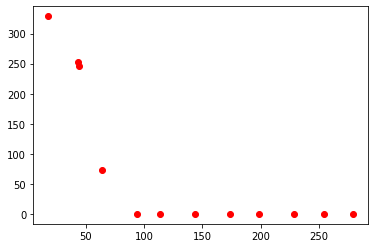

highHIIIIGHHHHHH:  61.0
rewaRD::  -84.98818875726637
returned state: [279.]
observation space:  (13,)
stepping:  7
ACTION            :  5
curtemp:  304.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254. 279. 304.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 368.9450800976829
chisqds:  18.687656942165003
BUT ARE WE SURE?: 6.0077835663357025e-09


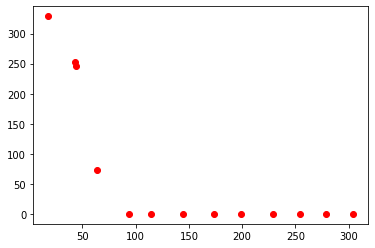

highHIIIIGHHHHHH:  36.0
rewaRD::  -78.5954974859647
returned state: [304.]
observation space:  (14,)
stepping:  7
ACTION            :  5
curtemp:  329.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254. 279. 304. 329.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 291.2268347391425
chisqds:  22.40425000065351
BUT ARE WE SURE?: 6.516595202227454e-09


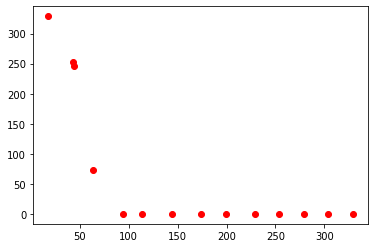

highHIIIIGHHHHHH:  11.0
rewaRD::  -82.14624457465291
returned state: [329.]
observation space:  (15,)
stepping:  7
ACTION            :  2
curtemp:  339.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254. 279. 304. 329.
 339.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 361.88496021000043
chisqds:  15.858195352532576
BUT ARE WE SURE?: 6.522385712881143e-09


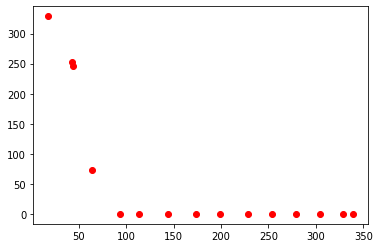

highHIIIIGHHHHHH:  1.0
rewaRD::  -74.77644895223722
returned state: [339.]
observation space:  (16,)
stepping:  7
ACTION            :  4
curtemp:  359.0
Temperature:  [ 18.  43.  44.  64.  94. 114. 144. 174. 199. 229. 254. 279. 304. 329.
 339. 359.]
Intensity:  [3.28694998e+02 2.52692162e+02 2.46639303e+02 7.26015255e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 369.00273704564205
chisqds:  14.37309708783607
BUT ARE WE SURE?: 7.42735519726885e-09


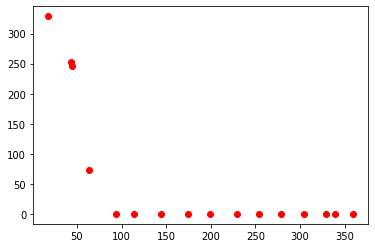

highHIIIIGHHHHHH:  -19.0
rewaRD::  -72.17022903584785
terminated: over max temp
returned state: [359.]
observation space:  (17,)
reset
fixed Tn:  180
fixed Jt:  0.8
fixed Nf:  330
stepping:  8
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
returned state: [8.]
observation space:  (2,)
stepping:  8
ACTION            :  5
curtemp:  33.0
Temperature:  [ 8. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (3,)
stepping:  8
ACTION            :  3
curtemp:  48.0
Temperature:  [ 8. 33. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
returned state: [48.]
observation space:  (4,)
stepping:  8
ACTION            :  4
curtemp:  68.0
Temperature:  [ 8. 33. 48. 68.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 298.83904591074565
chisqds:  11.66084277032413
BUT ARE WE SURE?: 8.325147638619368e-10


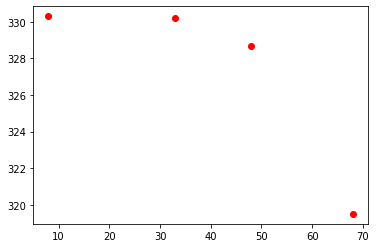

highHIIIIGHHHHHH:  272.0
rewaRD::  -65.69716204235542
returned state: [68.]
observation space:  (5,)
stepping:  8
ACTION            :  4
curtemp:  88.0
Temperature:  [ 8. 33. 48. 68. 88.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 317.26431872140313
chisqds:  1.4623444559746013
BUT ARE WE SURE?: 2.855181467881041e-09


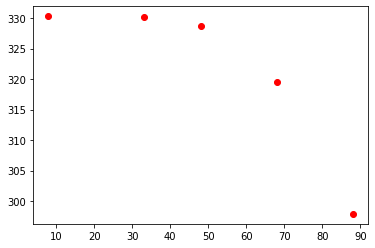

highHIIIIGHHHHHH:  252.0
rewaRD::  173.5333651150023
returned state: [88.]
observation space:  (6,)
stepping:  8
ACTION            :  2
curtemp:  98.0
Temperature:  [ 8. 33. 48. 68. 88. 98.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405
 281.70115481]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 336.6332100141504
chisqds:  0.21272121612161743
BUT ARE WE SURE?: 3.3337197155371368e-09


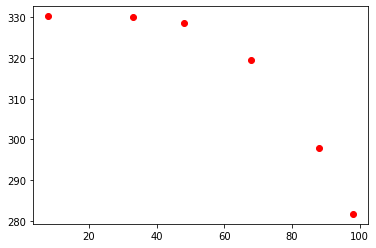

highHIIIIGHHHHHH:  242.0
rewaRD::  300
returned state: [98.]
observation space:  (7,)
stepping:  8
ACTION            :  2
curtemp:  108.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405
 281.70115481 261.7270788 ]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 291.8290969945806
chisqds:  24.748814562296456
BUT ARE WE SURE?: 2.322788267833501


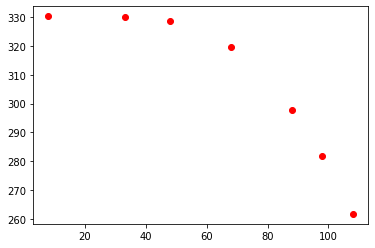

highHIIIIGHHHHHH:  232.0
rewaRD::  -83.83760971689613
returned state: [108.]
observation space:  (8,)
stepping:  8
ACTION            :  3
curtemp:  123.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405
 281.70115481 261.7270788  224.47778402]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 328.5588372610482
chisqds:  1.490612027763998
BUT ARE WE SURE?: 2.175628962456776e-09


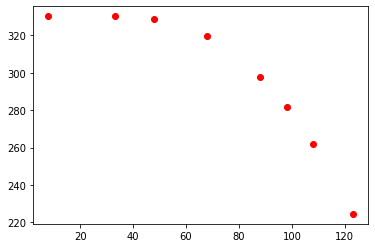

highHIIIIGHHHHHH:  217.0
rewaRD::  168.34615080895497
returned state: [123.]
observation space:  (9,)
stepping:  8
ACTION            :  3
curtemp:  138.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405
 281.70115481 261.7270788  224.47778402 178.29423823]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 290.1649682416184
chisqds:  13.521902129164104
BUT ARE WE SURE?: 0.6218261578842769


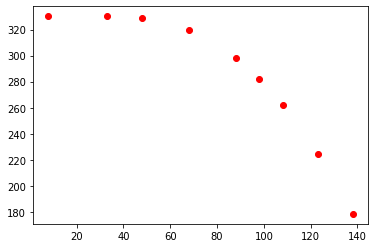

highHIIIIGHHHHHH:  202.0
rewaRD::  -70.41836302473466
returned state: [138.]
observation space:  (10,)
stepping:  8
ACTION            :  5
curtemp:  163.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163.]
Intensity:  [330.3        330.20691129 328.68175901 319.50883418 297.89218405
 281.70115481 261.7270788  224.47778402 178.29423823  81.07214931]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 358.6897255512671
chisqds:  14.853174954629795
BUT ARE WE SURE?: 5.132719909584149e-09


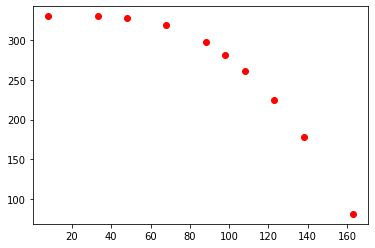

highHIIIIGHHHHHH:  177.0
rewaRD::  -73.06973080019377
returned state: [163.]
observation space:  (11,)
stepping:  8
ACTION            :  6
curtemp:  193.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.9777008665357
chisqds:  12.964207436387664
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


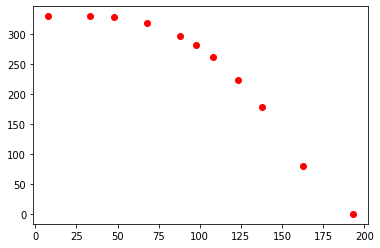

highHIIIIGHHHHHH:  147.0
rewaRD::  -69.14581921319089
returned state: [193.]
observation space:  (12,)
stepping:  8
ACTION            :  1
curtemp:  198.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40015744932357306
THE NF RESULT {X1}: 329.6797854890981
chisqds:  11.544595772507769
BUT ARE WE SURE?: 0.3363761078206597


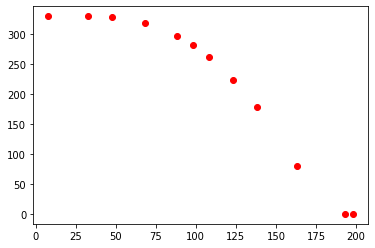

highHIIIIGHHHHHH:  142.0
rewaRD::  -65.35175350595145
returned state: [198.]
observation space:  (13,)
stepping:  8
ACTION            :  0
curtemp:  199.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 319.5390180839279
chisqds:  11.234551663785854
BUT ARE WE SURE?: 4.1204605555174575e-10


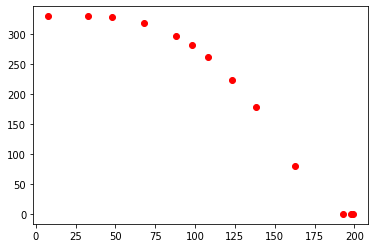

highHIIIIGHHHHHH:  141.0
rewaRD::  -64.39555293609226
returned state: [199.]
observation space:  (14,)
stepping:  8
ACTION            :  0
curtemp:  200.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.4749310013825
chisqds:  9.260214562263677
BUT ARE WE SURE?: 0.5410666607439789


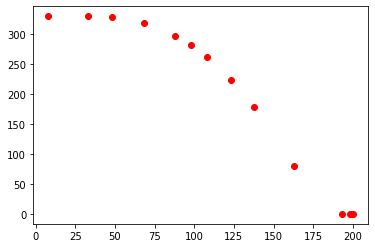

highHIIIIGHHHHHH:  140.0
rewaRD::  -56.80445660189765
returned state: [200.]
observation space:  (15,)
stepping:  8
ACTION            :  4
curtemp:  220.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.83035320352934
chisqds:  8.440440600320269
BUT ARE WE SURE?: 6.928072524434954e-09


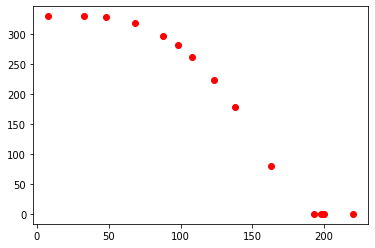

highHIIIIGHHHHHH:  120.0
rewaRD::  -52.609109057076694
returned state: [220.]
observation space:  (16,)
stepping:  8
ACTION            :  6
curtemp:  250.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.1186967365264
chisqds:  7.78251110407479
BUT ARE WE SURE?: 7.285313530335798e-09


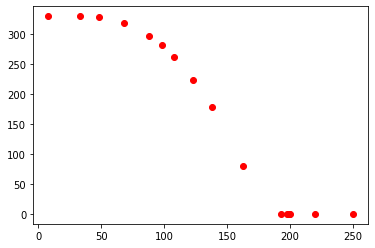

highHIIIIGHHHHHH:  90.0
rewaRD::  -48.602707448683645
returned state: [250.]
observation space:  (17,)
stepping:  8
ACTION            :  2
curtemp:  260.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.51851972748204
chisqds:  7.215880440941907
BUT ARE WE SURE?: 50516440.16160358


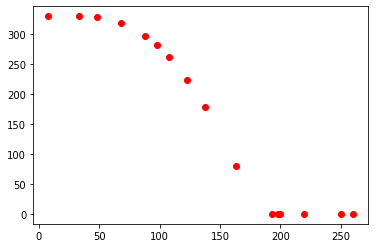

highHIIIIGHHHHHH:  80.0
rewaRD::  -44.56670904212113
returned state: [260.]
observation space:  (18,)
stepping:  8
ACTION            :  1
curtemp:  265.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.712989412159
chisqds:  6.730112039975423
BUT ARE WE SURE?: 8.146739706599389e-09


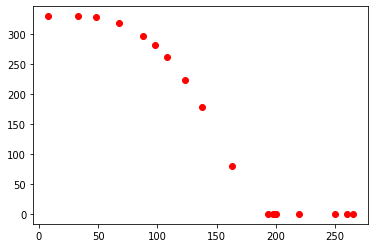

highHIIIIGHHHHHH:  75.0
rewaRD::  -40.56562541246183
returned state: [265.]
observation space:  (19,)
stepping:  8
ACTION            :  6
curtemp:  295.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.7086849017953
chisqds:  6.309576677144737
BUT ARE WE SURE?: 8.19707539816923e-09


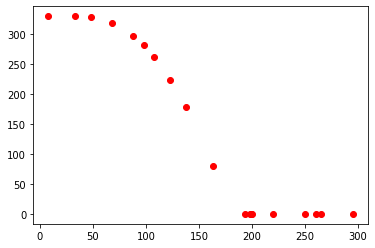

highHIIIIGHHHHHH:  45.0
rewaRD::  -36.604304778650956
returned state: [295.]
observation space:  (20,)
stepping:  8
ACTION            :  0
curtemp:  296.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.86959563163236
chisqds:  5.9350566884481575
BUT ARE WE SURE?: 8.346916808434241e-09


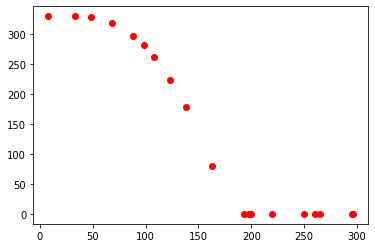

highHIIIIGHHHHHH:  44.0
rewaRD::  -32.60384508566703
returned state: [296.]
observation space:  (21,)
stepping:  8
ACTION            :  0
curtemp:  297.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.60331996930023
chisqds:  5.610628998547722
BUT ARE WE SURE?: 9.350197545597432e-09


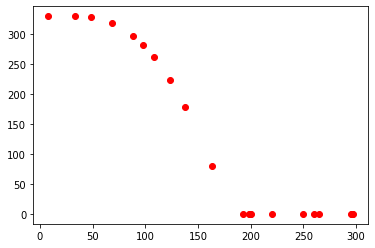

highHIIIIGHHHHHH:  43.0
rewaRD::  -28.70674569579674
returned state: [297.]
observation space:  (22,)
stepping:  8
ACTION            :  1
curtemp:  302.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297. 302.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.64533254910515
chisqds:  5.314530279923982
BUT ARE WE SURE?: 9.026864542496128e-09


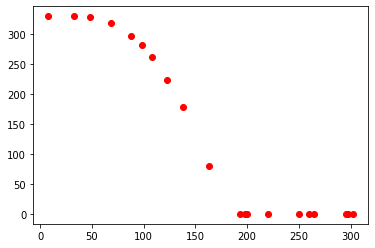

highHIIIIGHHHHHH:  38.0
rewaRD::  -24.734646538560796
returned state: [302.]
observation space:  (23,)
stepping:  8
ACTION            :  1
curtemp:  307.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297. 302. 307.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.921678789818
chisqds:  5.043883289153505
BUT ARE WE SURE?: 9.45691517327021e-09


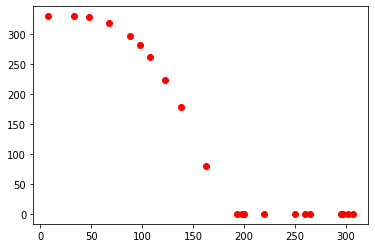

highHIIIIGHHHHHH:  33.0
rewaRD::  -20.696023863167056
returned state: [307.]
observation space:  (24,)
stepping:  8
ACTION            :  1
curtemp:  312.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297. 302. 307. 312.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.98987922513595
chisqds:  4.861330117785775
BUT ARE WE SURE?: 1.0253961519641819e-08


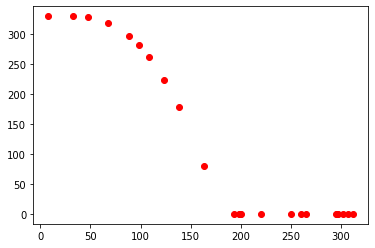

highHIIIIGHHHHHH:  28.0
rewaRD::  -17.71799274923734
returned state: [312.]
observation space:  (25,)
stepping:  8
ACTION            :  5
curtemp:  337.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297. 302. 307. 312. 337.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 336.134457994708
chisqds:  4.582005237344065
BUT ARE WE SURE?: 1.0896694828180101e-08


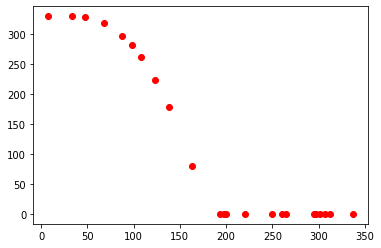

highHIIIIGHHHHHH:  3.0
rewaRD::  -12.701976693536494
returned state: [337.]
observation space:  (26,)
stepping:  8
ACTION            :  4
curtemp:  357.0
Temperature:  [  8.  33.  48.  68.  88.  98. 108. 123. 138. 163. 193. 198. 199. 200.
 220. 250. 260. 265. 295. 296. 297. 302. 307. 312. 337. 357.]
Intensity:  [3.30300000e+02 3.30206911e+02 3.28681759e+02 3.19508834e+02
 2.97892184e+02 2.81701155e+02 2.61727079e+02 2.24477784e+02
 1.78294238e+02 8.10721493e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.48725036369615
chisqds:  4.428554865965339
BUT ARE WE SURE?: 1.1107877408214338e-08


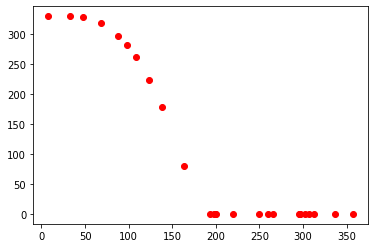

highHIIIIGHHHHHH:  -17.0
rewaRD::  -9.677081552244061
terminated: over max temp
returned state: [357.]
observation space:  (27,)
reset
fixed Tn:  180
fixed Jt:  1.0
fixed Nf:  330
stepping:  9
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  9
ACTION            :  2
curtemp:  33.0
Temperature:  [23. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (3,)
stepping:  9
ACTION            :  3
curtemp:  48.0
Temperature:  [23. 33. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
returned state: [48.]
observation space:  (4,)
stepping:  9
ACTION            :  1
curtemp:  53.0
Temperature:  [23. 33. 48. 53.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 214.93796152354366
chisqds:  158.21070832255535
BUT ARE WE SURE?: 2.8915506039735645e-10


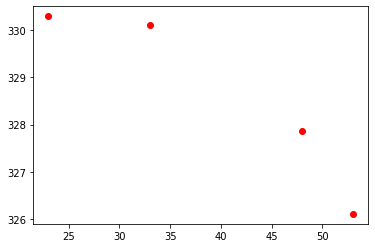

highHIIIIGHHHHHH:  287.0
rewaRD::  -97.47172612877448
returned state: [53.]
observation space:  (5,)
stepping:  9
ACTION            :  1
curtemp:  58.0
Temperature:  [23. 33. 48. 53. 58.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 323.8285762224381
chisqds:  0.20808295974512342
BUT ARE WE SURE?: 2.6390183752768057e-10


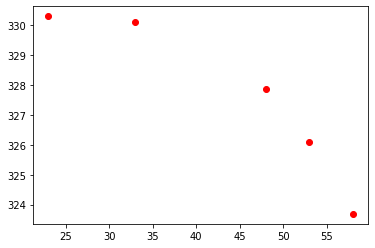

highHIIIIGHHHHHH:  282.0
rewaRD::  300
returned state: [58.]
observation space:  (6,)
stepping:  9
ACTION            :  4
curtemp:  78.0
Temperature:  [23. 33. 48. 53. 58. 78.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 279.96996720379724
chisqds:  14.315468469009025
BUT ARE WE SURE?: 3.486499130459998e-09


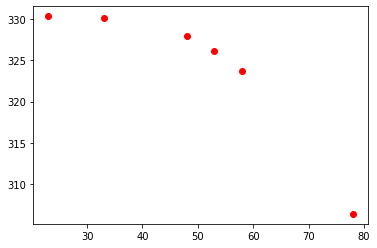

highHIIIIGHHHHHH:  262.0
rewaRD::  -72.05819698699042
returned state: [78.]
observation space:  (7,)
stepping:  9
ACTION            :  4
curtemp:  98.0
Temperature:  [23. 33. 48. 53. 58. 78. 98.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.7070949020529
chisqds:  0.15666061310512164
BUT ARE WE SURE?: 3.6151800036393787e-09


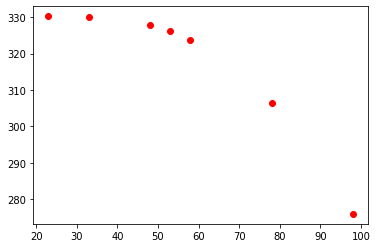

highHIIIIGHHHHHH:  242.0
rewaRD::  300
returned state: [98.]
observation space:  (8,)
stepping:  9
ACTION            :  5
curtemp:  123.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572 217.97848462]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 274.22241273307907
chisqds:  15.834842555131612
BUT ARE WE SURE?: 1.165652612161649


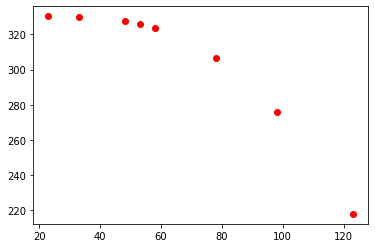

highHIIIIGHHHHHH:  217.0
rewaRD::  -74.73924994155553
returned state: [123.]
observation space:  (9,)
stepping:  9
ACTION            :  5
curtemp:  148.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572 217.97848462 137.40240009]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.2859677367168
chisqds:  29.67103673715148
BUT ARE WE SURE?: 1.4117652190021484e-10


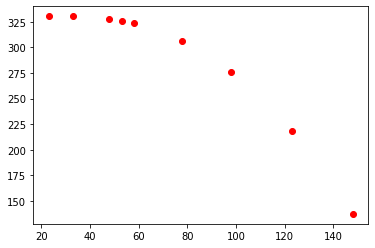

highHIIIIGHHHHHH:  192.0
rewaRD::  -86.51883978495584
returned state: [148.]
observation space:  (10,)
stepping:  9
ACTION            :  0
curtemp:  149.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572 217.97848462 137.40240009 133.6993792 ]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 306.83220713474833
chisqds:  13.357487639076554
BUT ARE WE SURE?: 0.4960112119627522


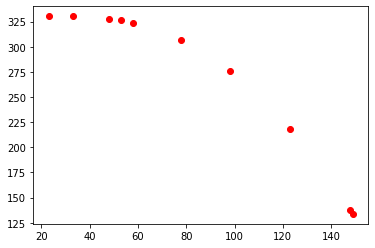

highHIIIIGHHHHHH:  191.0
rewaRD::  -70.05424891206164
returned state: [149.]
observation space:  (11,)
stepping:  9
ACTION            :  0
curtemp:  150.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572 217.97848462 137.40240009 133.6993792
 129.9591366 ]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 407.15631686782234
chisqds:  23.07982627269984
BUT ARE WE SURE?: 5.390677458150509e-10


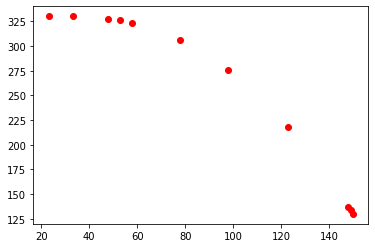

highHIIIIGHHHHHH:  190.0
rewaRD::  -82.66884701497328
returned state: [150.]
observation space:  (12,)
stepping:  9
ACTION            :  5
curtemp:  175.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175.]
Intensity:  [330.29473563 330.11495276 327.86529011 326.10702511 323.68986415
 306.43960071 275.89811572 217.97848462 137.40240009 133.6993792
 129.9591366   24.26957473]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 329.96593062165556
chisqds:  14.394783199077924
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


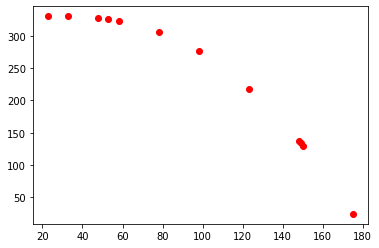

highHIIIIGHHHHHH:  165.0
rewaRD::  -72.21215530181638
returned state: [175.]
observation space:  (13,)
stepping:  9
ACTION            :  3
curtemp:  190.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.29259002832435
chisqds:  12.73439555089061
BUT ARE WE SURE?: 6.367091259377618e-09


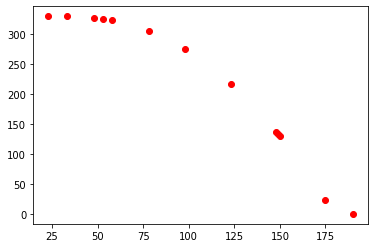

highHIIIIGHHHHHH:  150.0
rewaRD::  -68.5890077466594
returned state: [190.]
observation space:  (14,)
stepping:  9
ACTION            :  5
curtemp:  215.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 369.5141934618637
chisqds:  12.359751524929349
BUT ARE WE SURE?: 6.319624549730407e-09


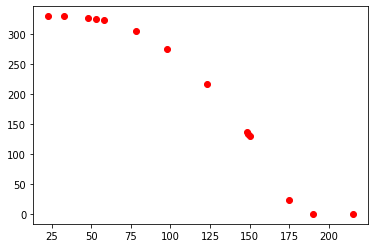

highHIIIIGHHHHHH:  125.0
rewaRD::  -67.63688985225886
returned state: [215.]
observation space:  (15,)
stepping:  9
ACTION            :  2
curtemp:  225.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 329.8334786724329
chisqds:  10.804287704580771
BUT ARE WE SURE?: 904060489.951754


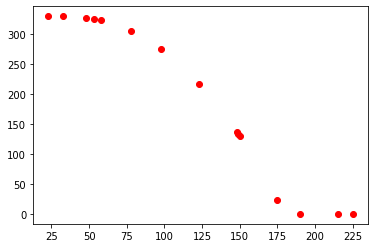

highHIIIIGHHHHHH:  115.0
rewaRD::  -62.977661189972835
returned state: [225.]
observation space:  (16,)
stepping:  9
ACTION            :  5
curtemp:  250.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 329.8593469265549
chisqds:  9.97170546597624
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


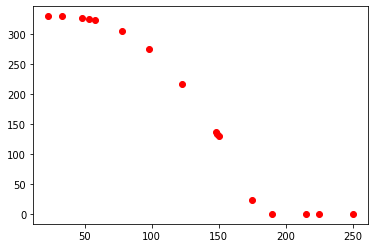

highHIIIIGHHHHHH:  90.0
rewaRD::  -59.88650072298946
returned state: [250.]
observation space:  (17,)
stepping:  9
ACTION            :  5
curtemp:  275.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250. 275.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 354.3302215502729
chisqds:  8.933018199892514
BUT ARE WE SURE?: 1.577158764823253e-08


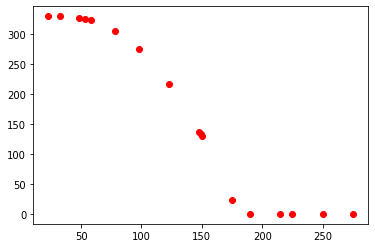

highHIIIIGHHHHHH:  65.0
rewaRD::  -55.2223010130201
returned state: [275.]
observation space:  (18,)
stepping:  9
ACTION            :  6
curtemp:  305.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250. 275. 305.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 297.9059322640414
chisqds:  11.780907106268396
BUT ARE WE SURE?: 5.332014605656859e-10


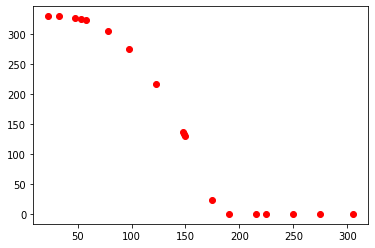

highHIIIIGHHHHHH:  35.0
rewaRD::  -66.04675714765906
returned state: [305.]
observation space:  (19,)
stepping:  9
ACTION            :  0
curtemp:  306.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250. 275. 305. 306.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 298.37961653493244
chisqds:  10.979726428049002
BUT ARE WE SURE?: 5.057929737510174e-10


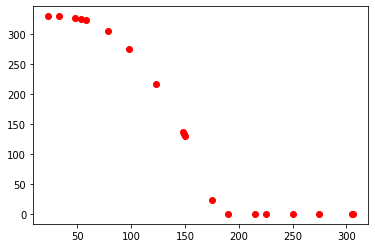

highHIIIIGHHHHHH:  34.0
rewaRD::  -63.569219814243006
returned state: [306.]
observation space:  (20,)
stepping:  9
ACTION            :  5
curtemp:  331.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250. 275. 305. 306. 331.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 178.9761429489618
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 321.8855937212171
chisqds:  0.24936829362415552
BUT ARE WE SURE?: 5.406516955824026e-10


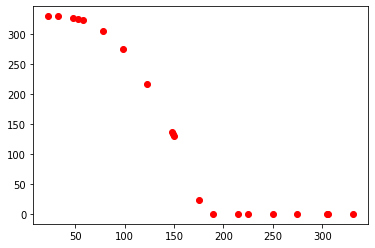

highHIIIIGHHHHHH:  9.0
rewaRD::  300
returned state: [331.]
observation space:  (21,)
stepping:  9
ACTION            :  4
curtemp:  351.0
Temperature:  [ 23.  33.  48.  53.  58.  78.  98. 123. 148. 149. 150. 175. 190. 215.
 225. 250. 275. 305. 306. 331. 351.]
Intensity:  [3.30294736e+02 3.30114953e+02 3.27865290e+02 3.26107025e+02
 3.23689864e+02 3.06439601e+02 2.75898116e+02 2.17978485e+02
 1.37402400e+02 1.33699379e+02 1.29959137e+02 2.42695747e+01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 310.23133955091595
chisqds:  8.502004521985628
BUT ARE WE SURE?: 8.362034815539114e-10


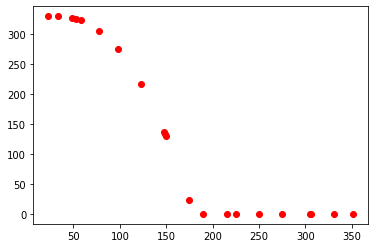

highHIIIIGHHHHHH:  -11.0
rewaRD::  -52.952271553652295
terminated: over max temp
returned state: [351.]
observation space:  (22,)
reset
fixed Tn:  290
fixed Jt:  1.0
fixed Nf:  330
stepping:  10
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  10
ACTION            :  0
curtemp:  19.0
Temperature:  [18. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
returned state: [19.]
observation space:  (3,)
stepping:  10
ACTION            :  5
curtemp:  44.0
Temperature:  [18. 19. 44.]
highHIIIIGHHHHHH:  296.0
rewaRD::  -100
returned state: [44.]
observation space:  (4,)
stepping:  10
ACTION            :  5
curtemp:  69.0
Temperature:  [18. 19. 44. 69.]
Intensity:  [330.29999998 330.29999992 330.2664123  329.07799899]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 389.658846953776
chisqds:  43.437506305362085
BUT ARE WE SURE?: 4242.0770825988


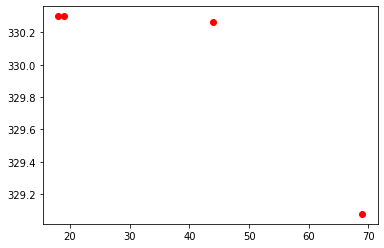

highHIIIIGHHHHHH:  271.0
rewaRD::  -90.79136824319441
returned state: [69.]
observation space:  (5,)
stepping:  10
ACTION            :  0
curtemp:  70.0
Temperature:  [18. 19. 44. 69. 70.]
Intensity:  [330.29999998 330.29999992 330.2664123  329.07799899 328.96147244]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 369.24704793410035
chisqds:  11.880840604803119
BUT ARE WE SURE?: 1622.142318283799


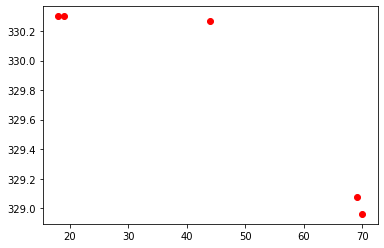

highHIIIIGHHHHHH:  270.0
rewaRD::  -66.33234858497383
returned state: [70.]
observation space:  (6,)
stepping:  10
ACTION            :  3
curtemp:  85.0
Temperature:  [18. 19. 44. 69. 70. 85.]
Intensity:  [330.29999998 330.29999992 330.2664123  329.07799899 328.96147244
 326.20647499]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4284697685798709
THE NF RESULT {X1}: 325.0439418934165
chisqds:  0.11641161850631239
BUT ARE WE SURE?: 77.40220673883694


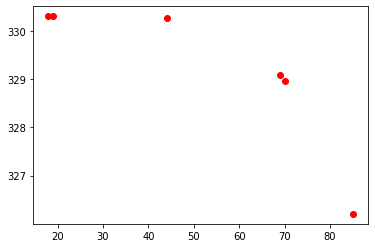

highHIIIIGHHHHHH:  255.0
rewaRD::  300
returned state: [85.]
observation space:  (7,)
stepping:  10
ACTION            :  0
curtemp:  86.0
Temperature:  [18. 19. 44. 69. 70. 85. 86.]
Intensity:  [330.29999998 330.29999992 330.2664123  329.07799899 328.96147244
 326.20647499 325.9476329 ]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 323.72068304183153
chisqds:  0.15727907209629535
BUT ARE WE SURE?: 76.93567654573273


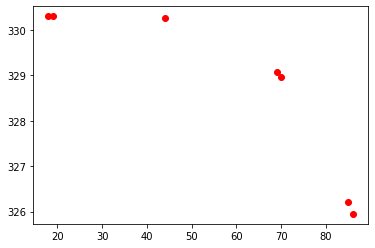

highHIIIIGHHHHHH:  254.0
rewaRD::  300
returned state: [86.]
observation space:  (8,)
stepping:  10
ACTION            :  2
curtemp:  96.0
Temperature:  [18. 19. 44. 69. 70. 85. 86. 96.]
Intensity:  [330.29999998 330.29999992 330.2664123  329.07799899 328.96147244
 326.20647499 325.9476329  322.77504241]
ORDER PARAM RESULT (X2): 270.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 330.8802910759307
chisqds:  0.029167724606907353
BUT ARE WE SURE?: 1.8562400165627408e-09


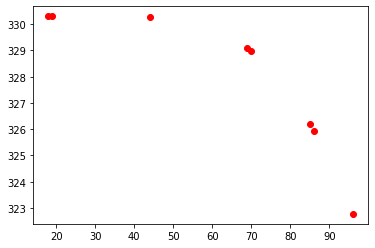

highHIIIIGHHHHHH:  244.0
rewaRD::  300
terminated: excellent conditions
returned state: [96.]
observation space:  (9,)
reset
fixed Tn:  180
fixed Jt:  1.2
fixed Nf:  330
stepping:  11
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
returned state: [8.]
observation space:  (2,)
stepping:  11
ACTION            :  1
curtemp:  13.0
Temperature:  [ 8. 13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
returned state: [13.]
observation space:  (3,)
stepping:  11
ACTION            :  4
curtemp:  33.0
Temperature:  [ 8. 13. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (4,)
stepping:  11
ACTION            :  1
curtemp:  38.0
Temperature:  [ 8. 13. 33. 38.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 380.1454210912069
chisqds:  30.756666275980947
BUT ARE WE SURE?: 984.4431006410877


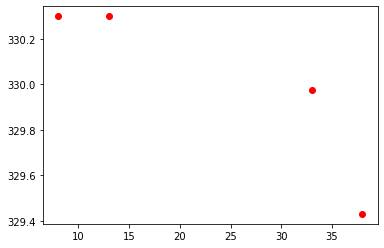

highHIIIIGHHHHHH:  302.0
rewaRD::  -86.99468933301216
returned state: [38.]
observation space:  (5,)
stepping:  11
ACTION            :  2
curtemp:  48.0
Temperature:  [ 8. 13. 33. 38. 48.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 310.51314557221065
chisqds:  2.704145631161781
BUT ARE WE SURE?: 8.802553213116675e-11


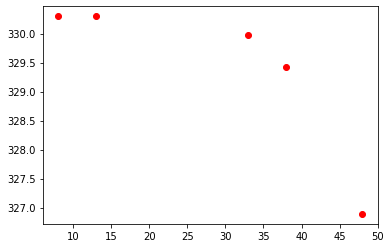

highHIIIIGHHHHHH:  292.0
rewaRD::  47.921027399751466
returned state: [48.]
observation space:  (6,)
stepping:  11
ACTION            :  5
curtemp:  73.0
Temperature:  [ 8. 13. 33. 38. 48. 73.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652
 308.50333629]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 273.78546460824333
chisqds:  18.08488142684318
BUT ARE WE SURE?: 3.47297013695425e-09


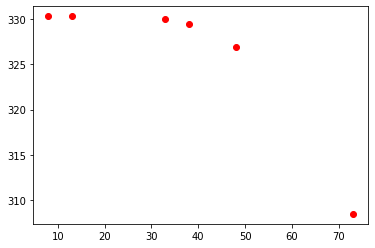

highHIIIIGHHHHHH:  267.0
rewaRD::  -77.88207782184932
returned state: [73.]
observation space:  (7,)
stepping:  11
ACTION            :  1
curtemp:  78.0
Temperature:  [ 8. 13. 33. 38. 48. 73. 78.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652
 308.50333629 302.50442908]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 258.15435054737964
chisqds:  25.519676319749266
BUT ARE WE SURE?: 3.6489089437859393e-09


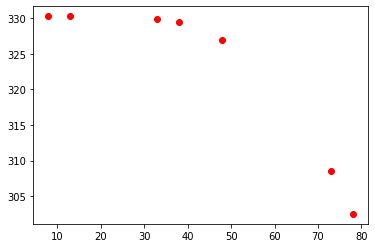

highHIIIIGHHHHHH:  262.0
rewaRD::  -84.32582000695493
returned state: [78.]
observation space:  (8,)
stepping:  11
ACTION            :  6
curtemp:  108.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652
 308.50333629 302.50442908 249.65206776]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 311.38570088591405
chisqds:  1.4909179789221534
BUT ARE WE SURE?: 2.553547999362581e-10


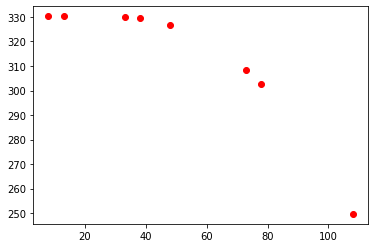

highHIIIIGHHHHHH:  232.0
rewaRD::  168.29108351699983
returned state: [108.]
observation space:  (9,)
stepping:  11
ACTION            :  6
curtemp:  138.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652
 308.50333629 302.50442908 249.65206776 167.26221016]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 443.13295799772845
chisqds:  50.36898354125745
BUT ARE WE SURE?: 36867132.01876891


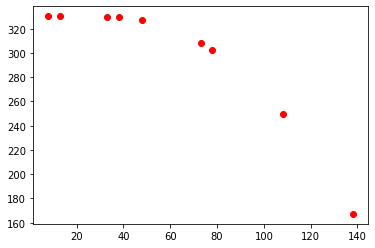

highHIIIIGHHHHHH:  202.0
rewaRD::  -92.05860488186428
returned state: [138.]
observation space:  (10,)
stepping:  11
ACTION            :  6
curtemp:  168.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168.]
Intensity:  [330.3        330.29999653 329.97505226 329.43062194 326.89124652
 308.50333629 302.50442908 249.65206776 167.26221016  54.2780865 ]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 408.22709310945027
chisqds:  28.672001409890637
BUT ARE WE SURE?: 2.3151794660437e-09


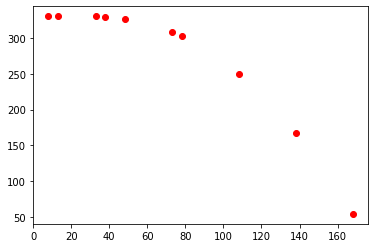

highHIIIIGHHHHHH:  172.0
rewaRD::  -86.04910782886552
returned state: [168.]
observation space:  (11,)
stepping:  11
ACTION            :  3
curtemp:  183.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 233.030394645121
chisqds:  38.044095751429815
BUT ARE WE SURE?: 325711200.7684789


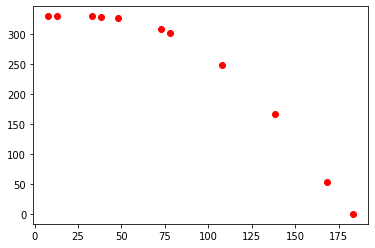

highHIIIIGHHHHHH:  157.0
rewaRD::  -89.48588494221296
returned state: [183.]
observation space:  (12,)
stepping:  11
ACTION            :  6
curtemp:  213.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 385.84377962913914
chisqds:  12.92860683165854
BUT ARE WE SURE?: 0.8693011846249558


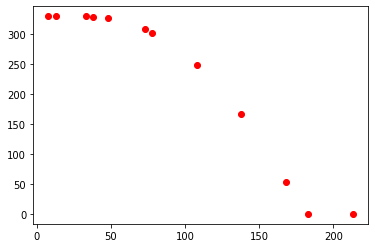

highHIIIIGHHHHHH:  127.0
rewaRD::  -69.0608582031815
returned state: [213.]
observation space:  (13,)
stepping:  11
ACTION            :  5
curtemp:  238.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 300.4627969413852
chisqds:  9.02250041478807
BUT ARE WE SURE?: 1.1528345806589087e-09


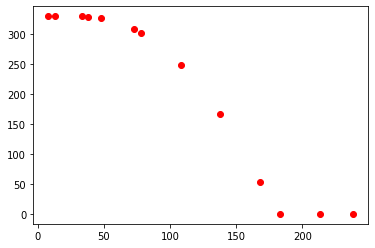

highHIIIIGHHHHHH:  102.0
rewaRD::  -55.6663916197342
returned state: [238.]
observation space:  (14,)
stepping:  11
ACTION            :  5
curtemp:  263.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 309.5171216338813
chisqds:  7.098019386929433
BUT ARE WE SURE?: 2.485899433776658e-09


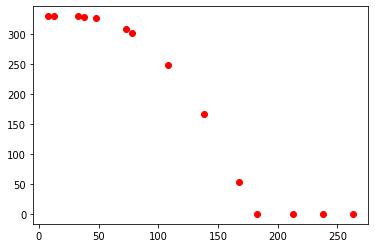

highHIIIIGHHHHHH:  77.0
rewaRD::  -43.6462514125313
returned state: [263.]
observation space:  (15,)
stepping:  11
ACTION            :  0
curtemp:  264.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 174.64186516532885
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 326.1138108988872
chisqds:  0.6057474808669396
BUT ARE WE SURE?: 3.7723503226773416


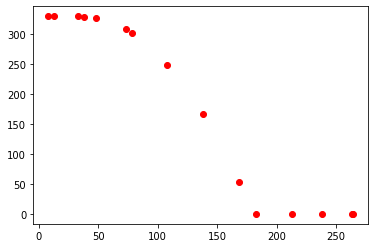

highHIIIIGHHHHHH:  76.0
rewaRD::  300
returned state: [264.]
observation space:  (16,)
stepping:  11
ACTION            :  0
curtemp:  265.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 304.2535021125743
chisqds:  6.512399783198351
BUT ARE WE SURE?: 7.369475730923861e-09


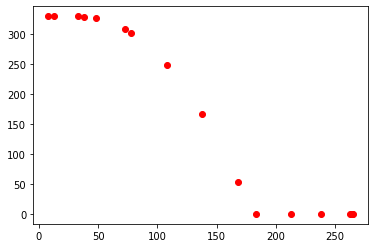

highHIIIIGHHHHHH:  75.0
rewaRD::  -38.57870933661367
returned state: [265.]
observation space:  (17,)
stepping:  11
ACTION            :  0
curtemp:  266.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 166.418322203515
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 276.50313148985447
chisqds:  8.788582309753052
BUT ARE WE SURE?: 2.386429957237172


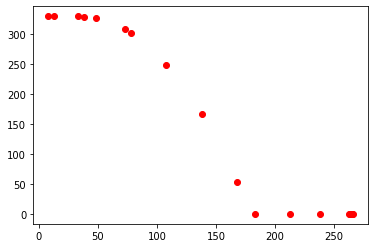

highHIIIIGHHHHHH:  74.0
rewaRD::  -54.48640225442236
returned state: [266.]
observation space:  (18,)
stepping:  11
ACTION            :  5
curtemp:  291.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 300.86752874857905
chisqds:  5.973206746267323
BUT ARE WE SURE?: 7.712703655787296e-09


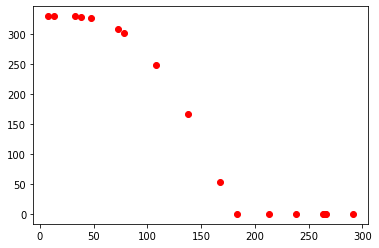

highHIIIIGHHHHHH:  49.0
rewaRD::  -33.03429514641171
returned state: [291.]
observation space:  (19,)
stepping:  11
ACTION            :  1
curtemp:  296.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291. 296.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 373.33540715415364
chisqds:  6.498069386106234
BUT ARE WE SURE?: 8.503658400626864e-09


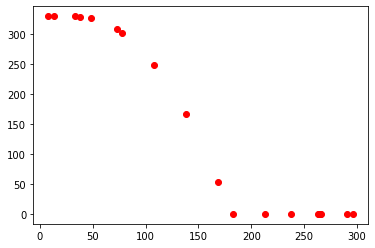

highHIIIIGHHHHHH:  44.0
rewaRD::  -38.443255029677736
returned state: [296.]
observation space:  (20,)
stepping:  11
ACTION            :  2
curtemp:  306.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291. 296. 306.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 366.84348290115554
chisqds:  5.436013762786835
BUT ARE WE SURE?: 2.898079974187512e-10


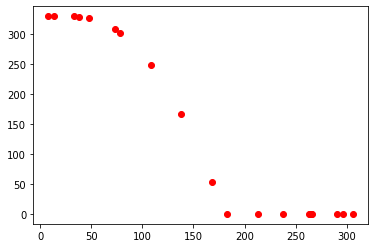

highHIIIIGHHHHHH:  34.0
rewaRD::  -26.416669005095486
returned state: [306.]
observation space:  (21,)
stepping:  11
ACTION            :  2
curtemp:  316.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291. 296. 306. 316.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 376.8518290764499
chisqds:  5.81483294948397
BUT ARE WE SURE?: 0.8900433242792508


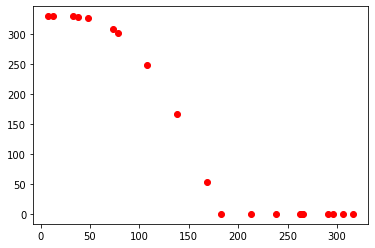

highHIIIIGHHHHHH:  24.0
rewaRD::  -31.210405616983806
returned state: [316.]
observation space:  (22,)
stepping:  11
ACTION            :  3
curtemp:  331.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291. 296. 306. 316. 331.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.3280709829499
chisqds:  3.432207555790228
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


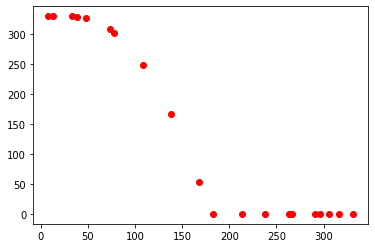

highHIIIIGHHHHHH:  9.0
rewaRD::  16.54306841822229
returned state: [331.]
observation space:  (23,)
stepping:  11
ACTION            :  4
curtemp:  351.0
Temperature:  [  8.  13.  33.  38.  48.  73.  78. 108. 138. 168. 183. 213. 238. 263.
 264. 265. 266. 291. 296. 306. 316. 331. 351.]
Intensity:  [3.30300000e+02 3.30299997e+02 3.29975052e+02 3.29430622e+02
 3.26891247e+02 3.08503336e+02 3.02504429e+02 2.49652068e+02
 1.67262210e+02 5.42780865e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 160.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.8199248635586
chisqds:  3.256596961519894
BUT ARE WE SURE?: 1.0106964919839078e-08


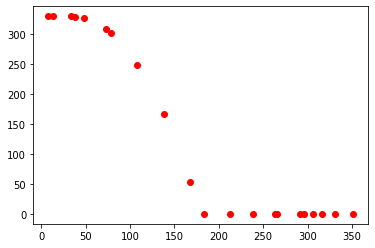

highHIIIIGHHHHHH:  -11.0
rewaRD::  22.82760339287276
terminated: over max temp
returned state: [351.]
observation space:  (24,)
reset
fixed Tn:  230
fixed Jt:  1.2
fixed Nf:  330
stepping:  12
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  12
ACTION            :  3
curtemp:  19.0
Temperature:  [ 4. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
returned state: [19.]
observation space:  (3,)
stepping:  12
ACTION            :  2
curtemp:  29.0
Temperature:  [ 4. 19. 29.]
highHIIIIGHHHHHH:  311.0
rewaRD::  -100
returned state: [29.]
observation space:  (4,)
stepping:  12
ACTION            :  5
curtemp:  54.0
Temperature:  [ 4. 19. 29. 54.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 382.95971290985864
chisqds:  34.41003938291148
BUT ARE WE SURE?: 30318.761728312722


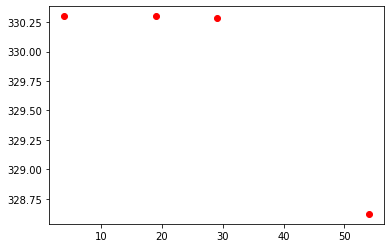

highHIIIIGHHHHHH:  286.0
rewaRD::  -88.37548555092192
returned state: [54.]
observation space:  (5,)
stepping:  12
ACTION            :  4
curtemp:  74.0
Temperature:  [ 4. 19. 29. 54. 74.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995 ]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 341.6026711740963
chisqds:  1.2651846243986666
BUT ARE WE SURE?: 62.82765176136567


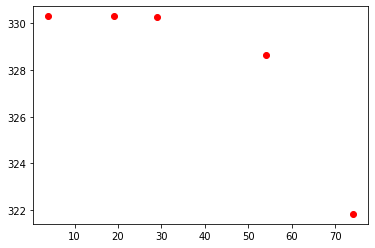

highHIIIIGHHHHHH:  266.0
rewaRD::  216.1593907214271
returned state: [74.]
observation space:  (6,)
stepping:  12
ACTION            :  6
curtemp:  104.0
Temperature:  [  4.  19.  29.  54.  74. 104.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 374.7932746442485
chisqds:  13.494470866353707
BUT ARE WE SURE?: 3.332377916828013e-09


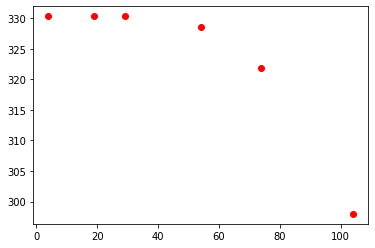

highHIIIIGHHHHHH:  236.0
rewaRD::  -70.35823012539635
returned state: [104.]
observation space:  (7,)
stepping:  12
ACTION            :  6
curtemp:  134.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798 256.53042168]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 328.804456552006
chisqds:  0.06456603855194769
BUT ARE WE SURE?: 3.756192275339195e-09


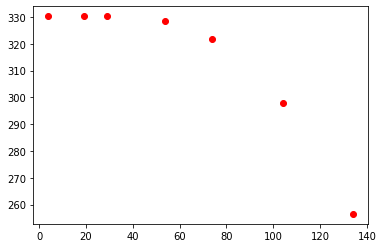

highHIIIIGHHHHHH:  206.0
rewaRD::  300
returned state: [134.]
observation space:  (8,)
stepping:  12
ACTION            :  4
curtemp:  154.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798 256.53042168 218.91376895]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 310.55186115023406
chisqds:  1.5204778441386269
BUT ARE WE SURE?: 1.239465877156495e-10


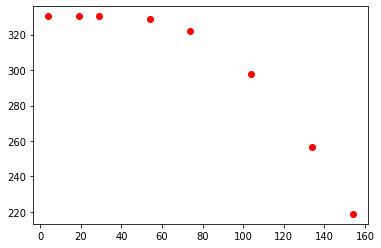

highHIIIIGHHHHHH:  186.0
rewaRD::  163.0751914879798
returned state: [154.]
observation space:  (9,)
stepping:  12
ACTION            :  1
curtemp:  159.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798 256.53042168 218.91376895 208.24142303]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 352.5525492238514
chisqds:  2.268982937848223
BUT ARE WE SURE?: 0.9201604336761876


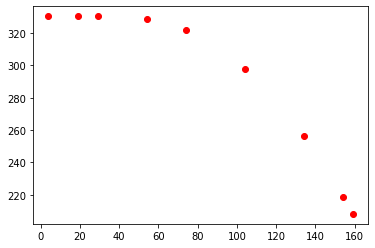

highHIIIIGHHHHHH:  181.0
rewaRD::  76.29043979472922
returned state: [159.]
observation space:  (10,)
stepping:  12
ACTION            :  5
curtemp:  184.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798 256.53042168 218.91376895 208.24142303 147.14655551]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 318.7738724265947
chisqds:  1.9356618405550106
BUT ARE WE SURE?: 4.34203412736496e-10


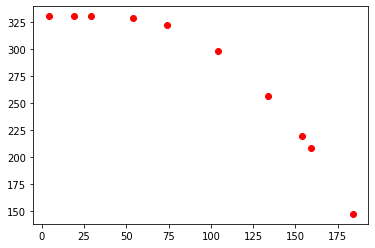

highHIIIIGHHHHHH:  156.0
rewaRD::  106.6476652168275
returned state: [184.]
observation space:  (11,)
stepping:  12
ACTION            :  5
curtemp:  209.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209.]
Intensity:  [330.3        330.29996273 330.2889457  328.62064518 321.8429995
 297.98221798 256.53042168 218.91376895 208.24142303 147.14655551
  72.94639241]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 428.5909986245166
chisqds:  37.10399763400366
BUT ARE WE SURE?: 0.22177359763691906


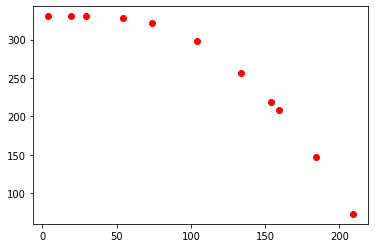

highHIIIIGHHHHHH:  131.0
rewaRD::  -89.2194904725462
returned state: [209.]
observation space:  (12,)
stepping:  12
ACTION            :  6
curtemp:  239.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.78977535756593
chisqds:  7.954078871995159
BUT ARE WE SURE?: 5.486520526426937e-09


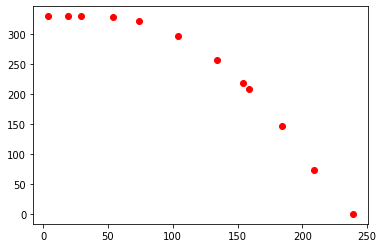

highHIIIIGHHHHHH:  101.0
rewaRD::  -49.7113359777804
returned state: [239.]
observation space:  (13,)
stepping:  12
ACTION            :  5
curtemp:  264.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.90034649061477
chisqds:  7.173502533765647
BUT ARE WE SURE?: 6.3731475142177434e-09


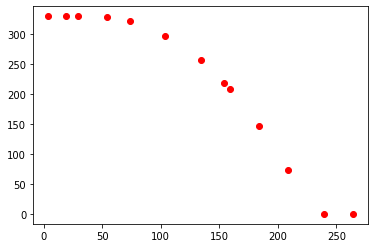

highHIIIIGHHHHHH:  76.0
rewaRD::  -44.23923346828113
returned state: [264.]
observation space:  (14,)
stepping:  12
ACTION            :  4
curtemp:  284.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 301.3617372824192
chisqds:  8.831141151517716
BUT ARE WE SURE?: 6.827014946848908e-10


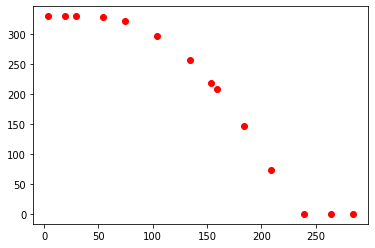

highHIIIIGHHHHHH:  56.0
rewaRD::  -54.70574038653474
returned state: [284.]
observation space:  (15,)
stepping:  12
ACTION            :  2
curtemp:  294.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.
 294.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 372.9180532196766
chisqds:  9.197650072690367
BUT ARE WE SURE?: 1.0788158471568956e-09


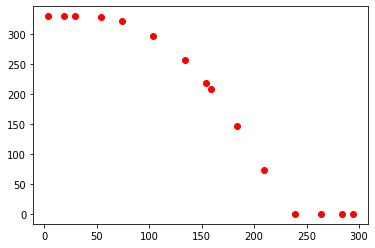

highHIIIIGHHHHHH:  46.0
rewaRD::  -56.510630776476404
returned state: [294.]
observation space:  (16,)
stepping:  12
ACTION            :  3
curtemp:  309.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.
 294. 309.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 348.756829123562
chisqds:  5.9557277160083055
BUT ARE WE SURE?: 0.27253994824774314


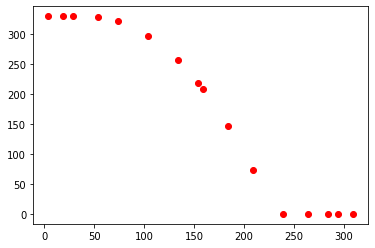

highHIIIIGHHHHHH:  31.0
rewaRD::  -32.8377623905058
returned state: [309.]
observation space:  (17,)
stepping:  12
ACTION            :  0
curtemp:  310.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.
 294. 309. 310.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 360.14532088503734
chisqds:  6.381180352964854
BUT ARE WE SURE?: 0.2639217078427665


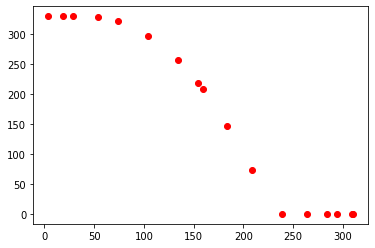

highHIIIIGHHHHHH:  30.0
rewaRD::  -37.3156723561104
returned state: [310.]
observation space:  (18,)
stepping:  12
ACTION            :  5
curtemp:  335.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.
 294. 309. 310. 335.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.53219688931904
chisqds:  4.875025517891463
BUT ARE WE SURE?: 8.024195049960417e-09


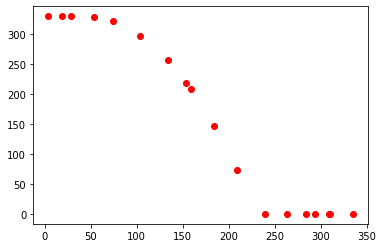

highHIIIIGHHHHHH:  5.0
rewaRD::  -17.94914743892309
returned state: [335.]
observation space:  (19,)
stepping:  12
ACTION            :  3
curtemp:  350.0
Temperature:  [  4.  19.  29.  54.  74. 104. 134. 154. 159. 184. 209. 239. 264. 284.
 294. 309. 310. 335. 350.]
Intensity:  [3.30300000e+02 3.30299963e+02 3.30288946e+02 3.28620645e+02
 3.21843000e+02 2.97982218e+02 2.56530422e+02 2.18913769e+02
 2.08241423e+02 1.47146556e+02 7.29463924e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 210.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 299.2726014124502
chisqds:  6.286428906450289
BUT ARE WE SURE?: 2.5717080648881485e-10


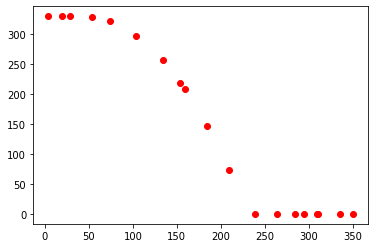

highHIIIIGHHHHHH:  -10.0
rewaRD::  -36.37087033791574
terminated: over max temp
returned state: [350.]
observation space:  (20,)
reset
fixed Tn:  80
fixed Jt:  1.4
fixed Nf:  330
stepping:  13
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  13
ACTION            :  6
curtemp:  34.0
Temperature:  [ 4. 34.]
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
returned state: [34.]
observation space:  (3,)
stepping:  13
ACTION            :  5
curtemp:  59.0
Temperature:  [ 4. 34. 59.]
highHIIIIGHHHHHH:  281.0
rewaRD::  -100
returned state: [59.]
observation space:  (4,)
stepping:  13
ACTION            :  2
curtemp:  69.0
Temperature:  [ 4. 34. 59. 69.]
Intensity:  [330.29999999 300.71480504 179.13547592 103.02106991]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.6045763064692
chisqds:  248.9870166848578
BUT ARE WE SURE?: 2.6569593496610893e-09


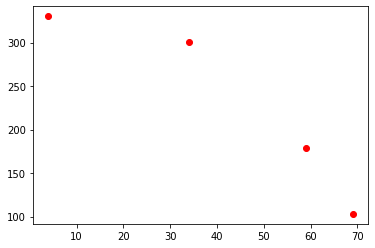

highHIIIIGHHHHHH:  271.0
rewaRD::  -98.39349053084852
returned state: [69.]
observation space:  (5,)
stepping:  13
ACTION            :  3
curtemp:  84.0
Temperature:  [ 4. 34. 59. 69. 84.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.861831964051
chisqds:  124.47967638437254
BUT ARE WE SURE?: 3.160283895384156e-09


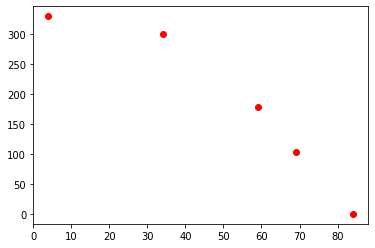

highHIIIIGHHHHHH:  256.0
rewaRD::  -96.78662403680367
returned state: [84.]
observation space:  (6,)
stepping:  13
ACTION            :  3
curtemp:  99.0
Temperature:  [ 4. 34. 59. 69. 84. 99.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.9691972898384
chisqds:  82.98267485963203
BUT ARE WE SURE?: 3.4029803526480664e-09


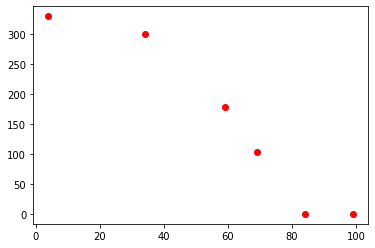

highHIIIIGHHHHHH:  241.0
rewaRD::  -95.17971672187461
returned state: [99.]
observation space:  (7,)
stepping:  13
ACTION            :  5
curtemp:  124.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 336.3034821665021
chisqds:  62.22839337284228
BUT ARE WE SURE?: 0.7655253953767112


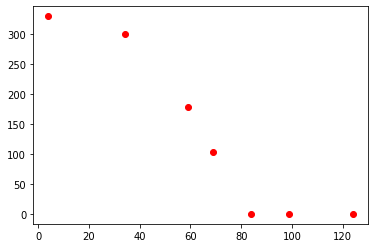

highHIIIIGHHHHHH:  216.0
rewaRD::  -93.57206608881263
returned state: [124.]
observation space:  (8,)
stepping:  13
ACTION            :  5
curtemp:  149.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 301.0058678765472
chisqds:  51.88039883454479
BUT ARE WE SURE?: 4.2641865508479177e-10


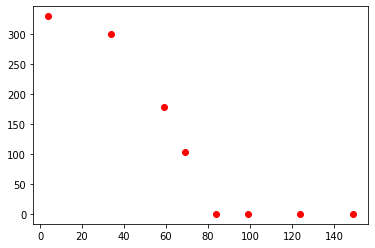

highHIIIIGHHHHHH:  191.0
rewaRD::  -92.28995904068381
returned state: [149.]
observation space:  (9,)
stepping:  13
ACTION            :  1
curtemp:  154.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 397.1431261397076
chisqds:  43.88390309608906
BUT ARE WE SURE?: 4.790914917804973e-09


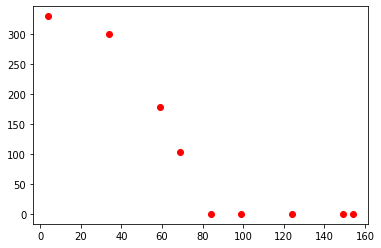

highHIIIIGHHHHHH:  186.0
rewaRD::  -90.88504048684658
returned state: [154.]
observation space:  (10,)
stepping:  13
ACTION            :  3
curtemp:  169.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.0694483096254
chisqds:  35.54847313085119
BUT ARE WE SURE?: 4.948008857217748e-09


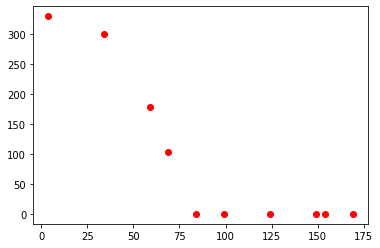

highHIIIIGHHHHHH:  171.0
rewaRD::  -88.74775863009275
returned state: [169.]
observation space:  (11,)
stepping:  13
ACTION            :  5
curtemp:  194.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.9756037035879
chisqds:  31.222031521230424
BUT ARE WE SURE?: 37254496.01900857


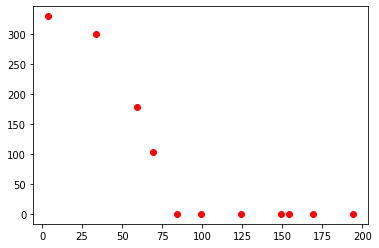

highHIIIIGHHHHHH:  146.0
rewaRD::  -87.18853384899035
returned state: [194.]
observation space:  (12,)
stepping:  13
ACTION            :  4
curtemp:  214.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 286.4637676956426
chisqds:  29.749592436432334
BUT ARE WE SURE?: 3.453341375284398e-10


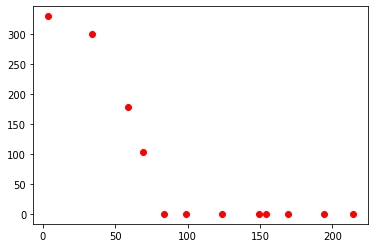

highHIIIIGHHHHHH:  126.0
rewaRD::  -86.55443764970215
returned state: [214.]
observation space:  (13,)
stepping:  13
ACTION            :  0
curtemp:  215.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 345.19330035434217
chisqds:  24.84525870742174
BUT ARE WE SURE?: 0.7458106976072929


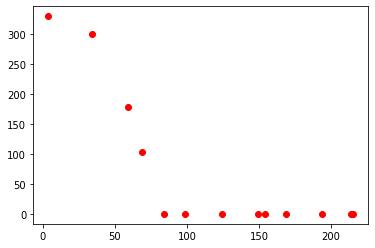

highHIIIIGHHHHHH:  125.0
rewaRD::  -83.90034876632166
returned state: [215.]
observation space:  (14,)
stepping:  13
ACTION            :  3
curtemp:  230.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 1.9924780718235022
THE NF RESULT {X1}: 404.7798230437878
chisqds:  24.402696816907977
BUT ARE WE SURE?: 10.388611330422044


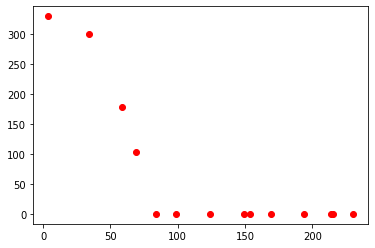

highHIIIIGHHHHHH:  110.0
rewaRD::  -83.60836906669877
returned state: [230.]
observation space:  (15,)
---------------------------------------
| approxkl           | 9.519774e-05   |
| clipfrac           | 0.0            |
| ep_len_mean        | 18.4           |
| ep_reward_mean     | -380           |
| explained_variance | -6.06e-05      |
| fps                | 2              |
| n_updates          | 2              |
| policy_entropy     | 1.9452392      |
| policy_loss        | -0.00055462064 |
| serial_timesteps   | 256            |
| time_elapsed       | 149            |
| total_timesteps    | 256            |
| value_loss         | 71275.22       |
---------------------------------------
stepping:  13
ACTION            :  0
curtemp:  231.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.

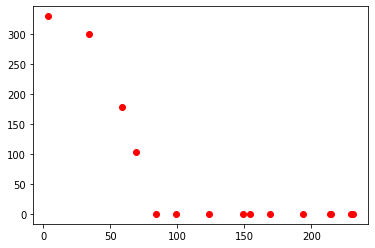

highHIIIIGHHHHHH:  109.0
rewaRD::  -80.81757457800775
returned state: [231.]
observation space:  (16,)
stepping:  13
ACTION            :  5
curtemp:  256.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 306.8159317457572
chisqds:  19.748041933195534
BUT ARE WE SURE?: 5.895116743752682e-10


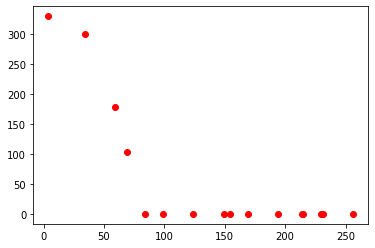

highHIIIIGHHHHHH:  84.0
rewaRD::  -79.74482729208617
returned state: [256.]
observation space:  (17,)
stepping:  13
ACTION            :  5
curtemp:  281.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 356.1707567511531
chisqds:  17.792427628759086
BUT ARE WE SURE?: 7.98011698731485e-09


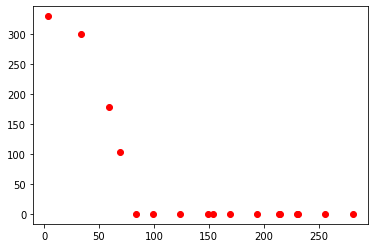

highHIIIIGHHHHHH:  59.0
rewaRD::  -77.5185259512618
returned state: [281.]
observation space:  (18,)
stepping:  13
ACTION            :  0
curtemp:  282.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281. 282.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.5627544416029
chisqds:  16.624654943644295
BUT ARE WE SURE?: 8.034737099780224e-09


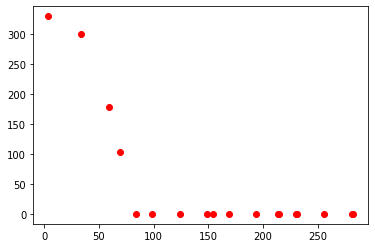

highHIIIIGHHHHHH:  58.0
rewaRD::  -75.93935023878963
returned state: [282.]
observation space:  (19,)
stepping:  13
ACTION            :  5
curtemp:  307.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281. 282. 307.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.25083462318827
chisqds:  15.551417507142315
BUT ARE WE SURE?: 8.747350233653965e-09


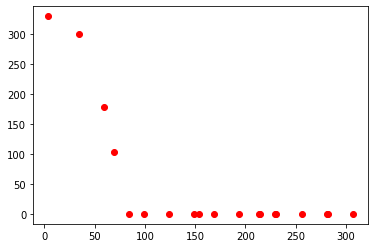

highHIIIIGHHHHHH:  33.0
rewaRD::  -74.2788720181751
returned state: [307.]
observation space:  (20,)
stepping:  13
ACTION            :  3
curtemp:  322.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281. 282. 307. 322.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 406.2570018492846
chisqds:  15.823417851764782
BUT ARE WE SURE?: 4.015049700441539e-09


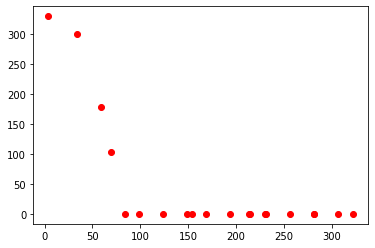

highHIIIIGHHHHHH:  18.0
rewaRD::  -74.72101136763015
returned state: [322.]
observation space:  (21,)
stepping:  13
ACTION            :  0
curtemp:  323.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281. 282. 307. 322. 323.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.7973701289543
chisqds:  13.812652399224824
BUT ARE WE SURE?: 8.852102892254488e-09


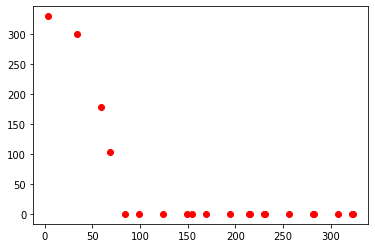

highHIIIIGHHHHHH:  17.0
rewaRD::  -71.04104349846317
returned state: [323.]
observation space:  (22,)
stepping:  13
ACTION            :  4
curtemp:  343.0
Temperature:  [  4.  34.  59.  69.  84.  99. 124. 149. 154. 169. 194. 214. 215. 230.
 231. 256. 281. 282. 307. 322. 323. 343.]
Intensity:  [3.30300000e+02 3.00714805e+02 1.79135476e+02 1.03021070e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 336.14561094925125
chisqds:  13.101562576382545
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


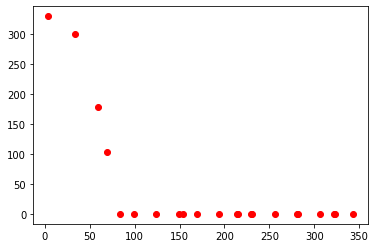

highHIIIIGHHHHHH:  -3.0
rewaRD::  -69.46929057751801
terminated: over max temp
returned state: [343.]
observation space:  (23,)
reset
fixed Tn:  50
fixed Jt:  0.8
fixed Nf:  330
stepping:  14
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  14
ACTION            :  6
curtemp:  48.0
Temperature:  [18. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
returned state: [48.]
observation space:  (3,)
stepping:  14
ACTION            :  6
curtemp:  78.0
Temperature:  [18. 48. 78.]
highHIIIIGHHHHHH:  262.0
rewaRD::  -100
returned state: [78.]
observation space:  (4,)
stepping:  14
ACTION            :  1
curtemp:  83.0
Temperature:  [18. 48. 78. 83.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.5583455095587
chisqds:  35.37034635309558
BUT ARE WE SURE?: 385606956759.9838


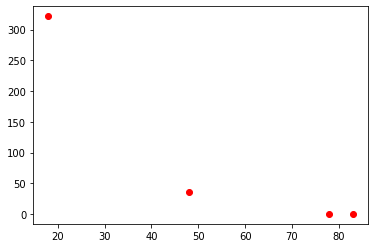

highHIIIIGHHHHHH:  257.0
rewaRD::  -88.69109179743748
returned state: [83.]
observation space:  (5,)
stepping:  14
ACTION            :  2
curtemp:  93.0
Temperature:  [18. 48. 78. 83. 93.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.56735169378607
chisqds:  17.68517280655644
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


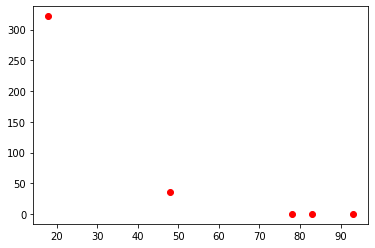

highHIIIIGHHHHHH:  247.0
rewaRD::  -77.38218312168782
returned state: [93.]
observation space:  (6,)
stepping:  14
ACTION            :  6
curtemp:  123.0
Temperature:  [ 18.  48.  78.  83.  93. 123.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.568189418015
chisqds:  11.790115187364778
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


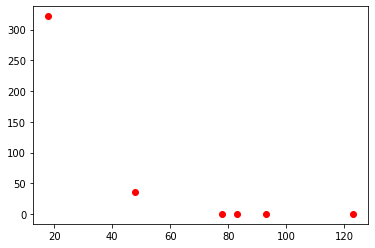

highHIIIIGHHHHHH:  217.0
rewaRD::  -66.07327463359546
returned state: [123.]
observation space:  (7,)
stepping:  14
ACTION            :  0
curtemp:  124.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 457.80295617742536
chisqds:  8.842586385968614
BUT ARE WE SURE?: 4037181976.798592


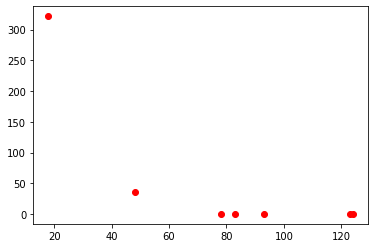

highHIIIIGHHHHHH:  216.0
rewaRD::  -54.76436615482563
returned state: [124.]
observation space:  (8,)
stepping:  14
ACTION            :  2
curtemp:  134.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 267.86611225653735
chisqds:  13.060190505341144
BUT ARE WE SURE?: 5.096866174898523e-10


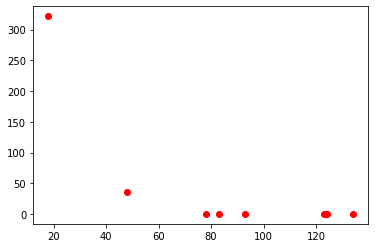

highHIIIIGHHHHHH:  206.0
rewaRD::  -69.37257539724138
returned state: [134.]
observation space:  (9,)
stepping:  14
ACTION            :  6
curtemp:  164.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 495.69528992144745
chisqds:  10.259970630842366
BUT ARE WE SURE?: 5.162547733351519e-10


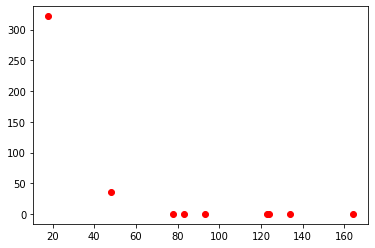

highHIIIIGHHHHHH:  176.0
rewaRD::  -61.01353362576252
returned state: [164.]
observation space:  (10,)
stepping:  14
ACTION            :  6
curtemp:  194.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.5614100029151
chisqds:  5.0529065802822615
BUT ARE WE SURE?: 430420867657.0497


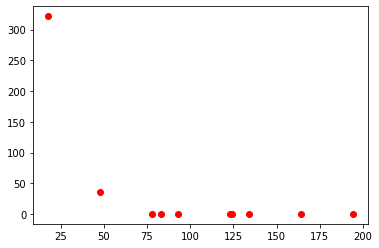

highHIIIIGHHHHHH:  146.0
rewaRD::  -20.837641930507345
returned state: [194.]
observation space:  (11,)
stepping:  14
ACTION            :  1
curtemp:  199.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.59125575882945
chisqds:  4.421293168535216
BUT ARE WE SURE?: 21660070.538866792


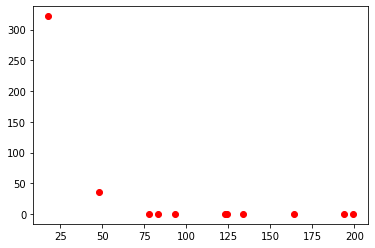

highHIIIIGHHHHHH:  141.0
rewaRD::  -9.52873180935866
returned state: [199.]
observation space:  (12,)
stepping:  14
ACTION            :  5
curtemp:  224.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.87356218277864
chisqds:  3.9300587710056742
BUT ARE WE SURE?: 21659932.344668455


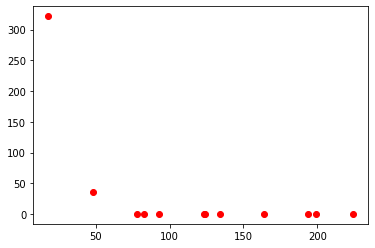

highHIIIIGHHHHHH:  116.0
rewaRD::  1.7796484243524162
returned state: [224.]
observation space:  (13,)
stepping:  14
ACTION            :  5
curtemp:  249.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.8923382094992
chisqds:  3.5370553360117247
BUT ARE WE SURE?: 21659923.164676696


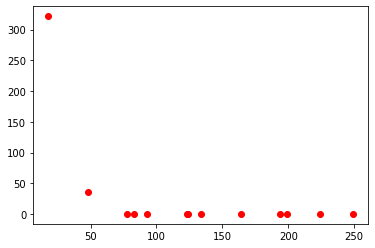

highHIIIIGHHHHHH:  91.0
rewaRD::  13.088420169029007
returned state: [249.]
observation space:  (14,)
stepping:  14
ACTION            :  3
curtemp:  264.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.56702903299254
chisqds:  3.215485966688371
BUT ARE WE SURE?: 16127845060676.818


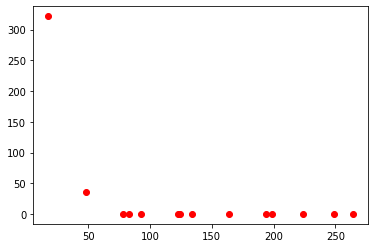

highHIIIIGHHHHHH:  76.0
rewaRD::  24.39799275876176
returned state: [264.]
observation space:  (15,)
stepping:  14
ACTION            :  5
curtemp:  289.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.
 289.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.4832978221515
chisqds:  2.9475305120378703
BUT ARE WE SURE?: 21660123.465751246


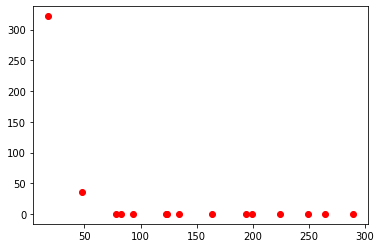

highHIIIIGHHHHHH:  51.0
rewaRD::  35.70682249645216
returned state: [289.]
observation space:  (16,)
stepping:  14
ACTION            :  1
curtemp:  294.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.
 289. 294.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.5327441974141
chisqds:  2.7207961823322515
BUT ARE WE SURE?: 21660099.21922594


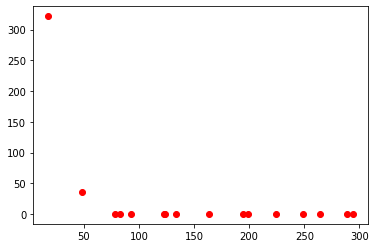

highHIIIIGHHHHHH:  46.0
rewaRD::  47.01578993584229
returned state: [294.]
observation space:  (17,)
stepping:  14
ACTION            :  6
curtemp:  324.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.
 289. 294. 324.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.5586257878729
chisqds:  2.526453308913161
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


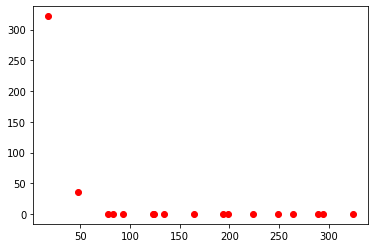

highHIIIIGHHHHHH:  16.0
rewaRD::  58.32471496260246
returned state: [324.]
observation space:  (18,)
stepping:  14
ACTION            :  2
curtemp:  334.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.
 289. 294. 324. 334.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 386.0620137447699
chisqds:  2.3580562076670533
BUT ARE WE SURE?: 21659840.26291685


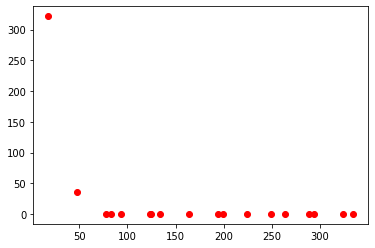

highHIIIIGHHHHHH:  6.0
rewaRD::  69.63124063770331
returned state: [334.]
observation space:  (19,)
stepping:  14
ACTION            :  3
curtemp:  349.0
Temperature:  [ 18.  48.  78.  83.  93. 123. 124. 134. 164. 194. 199. 224. 249. 264.
 289. 294. 324. 334. 349.]
Intensity:  [3.21728733e+02 3.59678429e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 30.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 385.4741578672769
chisqds:  2.2106481385529007
BUT ARE WE SURE?: 21660127.948714983


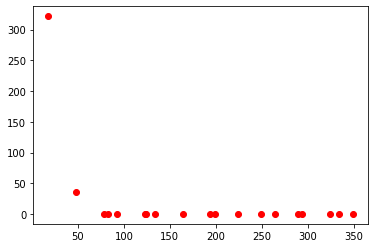

highHIIIIGHHHHHH:  -9.0
rewaRD::  80.9424091623381
terminated: over max temp
returned state: [349.]
observation space:  (20,)
reset
fixed Tn:  210
fixed Jt:  1.1
fixed Nf:  330
stepping:  15
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  15
ACTION            :  1
curtemp:  9.0
Temperature:  [4. 9.]
highHIIIIGHHHHHH:  331.0
rewaRD::  -100
returned state: [9.]
observation space:  (3,)
stepping:  15
ACTION            :  2
curtemp:  19.0
Temperature:  [ 4.  9. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
returned state: [19.]
observation space:  (4,)
stepping:  15
ACTION            :  5
curtemp:  44.0
Temperature:  [ 4.  9. 19. 44.]
Intensity:  [330.3        330.3        330.29991666 329.63887952]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 206.98374138157618
chisqds:  182.937133564898
BUT ARE WE SURE?: 1.3940499795196193e-10


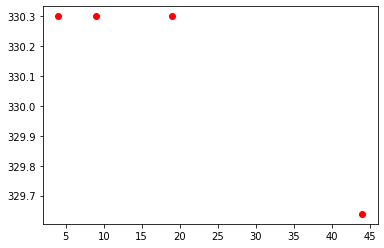

highHIIIIGHHHHHH:  296.0
rewaRD::  -97.81345650166702
returned state: [44.]
observation space:  (5,)
stepping:  15
ACTION            :  2
curtemp:  54.0
Temperature:  [ 4.  9. 19. 44. 54.]
Intensity:  [330.3        330.3        330.29991666 329.63887952 327.92853982]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 202.81166882991695
chisqds:  121.74540610670093
BUT ARE WE SURE?: 2.559944728354762e-10


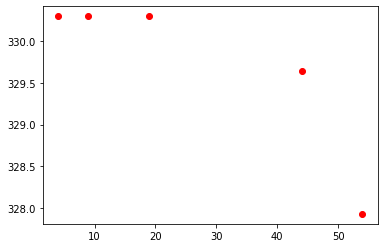

highHIIIIGHHHHHH:  286.0
rewaRD::  -96.71445508465897
returned state: [54.]
observation space:  (6,)
stepping:  15
ACTION            :  0
curtemp:  55.0
Temperature:  [ 4.  9. 19. 44. 54. 55.]
Intensity:  [330.3        330.3        330.29991666 329.63887952 327.92853982
 327.67123141]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 331.89743272121194
chisqds:  0.040866095304594445
BUT ARE WE SURE?: 218.30506786894745


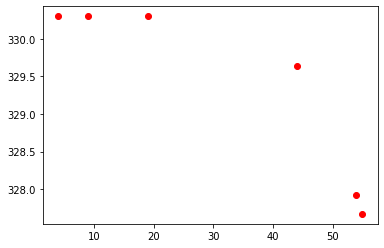

highHIIIIGHHHHHH:  285.0
rewaRD::  300
terminated: excellent conditions
returned state: [55.]
observation space:  (7,)
reset
fixed Tn:  90
fixed Jt:  1.3
fixed Nf:  330
stepping:  16
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  16
ACTION            :  3
curtemp:  33.0
Temperature:  [18. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (3,)
stepping:  16
ACTION            :  1
curtemp:  38.0
Temperature:  [18. 33. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (4,)
stepping:  16
ACTION            :  0
curtemp:  39.0
Temperature:  [18. 33. 38. 39.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 338.14465336524484
chisqds:  0.34419932012377763
BUT ARE WE SURE?: 4.644138048478992


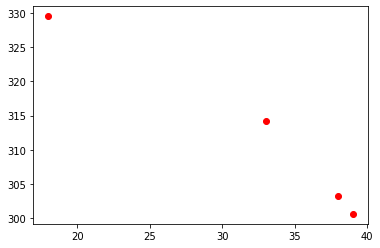

highHIIIIGHHHHHH:  301.0
rewaRD::  300
returned state: [39.]
observation space:  (5,)
stepping:  16
ACTION            :  1
curtemp:  44.0
Temperature:  [18. 33. 38. 39. 44.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197 285.83542945]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.753923369402
chisqds:  0.5809327670836678
BUT ARE WE SURE?: 3.1827544114216278e-09


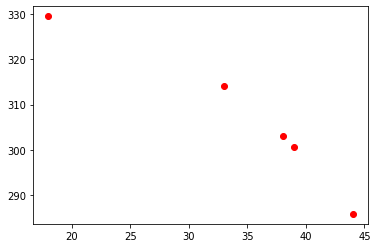

highHIIIIGHHHHHH:  296.0
rewaRD::  300
returned state: [44.]
observation space:  (6,)
stepping:  16
ACTION            :  1
curtemp:  49.0
Temperature:  [18. 33. 38. 39. 44. 49.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197 285.83542945
 267.97653234]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 327.9153762831163
chisqds:  2.8284167032929353
BUT ARE WE SURE?: 1.4165444215908933


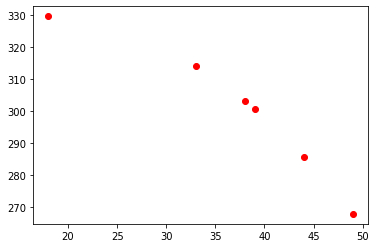

highHIIIIGHHHHHH:  291.0
rewaRD::  41.42187731189216
returned state: [49.]
observation space:  (7,)
stepping:  16
ACTION            :  3
curtemp:  64.0
Temperature:  [18. 33. 38. 39. 44. 49. 64.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197 285.83542945
 267.97653234 195.52796777]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 1.5496940879429295
THE NF RESULT {X1}: 385.206266902397
chisqds:  22.227152889405176
BUT ARE WE SURE?: 0.862909397659772


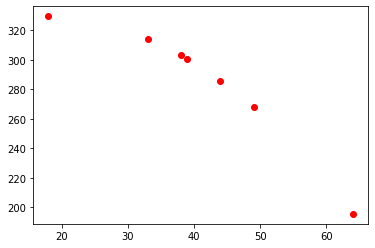

highHIIIIGHHHHHH:  276.0
rewaRD::  -82.00399295446137
returned state: [64.]
observation space:  (8,)
stepping:  16
ACTION            :  3
curtemp:  79.0
Temperature:  [18. 33. 38. 39. 44. 49. 64. 79.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197 285.83542945
 267.97653234 195.52796777  93.9454319 ]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 341.56164019333687
chisqds:  32.235261791840585
BUT ARE WE SURE?: 1.772749645055783e-09


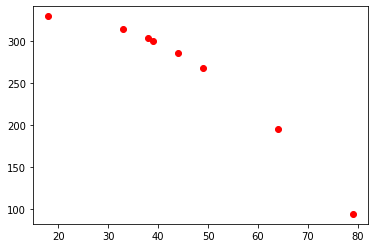

highHIIIIGHHHHHH:  261.0
rewaRD::  -87.59122843229869
returned state: [79.]
observation space:  (9,)
stepping:  16
ACTION            :  1
curtemp:  84.0
Temperature:  [18. 33. 38. 39. 44. 49. 64. 79. 84.]
Intensity:  [329.54686081 314.19323387 303.16497941 300.58708197 285.83542945
 267.97653234 195.52796777  93.9454319   53.41678809]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 183.12539390660388
chisqds:  110.0042911026815
BUT ARE WE SURE?: 1.995990980084818e-09


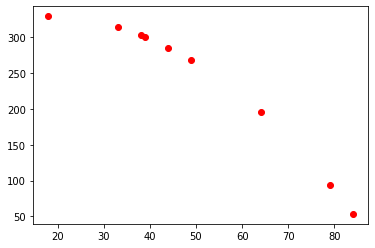

highHIIIIGHHHHHH:  256.0
rewaRD::  -96.36377821273693
returned state: [84.]
observation space:  (10,)
stepping:  16
ACTION            :  2
curtemp:  94.0
Temperature:  [18. 33. 38. 39. 44. 49. 64. 79. 84. 94.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 343.9763730951459
chisqds:  30.454040664215956
BUT ARE WE SURE?: 0.5770160818858457


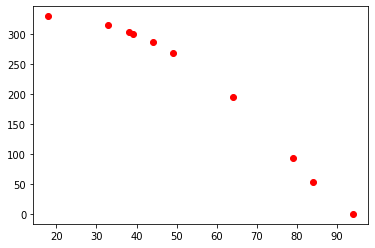

highHIIIIGHHHHHH:  246.0
rewaRD::  -86.8654539339994
returned state: [94.]
observation space:  (11,)
stepping:  16
ACTION            :  4
curtemp:  114.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 340.01059446199895
chisqds:  26.826745653961737
BUT ARE WE SURE?: 0.5837462194049048


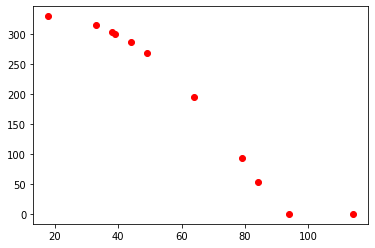

highHIIIIGHHHHHH:  226.0
rewaRD::  -85.08950712249629
returned state: [114.]
observation space:  (12,)
stepping:  16
ACTION            :  1
curtemp:  119.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 200.14083431450274
chisqds:  63.896286730829374
BUT ARE WE SURE?: 1.0138219097837212e-09


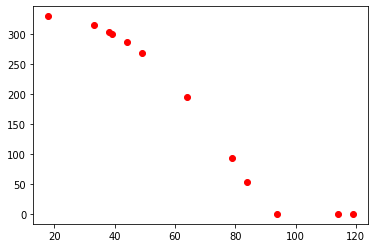

highHIIIIGHHHHHH:  221.0
rewaRD::  -93.73985531138848
returned state: [119.]
observation space:  (13,)
stepping:  16
ACTION            :  5
curtemp:  144.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 435.0452309498731
chisqds:  25.64649166164964
BUT ARE WE SURE?: 0.8967831340743148


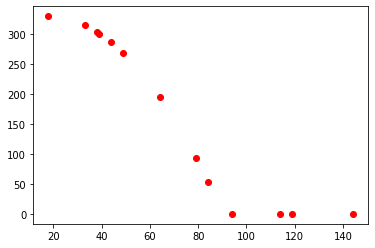

highHIIIIGHHHHHH:  196.0
rewaRD::  -84.40332481818018
returned state: [144.]
observation space:  (14,)
stepping:  16
ACTION            :  0
curtemp:  145.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 390.34429132299385
chisqds:  21.121223326864428
BUT ARE WE SURE?: 6.474283956345963e-09


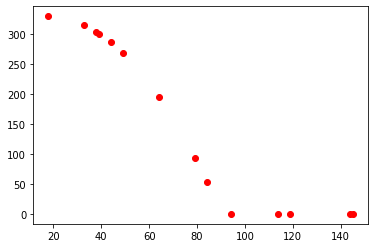

highHIIIIGHHHHHH:  195.0
rewaRD::  -81.06170301739893
returned state: [145.]
observation space:  (15,)
stepping:  16
ACTION            :  6
curtemp:  175.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.1492452424795
chisqds:  18.418832444685382
BUT ARE WE SURE?: 7.12872991175564e-09


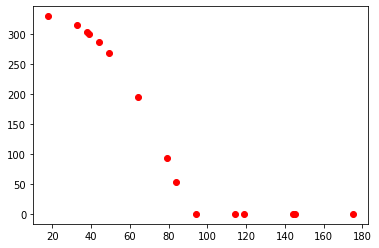

highHIIIIGHHHHHH:  165.0
rewaRD::  -78.28309686831334
returned state: [175.]
observation space:  (16,)
stepping:  16
ACTION            :  0
curtemp:  176.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.437068178152
chisqds:  16.77389241565654
BUT ARE WE SURE?: 7.470772392345737e-09


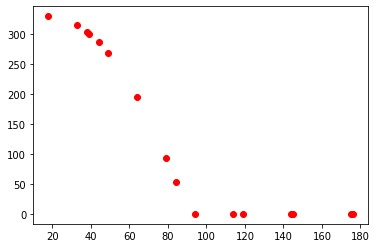

highHIIIIGHHHHHH:  164.0
rewaRD::  -76.15341805658387
returned state: [176.]
observation space:  (17,)
stepping:  16
ACTION            :  0
curtemp:  177.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.4212328294376
chisqds:  15.415196418600857
BUT ARE WE SURE?: 7.72281496643161e-09


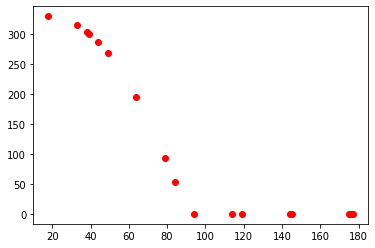

highHIIIIGHHHHHH:  163.0
rewaRD::  -74.05157941955659
returned state: [177.]
observation space:  (18,)
stepping:  16
ACTION            :  1
curtemp:  182.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.714351958487
chisqds:  14.377778711471652
BUT ARE WE SURE?: 8.16808987992041e-09


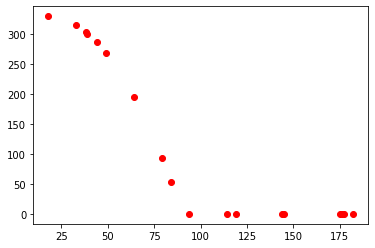

highHIIIIGHHHHHH:  158.0
rewaRD::  -72.17929083295388
returned state: [182.]
observation space:  (19,)
stepping:  16
ACTION            :  4
curtemp:  202.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.9949208798163
chisqds:  13.470584020753106
BUT ARE WE SURE?: 8.615671852814467e-09


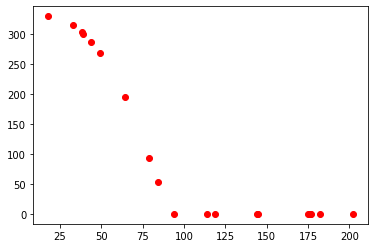

highHIIIIGHHHHHH:  138.0
rewaRD::  -70.30566756543365
returned state: [202.]
observation space:  (20,)
stepping:  16
ACTION            :  4
curtemp:  222.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 331.97073761222254
chisqds:  12.882998751746943
BUT ARE WE SURE?: 0.5978837188822252


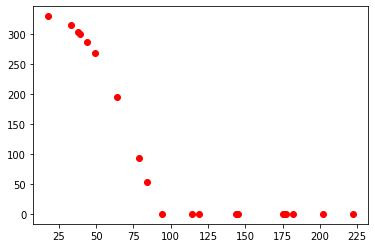

highHIIIIGHHHHHH:  118.0
rewaRD::  -68.95132820332225
returned state: [222.]
observation space:  (21,)
stepping:  16
ACTION            :  5
curtemp:  247.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.9729347015791
chisqds:  12.13079213312683
BUT ARE WE SURE?: 9.55313791058575e-09


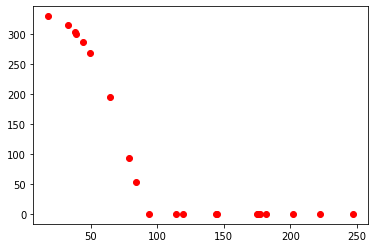

highHIIIIGHHHHHH:  93.0
rewaRD::  -67.0260609851126
returned state: [247.]
observation space:  (22,)
stepping:  16
ACTION            :  6
curtemp:  277.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 351.90634066695185
chisqds:  11.14527413222155
BUT ARE WE SURE?: 0.5640134212406609


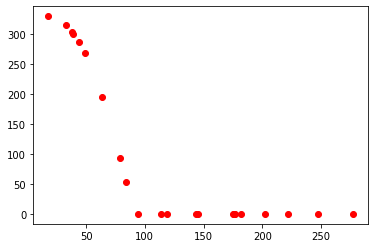

highHIIIIGHHHHHH:  63.0
rewaRD::  -64.11034890173048
returned state: [277.]
observation space:  (23,)
stepping:  16
ACTION            :  2
curtemp:  287.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277. 287.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 351.1372210501354
chisqds:  10.5906465515945
BUT ARE WE SURE?: 9.465166402740548e-09


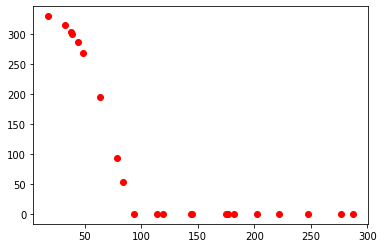

highHIIIIGHHHHHH:  53.0
rewaRD::  -62.230823392007444
returned state: [287.]
observation space:  (24,)
stepping:  16
ACTION            :  5
curtemp:  312.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277. 287. 312.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 352.5016731123472
chisqds:  10.08247182264138
BUT ARE WE SURE?: 97157237.98245338


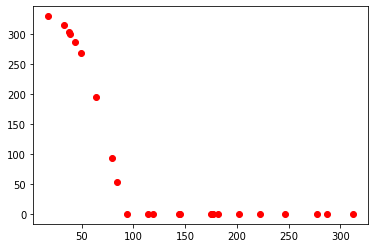

highHIIIIGHHHHHH:  28.0
rewaRD::  -60.32718890403911
returned state: [312.]
observation space:  (25,)
stepping:  16
ACTION            :  0
curtemp:  313.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277. 287. 312. 313.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 351.7120313547991
chisqds:  9.625991283409434
BUT ARE WE SURE?: 1.0370520195829165e-08


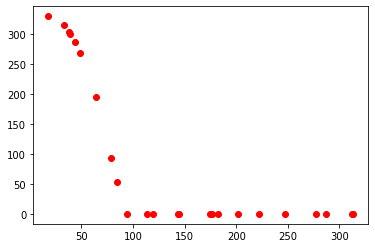

highHIIIIGHHHHHH:  27.0
rewaRD::  -58.445838124806215
returned state: [313.]
observation space:  (26,)
stepping:  16
ACTION            :  3
curtemp:  328.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277. 287. 312. 313. 328.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.0752191904889
chisqds:  9.348834196028967
BUT ARE WE SURE?: 1.1090810033082126e-08


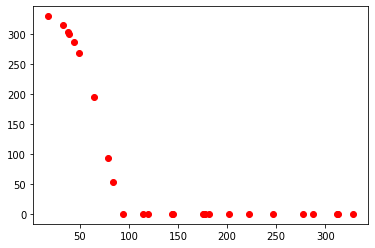

highHIIIIGHHHHHH:  12.0
rewaRD::  -57.21391655764898
returned state: [328.]
observation space:  (27,)
stepping:  16
ACTION            :  4
curtemp:  348.0
Temperature:  [ 18.  33.  38.  39.  44.  49.  64.  79.  84.  94. 114. 119. 144. 145.
 175. 176. 177. 182. 202. 222. 247. 277. 287. 312. 313. 328. 348.]
Intensity:  [3.29546861e+02 3.14193234e+02 3.03164979e+02 3.00587082e+02
 2.85835429e+02 2.67976532e+02 1.95527968e+02 9.39454319e+01
 5.34167881e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 352.5911298888752
chisqds:  8.822024964965925
BUT ARE WE SURE?: 1.1236641086056044e-08


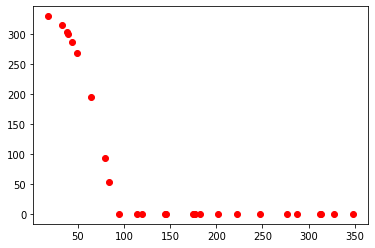

highHIIIIGHHHHHH:  -8.0
rewaRD::  -54.65893583519858
terminated: over max temp
returned state: [348.]
observation space:  (28,)
reset
fixed Tn:  190
fixed Jt:  1.4
fixed Nf:  330
stepping:  17
ACTION            :  5
curtemp:  28.0
Temperature:  [28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
returned state: [28.]
observation space:  (2,)
stepping:  17
ACTION            :  2
curtemp:  38.0
Temperature:  [28. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (3,)
stepping:  17
ACTION            :  2
curtemp:  48.0
Temperature:  [28. 38. 48.]
highHIIIIGHHHHHH:  292.0
rewaRD::  -100
returned state: [48.]
observation space:  (4,)
stepping:  17
ACTION            :  4
curtemp:  68.0
Temperature:  [28. 38. 48. 68.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325 ]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 320.6793206944492
chisqds:  0.6192733857933547
BUT ARE WE SURE?: 4.473037170311985e-10


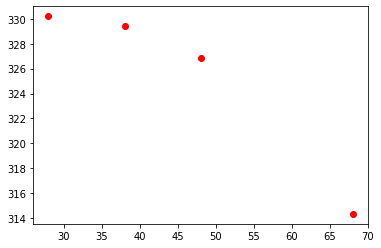

highHIIIIGHHHHHH:  272.0
rewaRD::  300
returned state: [68.]
observation space:  (5,)
stepping:  17
ACTION            :  3
curtemp:  83.0
Temperature:  [28. 38. 48. 68. 83.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 282.94050238249883
chisqds:  13.805890818659504
BUT ARE WE SURE?: 8.38737983843133


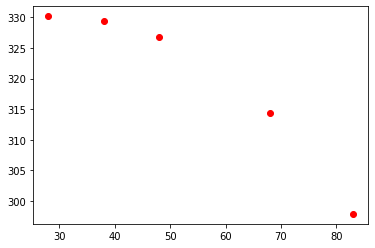

highHIIIIGHHHHHH:  257.0
rewaRD::  -71.02686054424133
returned state: [83.]
observation space:  (6,)
stepping:  17
ACTION            :  0
curtemp:  84.0
Temperature:  [28. 38. 48. 68. 83. 84.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 382.7561228081869
chisqds:  20.429878886546206
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


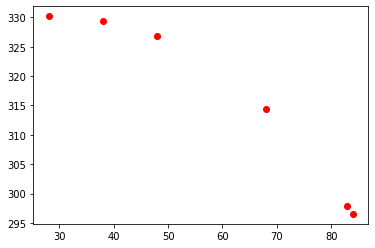

highHIIIIGHHHHHH:  256.0
rewaRD::  -80.42083351441627
returned state: [84.]
observation space:  (7,)
stepping:  17
ACTION            :  2
curtemp:  94.0
Temperature:  [28. 38. 48. 68. 83. 84. 94.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 318.53212216751535
chisqds:  0.2534969140693444
BUT ARE WE SURE?: 3.7027237976816805e-09


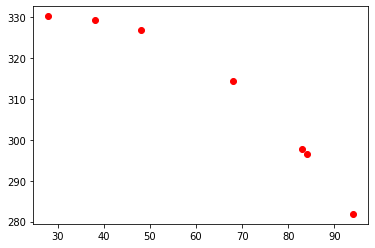

highHIIIIGHHHHHH:  246.0
rewaRD::  300
returned state: [94.]
observation space:  (8,)
stepping:  17
ACTION            :  2
curtemp:  104.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 1.722377156598761
THE NF RESULT {X1}: 330.16660671213316
chisqds:  1.9609155034151438
BUT ARE WE SURE?: 2.277910691433256


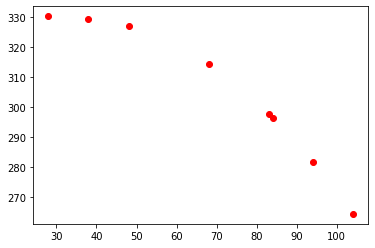

highHIIIIGHHHHHH:  236.0
rewaRD::  103.98635193783582
returned state: [104.]
observation space:  (9,)
stepping:  17
ACTION            :  0
curtemp:  105.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 403.49810078590906
chisqds:  27.528640066064924
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


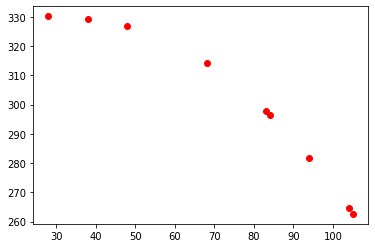

highHIIIIGHHHHHH:  235.0
rewaRD::  -85.46967815918057
returned state: [105.]
observation space:  (10,)
stepping:  17
ACTION            :  2
curtemp:  115.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 290.7433778235798
chisqds:  4.50771112220462
BUT ARE WE SURE?: 9.124448118662534e-10


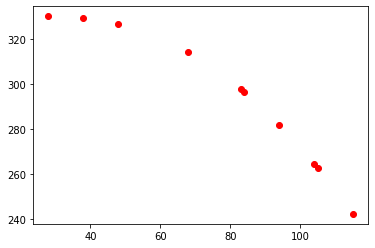

highHIIIIGHHHHHH:  225.0
rewaRD::  -11.263169010624395
returned state: [115.]
observation space:  (11,)
stepping:  17
ACTION            :  2
curtemp:  125.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215
 219.26971037]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 315.9639993835362
chisqds:  0.4582320468708946
BUT ARE WE SURE?: 0.9009773106265677


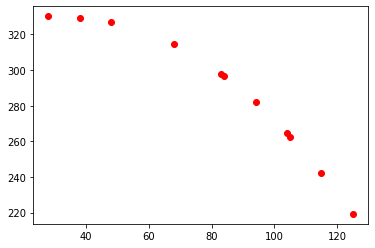

highHIIIIGHHHHHH:  215.0
rewaRD::  300
returned state: [125.]
observation space:  (12,)
stepping:  17
ACTION            :  5
curtemp:  150.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215
 219.26971037 149.45345584]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 306.29707901784434
chisqds:  3.0859232544172066
BUT ARE WE SURE?: 6.982553902885474e-10


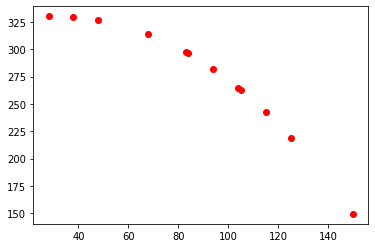

highHIIIIGHHHHHH:  190.0
rewaRD::  29.62085153201329
returned state: [150.]
observation space:  (13,)
stepping:  17
ACTION            :  4
curtemp:  170.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215
 219.26971037 149.45345584  80.74427299]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 223.09857376363593
chisqds:  43.13237556226012
BUT ARE WE SURE?: 6.236144555370567e-09


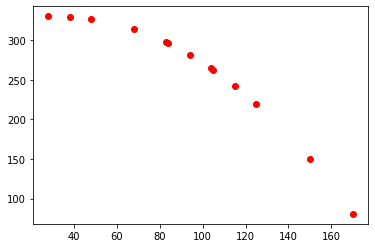

highHIIIIGHHHHHH:  170.0
rewaRD::  -90.72622375221107
returned state: [170.]
observation space:  (14,)
stepping:  17
ACTION            :  1
curtemp:  175.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215
 219.26971037 149.45345584  80.74427299  61.74318508]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 295.2984781515571
chisqds:  17.04845618181004
BUT ARE WE SURE?: 1.0962346033402753e-09


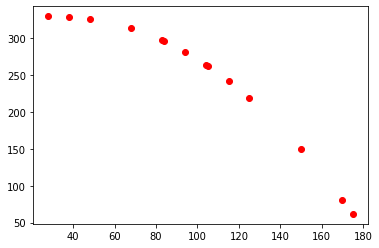

highHIIIIGHHHHHH:  165.0
rewaRD::  -76.5374649918869
returned state: [175.]
observation space:  (15,)
stepping:  17
ACTION            :  2
curtemp:  185.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185.]
Intensity:  [330.2022151  329.38081685 326.84967407 314.3459325  297.85034375
 296.53326953 281.87808179 264.52883674 262.64557943 242.32261215
 219.26971037 149.45345584  80.74427299  61.74318508  21.52460146]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 314.07289058661837
chisqds:  15.116554858282726
BUT ARE WE SURE?: 8.403916479317366e-10


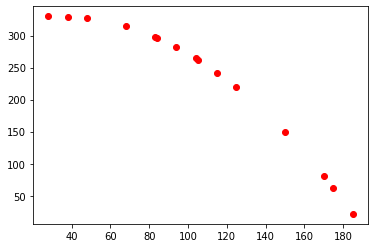

highHIIIIGHHHHHH:  155.0
rewaRD::  -73.53894430642507
returned state: [185.]
observation space:  (16,)
stepping:  17
ACTION            :  5
curtemp:  210.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 322.1229593038298
chisqds:  13.569075008522942
BUT ARE WE SURE?: 6.841865450036058e-09


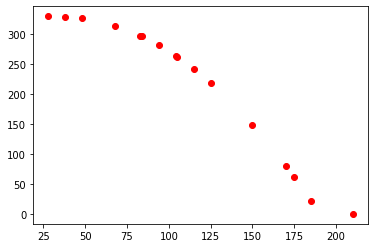

highHIIIIGHHHHHH:  130.0
rewaRD::  -70.52120356407832
returned state: [210.]
observation space:  (17,)
stepping:  17
ACTION            :  2
curtemp:  220.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 327.5271141990589
chisqds:  12.518882930188434
BUT ARE WE SURE?: 0.30231856972959553


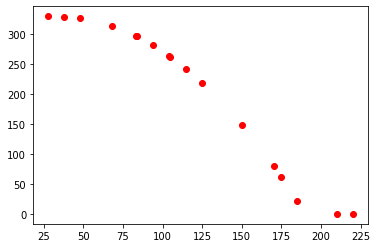

highHIIIIGHHHHHH:  120.0
rewaRD::  -68.0482673869066
returned state: [220.]
observation space:  (18,)
stepping:  17
ACTION            :  0
curtemp:  221.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.88253407811516
chisqds:  11.688612274920219
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


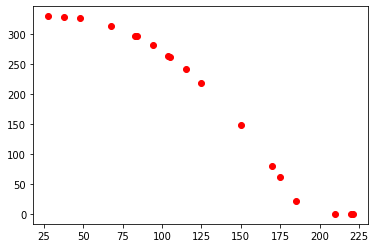

highHIIIIGHHHHHH:  119.0
rewaRD::  -65.77865784304748
returned state: [221.]
observation space:  (19,)
stepping:  17
ACTION            :  3
curtemp:  236.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 327.3797253622242
chisqds:  10.954474081485563
BUT ARE WE SURE?: nan


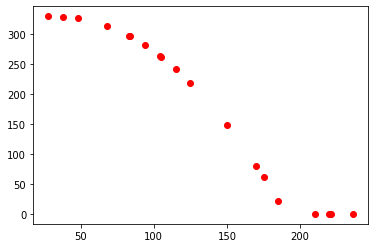

highHIIIIGHHHHHH:  104.0
rewaRD::  -63.48523927076972
returned state: [236.]
observation space:  (20,)
stepping:  17
ACTION            :  2
curtemp:  246.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.84991809880455
chisqds:  10.319119458838586
BUT ARE WE SURE?: 52768555.44103097


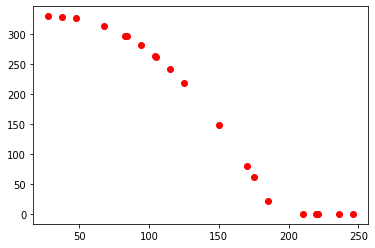

highHIIIIGHHHHHH:  94.0
rewaRD::  -61.23700267299552
returned state: [246.]
observation space:  (21,)
stepping:  17
ACTION            :  4
curtemp:  266.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 326.22735719602747
chisqds:  9.742992859854546
BUT ARE WE SURE?: 9.327247008960463e-09


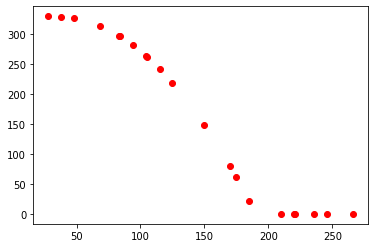

highHIIIIGHHHHHH:  74.0
rewaRD::  -58.94485341889374
returned state: [266.]
observation space:  (22,)
stepping:  17
ACTION            :  5
curtemp:  291.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266. 291.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.4051937948588
chisqds:  9.236657438786281
BUT ARE WE SURE?: 8.89282103384615e-09


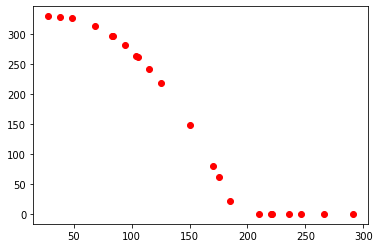

highHIIIIGHHHHHH:  49.0
rewaRD::  -56.69429091087295
returned state: [291.]
observation space:  (23,)
stepping:  17
ACTION            :  0
curtemp:  292.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266. 291. 292.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 326.50267379324026
chisqds:  8.767102492140918
BUT ARE WE SURE?: 1.001389735244098e-08


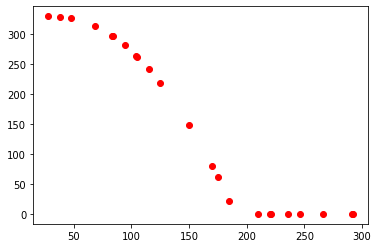

highHIIIIGHHHHHH:  48.0
rewaRD::  -54.374891777691495
returned state: [292.]
observation space:  (24,)
stepping:  17
ACTION            :  5
curtemp:  317.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266. 291. 292. 317.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.8420442572424
chisqds:  8.35362813442212
BUT ARE WE SURE?: 9.778763509451766e-09


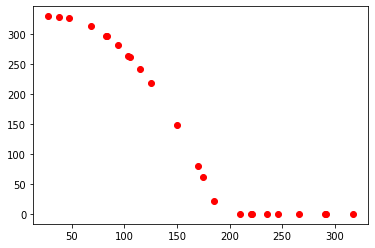

highHIIIIGHHHHHH:  23.0
rewaRD::  -52.11661405518492
returned state: [317.]
observation space:  (25,)
stepping:  17
ACTION            :  2
curtemp:  327.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266. 291. 292. 317. 327.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 326.13620085088723
chisqds:  7.972064957895211
BUT ARE WE SURE?: 1.08581301000976e-08


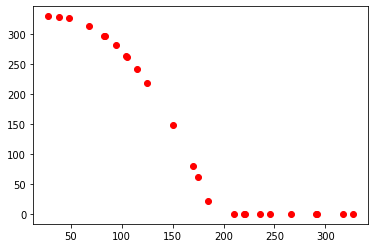

highHIIIIGHHHHHH:  13.0
rewaRD::  -49.82479418913211
returned state: [327.]
observation space:  (26,)
stepping:  17
ACTION            :  6
curtemp:  357.0
Temperature:  [ 28.  38.  48.  68.  83.  84.  94. 104. 105. 115. 125. 150. 170. 175.
 185. 210. 220. 221. 236. 246. 266. 291. 292. 317. 327. 357.]
Intensity:  [3.30202215e+02 3.29380817e+02 3.26849674e+02 3.14345933e+02
 2.97850344e+02 2.96533270e+02 2.81878082e+02 2.64528837e+02
 2.62645579e+02 2.42322612e+02 2.19269710e+02 1.49453456e+02
 8.07442730e+01 6.17431851e+01 2.15246015e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 326.44624469580987
chisqds:  7.623834535483292
BUT ARE WE SURE?: 52088707.71174975


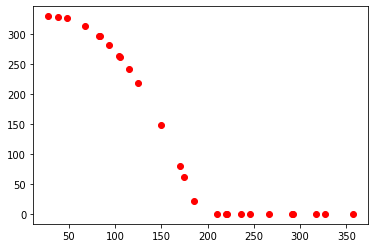

highHIIIIGHHHHHH:  -17.0
rewaRD::  -47.53296413526594
terminated: over max temp
returned state: [357.]
observation space:  (27,)
reset
fixed Tn:  80
fixed Jt:  0.7
fixed Nf:  330
stepping:  18
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  18
ACTION            :  4
curtemp:  24.0
Temperature:  [ 4. 24.]
highHIIIIGHHHHHH:  316.0
rewaRD::  -100
returned state: [24.]
observation space:  (3,)
stepping:  18
ACTION            :  3
curtemp:  39.0
Temperature:  [ 4. 24. 39.]
highHIIIIGHHHHHH:  301.0
rewaRD::  -100
returned state: [39.]
observation space:  (4,)
stepping:  18
ACTION            :  6
curtemp:  69.0
Temperature:  [ 4. 24. 39. 69.]
Intensity:  [330.3        327.60668524 300.78075995 116.30974489]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.7093781352866
chisqds:  120.93121680486523
BUT ARE WE SURE?: 2.542715090442472e-09


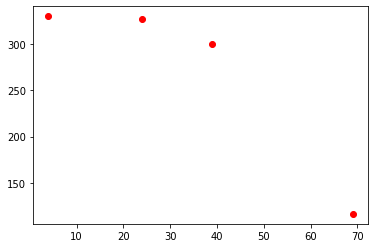

highHIIIIGHHHHHH:  271.0
rewaRD::  -96.69233461327491
returned state: [69.]
observation space:  (5,)
stepping:  18
ACTION            :  6
curtemp:  99.0
Temperature:  [ 4. 24. 39. 69. 99.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 350.0883661970329
chisqds:  60.30230520697902
BUT ARE WE SURE?: 3.2268340674432907


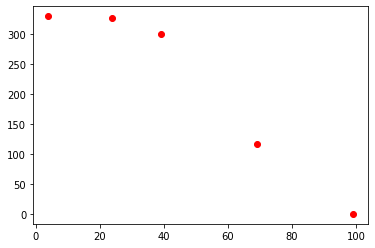

highHIIIIGHHHHHH:  241.0
rewaRD::  -93.36675441134369
returned state: [99.]
observation space:  (6,)
stepping:  18
ACTION            :  3
curtemp:  114.0
Temperature:  [  4.  24.  39.  69.  99. 114.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 350.90685456763237
chisqds:  40.217123001902856
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


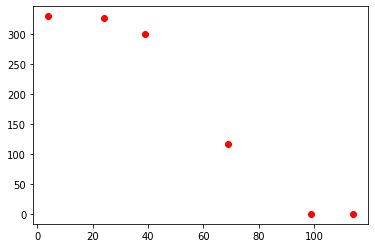

highHIIIIGHHHHHH:  226.0
rewaRD::  -90.05398770118205
returned state: [114.]
observation space:  (7,)
stepping:  18
ACTION            :  3
curtemp:  129.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 340.6357557806855
chisqds:  30.20819534178106
BUT ARE WE SURE?: 3.316378412806638


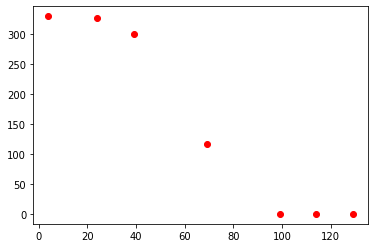

highHIIIIGHHHHHH:  211.0
rewaRD::  -86.75856020280833
returned state: [129.]
observation space:  (8,)
stepping:  18
ACTION            :  1
curtemp:  134.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 360.6320799420232
chisqds:  24.403652503986624
BUT ARE WE SURE?: 1.7574523484212776e-10


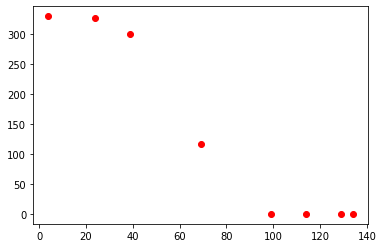

highHIIIIGHHHHHH:  206.0
rewaRD::  -83.60901098986493
returned state: [134.]
observation space:  (9,)
stepping:  18
ACTION            :  2
curtemp:  144.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 335.7138739118147
chisqds:  20.25189471026024
BUT ARE WE SURE?: 3.364999646108903


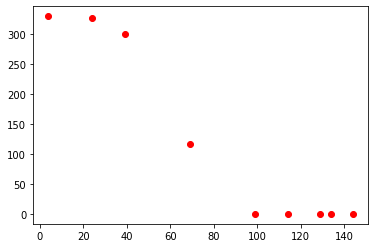

highHIIIIGHHHHHH:  196.0
rewaRD::  -80.24876162340763
returned state: [144.]
observation space:  (10,)
stepping:  18
ACTION            :  5
curtemp:  169.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 329.97955631321224
chisqds:  17.54077806217762
BUT ARE WE SURE?: 3.42347592520129


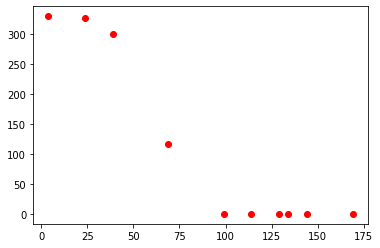

highHIIIIGHHHHHH:  171.0
rewaRD::  -77.19599446603218
returned state: [169.]
observation space:  (11,)
stepping:  18
ACTION            :  1
curtemp:  174.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 345.3165121218485
chisqds:  15.067883833035717
BUT ARE WE SURE?: 1.3855751381944686e-09


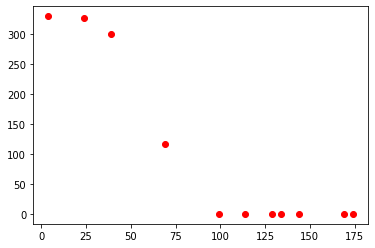

highHIIIIGHHHHHH:  166.0
rewaRD::  -73.45347200493964
returned state: [174.]
observation space:  (12,)
stepping:  18
ACTION            :  4
curtemp:  194.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 336.025444182688
chisqds:  13.49522737074754
BUT ARE WE SURE?: 3.3618795432316806


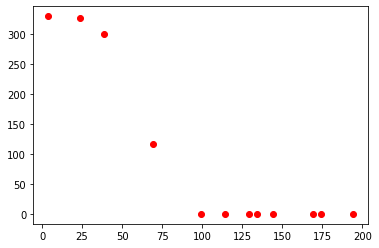

highHIIIIGHHHHHH:  146.0
rewaRD::  -70.35989175943445
returned state: [194.]
observation space:  (13,)
stepping:  18
ACTION            :  4
curtemp:  214.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 429.3537885895437
chisqds:  17.433160674591118
BUT ARE WE SURE?: 2.6311100458486


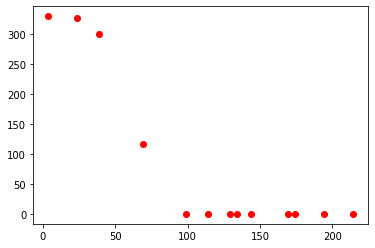

highHIIIIGHHHHHH:  126.0
rewaRD::  -77.05522208700795
returned state: [214.]
observation space:  (14,)
stepping:  18
ACTION            :  0
curtemp:  215.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 410.068337763497
chisqds:  13.827946681985766
BUT ARE WE SURE?: 6.723038651009322e-09


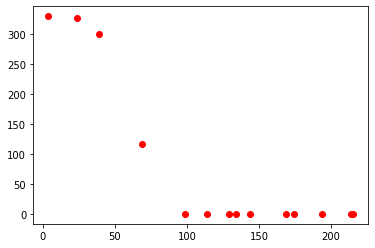

highHIIIIGHHHHHH:  125.0
rewaRD::  -71.07307330588016
returned state: [215.]
observation space:  (15,)
stepping:  18
ACTION            :  5
curtemp:  240.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 310.22323857429575
chisqds:  10.929963596705337
BUT ARE WE SURE?: 7.1737525296989065e-09


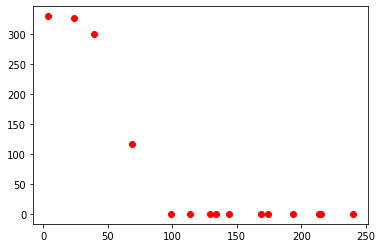

highHIIIIGHHHHHH:  100.0
rewaRD::  -63.40335478147671
returned state: [240.]
observation space:  (16,)
stepping:  18
ACTION            :  2
curtemp:  250.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 335.942940691081
chisqds:  9.343944707480576
BUT ARE WE SURE?: 3.3627051804305905


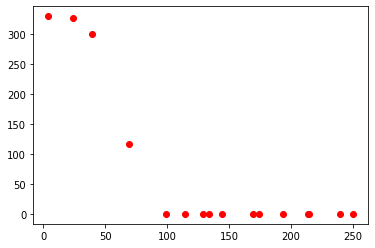

highHIIIIGHHHHHH:  90.0
rewaRD::  -57.19152750553329
returned state: [250.]
observation space:  (17,)
stepping:  18
ACTION            :  3
curtemp:  265.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250. 265.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 333.83867716326284
chisqds:  8.70505366941906
BUT ARE WE SURE?: 3.383901100202362


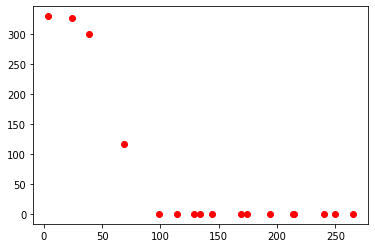

highHIIIIGHHHHHH:  75.0
rewaRD::  -54.04968019838821
returned state: [265.]
observation space:  (18,)
stepping:  18
ACTION            :  3
curtemp:  280.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250. 265. 280.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 394.4591253366083
chisqds:  9.228614670546516
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


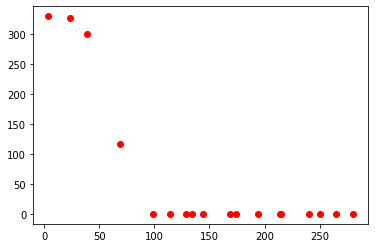

highHIIIIGHHHHHH:  60.0
rewaRD::  -56.65654984202389
returned state: [280.]
observation space:  (19,)
stepping:  18
ACTION            :  5
curtemp:  305.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250. 265. 280. 305.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 340.4561154981489
chisqds:  7.553175518434245
BUT ARE WE SURE?: 8.475509440500349e-10


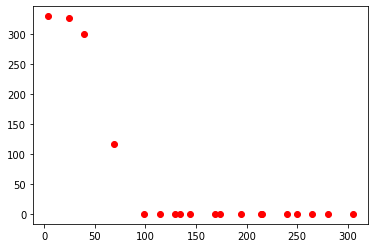

highHIIIIGHHHHHH:  35.0
rewaRD::  -47.04214154381003
returned state: [305.]
observation space:  (20,)
stepping:  18
ACTION            :  5
curtemp:  330.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250. 265. 280. 305. 330.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 335.1741916627879
chisqds:  7.15347624333313
BUT ARE WE SURE?: 2.816971492554623e-09


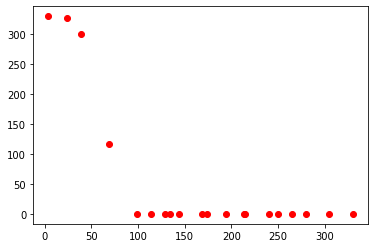

highHIIIIGHHHHHH:  10.0
rewaRD::  -44.083130160278294
returned state: [330.]
observation space:  (21,)
stepping:  18
ACTION            :  4
curtemp:  350.0
Temperature:  [  4.  24.  39.  69.  99. 114. 129. 134. 144. 169. 174. 194. 214. 215.
 240. 250. 265. 280. 305. 330. 350.]
Intensity:  [3.30300000e+02 3.27606685e+02 3.00780760e+02 1.16309745e+02
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.940156288390395
THE NF RESULT {X1}: 421.028700289192
chisqds:  8.722695297310425
BUT ARE WE SURE?: 1.3097993091097005e-09


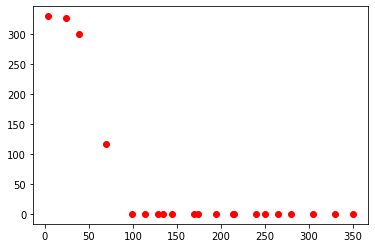

highHIIIIGHHHHHH:  -10.0
rewaRD::  -54.14261459719488
terminated: over max temp
returned state: [350.]
observation space:  (22,)
reset
fixed Tn:  240
fixed Jt:  0.9
fixed Nf:  330
stepping:  19
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
stepping:  19
ACTION            :  6
curtemp:  34.0
Temperature:  [ 4. 34.]
highHIIIIGHHHHHH:  306.0
rewaRD::  -100
returned state: [34.]
observation space:  (3,)
stepping:  19
ACTION            :  3
curtemp:  49.0
Temperature:  [ 4. 34. 49.]
highHIIIIGHHHHHH:  291.0
rewaRD::  -100
returned state: [49.]
observation space:  (4,)
stepping:  19
ACTION            :  1
curtemp:  54.0
Temperature:  [ 4. 34. 49. 54.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 265.0868758215853
chisqds:  50.796113936427396
BUT ARE WE SURE?: 5.843417387440694e-10


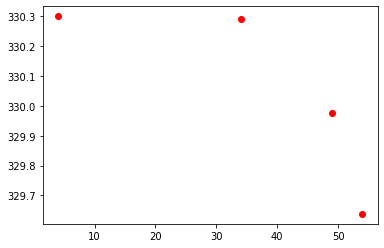

highHIIIIGHHHHHH:  286.0
rewaRD::  -92.12538186482907
returned state: [54.]
observation space:  (5,)
stepping:  19
ACTION            :  4
curtemp:  74.0
Temperature:  [ 4. 34. 49. 54. 74.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 352.9772302084267
chisqds:  4.1586542591186895
BUT ARE WE SURE?: 90.27129075797406


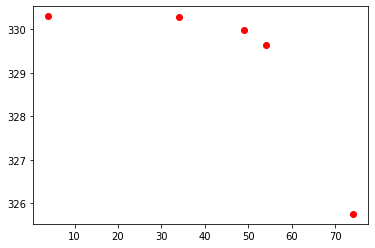

highHIIIIGHHHHHH:  266.0
rewaRD::  -3.8150384531440125
returned state: [74.]
observation space:  (6,)
stepping:  19
ACTION            :  3
curtemp:  89.0
Temperature:  [ 4. 34. 49. 54. 74. 89.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 332.98354032563384
chisqds:  0.09375812224793968
BUT ARE WE SURE?: 1.305660145227959


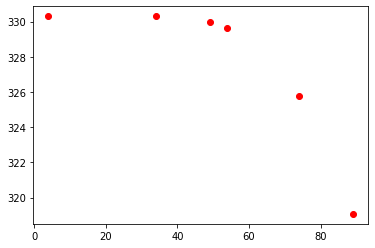

highHIIIIGHHHHHH:  251.0
rewaRD::  300
returned state: [89.]
observation space:  (7,)
stepping:  19
ACTION            :  5
curtemp:  114.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103  ]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 280.2907218610357
chisqds:  12.386863344946214
BUT ARE WE SURE?: 3.4567034754094426e-09


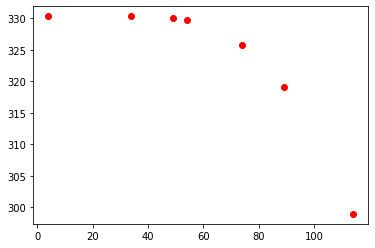

highHIIIIGHHHHHH:  226.0
rewaRD::  -67.70772479998351
returned state: [114.]
observation space:  (8,)
stepping:  19
ACTION            :  5
curtemp:  139.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.065230062321
chisqds:  0.43723203475826955
BUT ARE WE SURE?: 1.9116672082055617


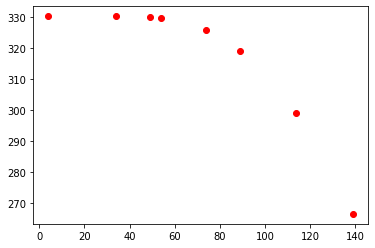

highHIIIIGHHHHHH:  201.0
rewaRD::  300
returned state: [139.]
observation space:  (9,)
stepping:  19
ACTION            :  3
curtemp:  154.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627 240.87347476]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 346.5539570214392
chisqds:  1.1339952721779822
BUT ARE WE SURE?: 1.2400230331437208


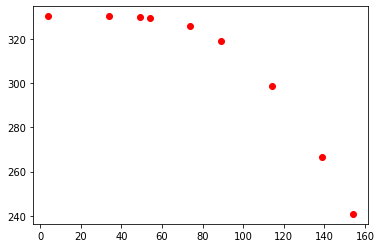

highHIIIIGHHHHHH:  186.0
rewaRD::  252.73515667463857
returned state: [154.]
observation space:  (10,)
stepping:  19
ACTION            :  2
curtemp:  164.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627 240.87347476 221.13606249]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 327.81453104268905
chisqds:  0.2972967734576844
BUT ARE WE SURE?: 0.9983707402013061


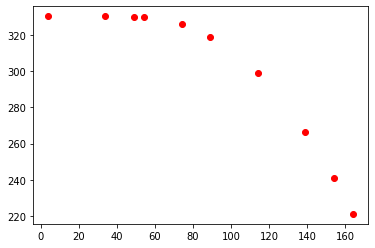

highHIIIIGHHHHHH:  176.0
rewaRD::  300
returned state: [164.]
observation space:  (11,)
stepping:  19
ACTION            :  4
curtemp:  184.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627 240.87347476 221.13606249
 175.24333144]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 332.6535080645219
chisqds:  0.8227215966614357
BUT ARE WE SURE?: 4.817601903521855e-10


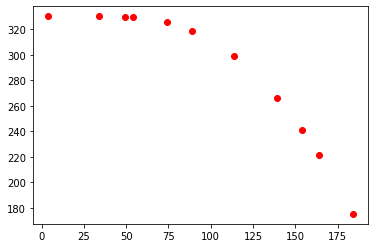

highHIIIIGHHHHHH:  156.0
rewaRD::  300
returned state: [184.]
observation space:  (12,)
stepping:  19
ACTION            :  6
curtemp:  214.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627 240.87347476 221.13606249
 175.24333144  90.11716692]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 1.8543587784772488
THE NF RESULT {X1}: 389.91106320679916
chisqds:  12.330023277917398
BUT ARE WE SURE?: 0.7221608233929118


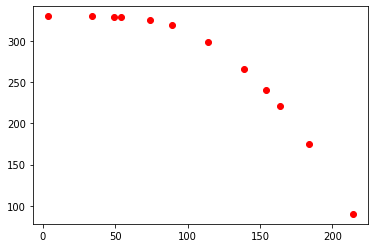

highHIIIIGHHHHHH:  126.0
rewaRD::  -67.55886092150493
returned state: [214.]
observation space:  (13,)
stepping:  19
ACTION            :  5
curtemp:  239.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239.]
Intensity:  [330.3        330.28940873 329.97762775 329.63801334 325.75265939
 319.07603125 298.963103   266.52603627 240.87347476 221.13606249
 175.24333144  90.11716692   4.03225375]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.7153312869754
chisqds:  5.313744965196525
BUT ARE WE SURE?: 6.064333458613289e-09


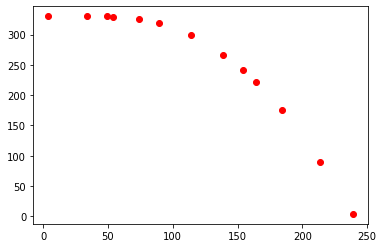

highHIIIIGHHHHHH:  101.0
rewaRD::  -24.72352312354414
returned state: [239.]
observation space:  (14,)
stepping:  19
ACTION            :  2
curtemp:  249.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 280.09905167571003
chisqds:  13.109608935153
BUT ARE WE SURE?: 1.884994342197337e-09


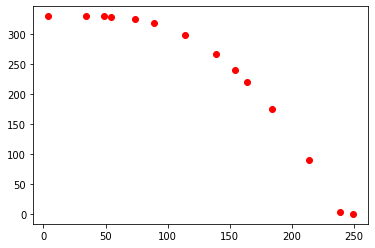

highHIIIIGHHHHHH:  91.0
rewaRD::  -69.48802958359707
returned state: [249.]
observation space:  (15,)
stepping:  19
ACTION            :  2
curtemp:  259.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 319.16669515932944
chisqds:  5.152575932164665
BUT ARE WE SURE?: 6.900046498229909e-09


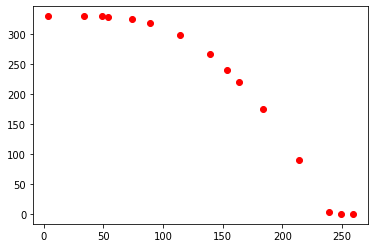

highHIIIIGHHHHHH:  81.0
rewaRD::  -22.368926675486236
returned state: [259.]
observation space:  (16,)
stepping:  19
ACTION            :  5
curtemp:  284.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259. 284.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 392.2940251989718
chisqds:  10.681080354490247
BUT ARE WE SURE?: 2.7564470446985294e-09


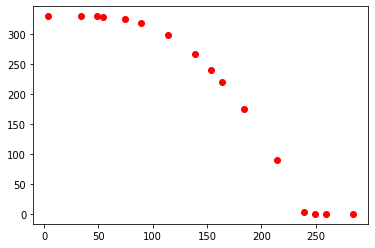

highHIIIIGHHHHHH:  56.0
rewaRD::  -62.550604739918185
returned state: [284.]
observation space:  (17,)
stepping:  19
ACTION            :  1
curtemp:  289.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259. 284. 289.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 301.92987927658027
chisqds:  6.255043322197747
BUT ARE WE SURE?: 5.891231805612491e-10


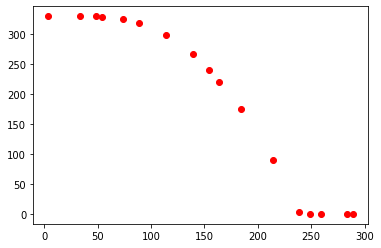

highHIIIIGHHHHHH:  51.0
rewaRD::  -36.051601980039116
returned state: [289.]
observation space:  (18,)
stepping:  19
ACTION            :  2
curtemp:  299.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259. 284. 289. 299.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 425.7260138036191
chisqds:  18.297493821484043
BUT ARE WE SURE?: 8.975103213640257e-10


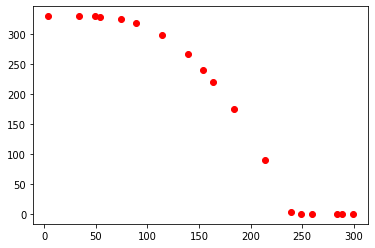

highHIIIIGHHHHHH:  41.0
rewaRD::  -78.13908265784798
returned state: [299.]
observation space:  (19,)
stepping:  19
ACTION            :  5
curtemp:  324.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259. 284. 289. 299. 324.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.88974031117993
chisqds:  3.3682735699470143
BUT ARE WE SURE?: 8.24620106154212e-09


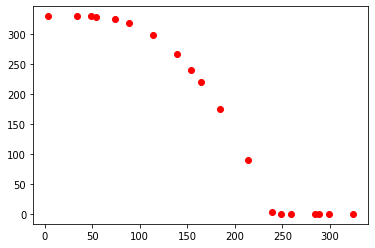

highHIIIIGHHHHHH:  16.0
rewaRD::  18.75519956839264
returned state: [324.]
observation space:  (20,)
stepping:  19
ACTION            :  4
curtemp:  344.0
Temperature:  [  4.  34.  49.  54.  74.  89. 114. 139. 154. 164. 184. 214. 239. 249.
 259. 284. 289. 299. 324. 344.]
Intensity:  [3.30300000e+02 3.30289409e+02 3.29977628e+02 3.29638013e+02
 3.25752659e+02 3.19076031e+02 2.98963103e+02 2.66526036e+02
 2.40873475e+02 2.21136062e+02 1.75243331e+02 9.01171669e+01
 4.03225375e+00 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 220.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.6266970277437
chisqds:  3.1756206707911097
BUT ARE WE SURE?: 8.409424074889682e-09


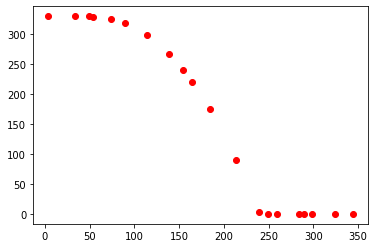

highHIIIIGHHHHHH:  -4.0
rewaRD::  25.9596285158177
terminated: over max temp
returned state: [344.]
observation space:  (21,)
reset
fixed Tn:  280
fixed Jt:  0.7
fixed Nf:  330
stepping:  20
ACTION            :  0
curtemp:  4.0
Temperature:  [4.]
highHIIIIGHHHHHH:  336.0
rewaRD::  -100
returned state: [4.]
observation space:  (2,)
---------------------------------------
| approxkl           | 3.77759e-05    |
| clipfrac           | 0.0            |
| ep_len_mean        | 19.5           |
| ep_reward_mean     | -773           |
| explained_variance | -1.06e-05      |
| fps                | 3              |
| n_updates          | 3              |
| policy_entropy     | 1.9446651      |
| policy_loss        | -0.00021829875 |
| serial_timesteps   | 384            |
| time_elapsed       | 195            |
| total_timesteps    | 384            |
| value_loss         | 102112.67      |
---------------------------------------
stepping:  20
ACTION            :  5
curtemp:  29.0
Temperature:  [

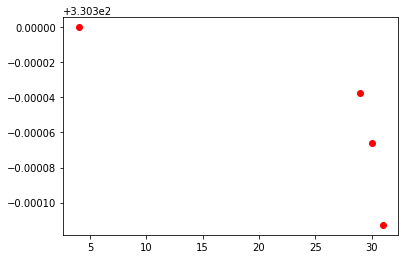

highHIIIIGHHHHHH:  309.0
rewaRD::  -98.04556083722952
returned state: [31.]
observation space:  (5,)
stepping:  20
ACTION            :  0
curtemp:  32.0
Temperature:  [ 4. 29. 30. 31. 32.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.471278526905482
THE NF RESULT {X1}: 200.0000125138592
chisqds:  127.91391053005076
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


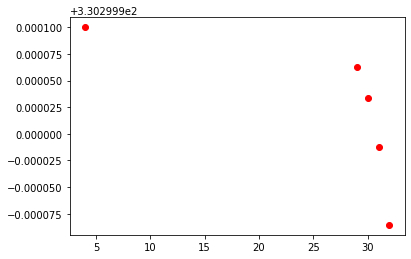

highHIIIIGHHHHHH:  308.0
rewaRD::  -96.8728967917369
returned state: [32.]
observation space:  (6,)
stepping:  20
ACTION            :  1
curtemp:  37.0
Temperature:  [ 4. 29. 30. 31. 32. 37.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.4635319372355134
THE NF RESULT {X1}: 200.00013467132405
chisqds:  102.33075556562595
BUT ARE WE SURE?: 75492.30171247887


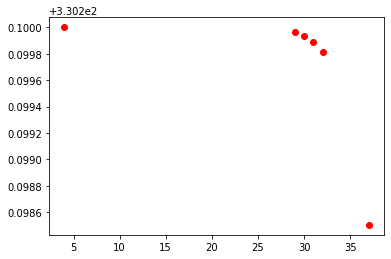

highHIIIIGHHHHHH:  303.0
rewaRD::  -96.09110674704756
returned state: [37.]
observation space:  (7,)
stepping:  20
ACTION            :  3
curtemp:  52.0
Temperature:  [ 4. 29. 30. 31. 32. 37. 52.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.5255161490347814
THE NF RESULT {X1}: 273.78616576250346
chisqds:  16.74156728483142
BUT ARE WE SURE?: 26540.201531356663


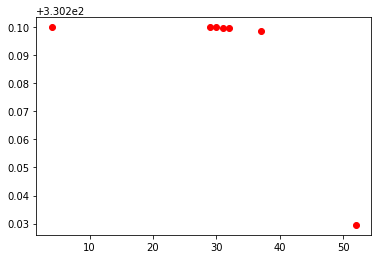

highHIIIIGHHHHHH:  288.0
rewaRD::  -76.10737434586443
returned state: [52.]
observation space:  (8,)
stepping:  20
ACTION            :  3
curtemp:  67.0
Temperature:  [ 4. 29. 30. 31. 32. 37. 52. 67.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 336.1555345352656
chisqds:  0.18523305813584967
BUT ARE WE SURE?: 760.1803824488572


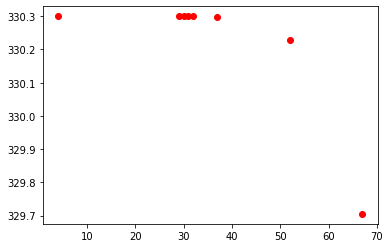

highHIIIIGHHHHHH:  273.0
rewaRD::  300
returned state: [67.]
observation space:  (9,)
stepping:  20
ACTION            :  4
curtemp:  87.0
Temperature:  [ 4. 29. 30. 31. 32. 37. 52. 67. 87.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 321.71714995415556
chisqds:  0.3050632629477754
BUT ARE WE SURE?: 75.84854492847296


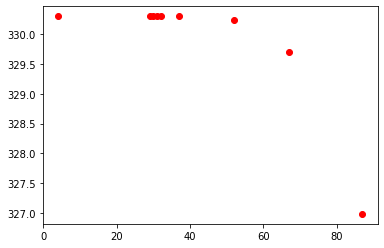

highHIIIIGHHHHHH:  253.0
rewaRD::  300
returned state: [87.]
observation space:  (10,)
stepping:  20
ACTION            :  3
curtemp:  102.0
Temperature:  [  4.  29.  30.  31.  32.  37.  52.  67.  87. 102.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975 322.43738738]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 344.94537231094614
chisqds:  0.981495812316623
BUT ARE WE SURE?: 4.569363870835809e-09


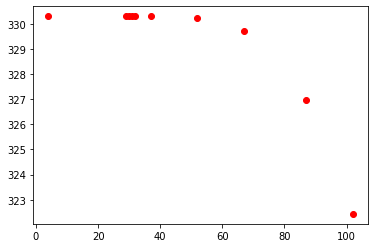

highHIIIIGHHHHHH:  238.0
rewaRD::  300
returned state: [102.]
observation space:  (11,)
stepping:  20
ACTION            :  2
curtemp:  112.0
Temperature:  [  4.  29.  30.  31.  32.  37.  52.  67.  87. 102. 112.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975 322.43738738
 317.88203788]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 273.62628670486305
chisqds:  13.07897763378701
BUT ARE WE SURE?: 13.46205356154214


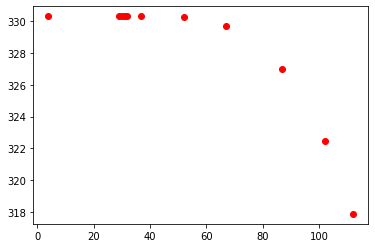

highHIIIIGHHHHHH:  228.0
rewaRD::  -69.41656976561552
returned state: [112.]
observation space:  (12,)
stepping:  20
ACTION            :  0
curtemp:  113.0
Temperature:  [  4.  29.  30.  31.  32.  37.  52.  67.  87. 102. 112. 113.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975 322.43738738
 317.88203788 317.35326106]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 288.5929362253787
chisqds:  6.804823926356146
BUT ARE WE SURE?: 5.10534735519432e-09


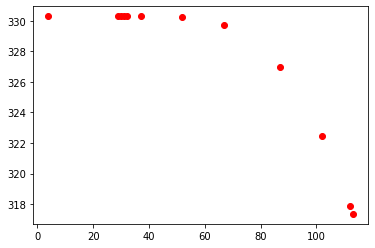

highHIIIIGHHHHHH:  227.0
rewaRD::  -41.2181704730467
returned state: [113.]
observation space:  (13,)
stepping:  20
ACTION            :  0
curtemp:  114.0
Temperature:  [  4.  29.  30.  31.  32.  37.  52.  67.  87. 102. 112. 113. 114.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975 322.43738738
 317.88203788 317.35326106 316.81073252]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 355.2398544827048
chisqds:  2.5179245748730135
BUT ARE WE SURE?: 5.997431898911949e-09


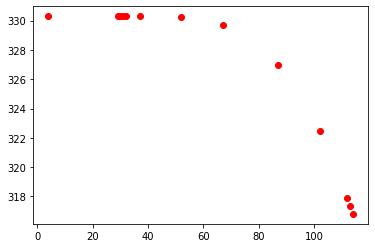

highHIIIIGHHHHHH:  226.0
rewaRD::  58.86099368968317
returned state: [114.]
observation space:  (14,)
stepping:  20
ACTION            :  2
curtemp:  124.0
Temperature:  [  4.  29.  30.  31.  32.  37.  52.  67.  87. 102. 112. 113. 114. 124.]
Intensity:  [330.3        330.29996244 330.29993372 330.29988725 330.29981446
 330.29850493 330.22951219 329.70501762 326.98613975 322.43738738
 317.88203788 317.35326106 316.81073252 310.60845904]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 327.7174361441956
chisqds:  0.017432708113610054
BUT ARE WE SURE?: 6.038921636168343e-09


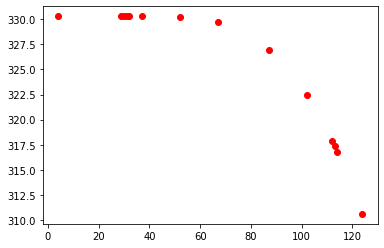

highHIIIIGHHHHHH:  216.0
rewaRD::  300
terminated: excellent conditions
returned state: [124.]
observation space:  (15,)
reset
fixed Tn:  260
fixed Jt:  0.7
fixed Nf:  330
stepping:  21
ACTION            :  5
curtemp:  28.0
Temperature:  [28.]
highHIIIIGHHHHHH:  312.0
rewaRD::  -100
returned state: [28.]
observation space:  (2,)
stepping:  21
ACTION            :  2
curtemp:  38.0
Temperature:  [28. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (3,)
stepping:  21
ACTION            :  1
curtemp:  43.0
Temperature:  [28. 38. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
returned state: [43.]
observation space:  (4,)
stepping:  21
ACTION            :  6
curtemp:  73.0
Temperature:  [28. 38. 43. 73.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 352.81436564686015
chisqds:  6.346885106372002
BUT ARE WE SURE?: 1.5541843453054013e-10


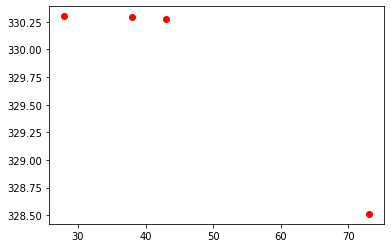

highHIIIIGHHHHHH:  267.0
rewaRD::  -36.97695904430079
returned state: [73.]
observation space:  (5,)
stepping:  21
ACTION            :  2
curtemp:  83.0
Temperature:  [28. 38. 43. 73. 83.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 321.91694890424685
chisqds:  0.4742289102205005
BUT ARE WE SURE?: 1.886858993969975e-10


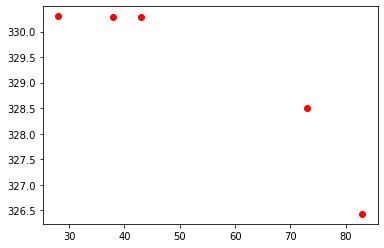

highHIIIIGHHHHHH:  257.0
rewaRD::  300
returned state: [83.]
observation space:  (6,)
stepping:  21
ACTION            :  5
curtemp:  108.0
Temperature:  [ 28.  38.  43.  73.  83. 108.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 275.31314103238765
chisqds:  17.870042128229883
BUT ARE WE SURE?: 3.177392189714308e-09


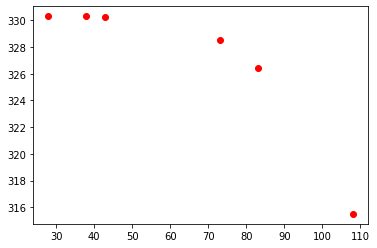

highHIIIIGHHHHHH:  232.0
rewaRD::  -77.61616916570627
returned state: [108.]
observation space:  (7,)
stepping:  21
ACTION            :  0
curtemp:  109.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 357.53153013811516
chisqds:  3.9650196734786625
BUT ARE WE SURE?: 3.510928392467969e-09


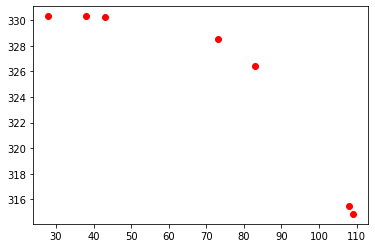

highHIIIIGHHHHHH:  231.0
rewaRD::  0.88222327761234
returned state: [109.]
observation space:  (8,)
stepping:  21
ACTION            :  6
curtemp:  139.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 323.2110458124795
chisqds:  0.2714231013330349
BUT ARE WE SURE?: 3.973668952268536e-09


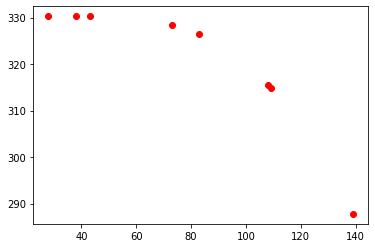

highHIIIIGHHHHHH:  201.0
rewaRD::  300
returned state: [139.]
observation space:  (9,)
stepping:  21
ACTION            :  5
curtemp:  164.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.2835016347711
chisqds:  0.2294544789643641
BUT ARE WE SURE?: 4.480873756936505e-09


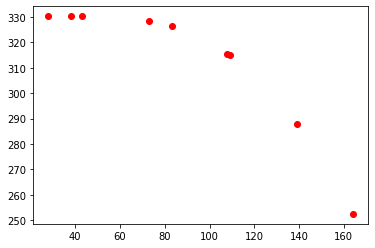

highHIIIIGHHHHHH:  176.0
rewaRD::  300
returned state: [164.]
observation space:  (10,)
stepping:  21
ACTION            :  3
curtemp:  179.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.3038322551136
chisqds:  0.36684701927912217
BUT ARE WE SURE?: 0.9610168070302529


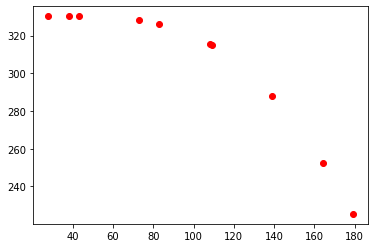

highHIIIIGHHHHHH:  161.0
rewaRD::  300
returned state: [179.]
observation space:  (11,)
stepping:  21
ACTION            :  6
curtemp:  209.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719
 157.7464643 ]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.7368710428381959
THE NF RESULT {X1}: 349.62242010960733
chisqds:  2.493067948312375
BUT ARE WE SURE?: 0.48714025424521373


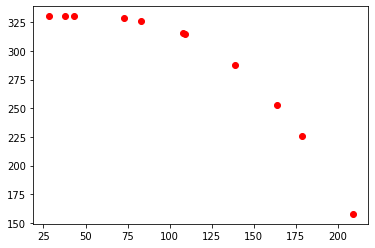

highHIIIIGHHHHHH:  131.0
rewaRD::  60.4448848940402
returned state: [209.]
observation space:  (12,)
stepping:  21
ACTION            :  6
curtemp:  239.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719
 157.7464643   71.66465081]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 446.4159151613424
chisqds:  45.13232420532252
BUT ARE WE SURE?: 5.425756782701508e-09


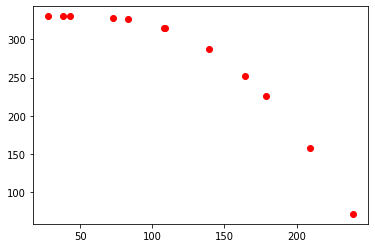

highHIIIIGHHHHHH:  101.0
rewaRD::  -91.13717259097356
returned state: [239.]
observation space:  (13,)
stepping:  21
ACTION            :  1
curtemp:  244.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719
 157.7464643   71.66465081  55.50640263]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 299.23383379266363
chisqds:  17.00851512624901
BUT ARE WE SURE?: 0.3369315773602327


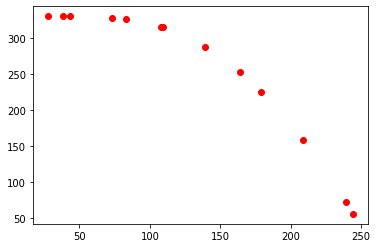

highHIIIIGHHHHHH:  96.0
rewaRD::  -76.48236797680913
returned state: [244.]
observation space:  (14,)
stepping:  21
ACTION            :  0
curtemp:  245.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719
 157.7464643   71.66465081  55.50640263  52.2123569 ]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 453.9224884488447
chisqds:  50.91547810393454
BUT ARE WE SURE?: 0.22211133121897067


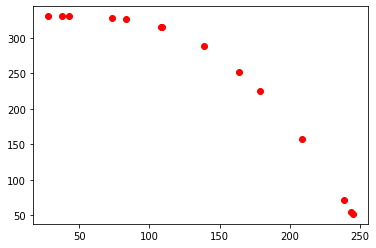

highHIIIIGHHHHHH:  95.0
rewaRD::  -92.14384279799015
returned state: [245.]
observation space:  (15,)
stepping:  21
ACTION            :  1
curtemp:  250.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250.]
Intensity:  [330.29992791 330.29462119 330.27809499 328.51239266 326.42898348
 315.50571859 314.87113783 287.78024768 252.45878984 225.40803719
 157.7464643   71.66465081  55.50640263  52.2123569   35.42974791]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 424.6405924996945
chisqds:  35.66869151959131
BUT ARE WE SURE?: 0.2374274372247712


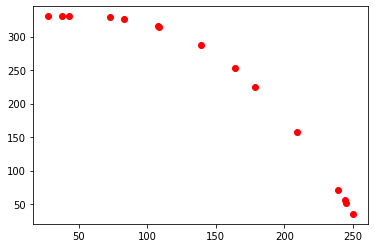

highHIIIIGHHHHHH:  90.0
rewaRD::  -88.78568338341492
returned state: [250.]
observation space:  (16,)
stepping:  21
ACTION            :  4
curtemp:  270.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 319.44187000463614
chisqds:  17.27987297391639
BUT ARE WE SURE?: 8.236241763621993e-10


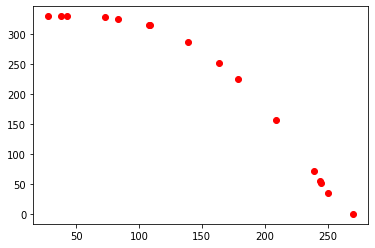

highHIIIIGHHHHHH:  70.0
rewaRD::  -76.85168168748743
returned state: [270.]
observation space:  (17,)
stepping:  21
ACTION            :  4
curtemp:  290.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 348.2685642877485
chisqds:  15.623099398696407
BUT ARE WE SURE?: 0.2894930463356393


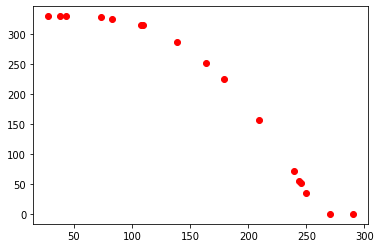

highHIIIIGHHHHHH:  50.0
rewaRD::  -74.39688567600254
returned state: [290.]
observation space:  (18,)
stepping:  21
ACTION            :  2
curtemp:  300.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 399.0535875805213
chisqds:  21.43437717875372
BUT ARE WE SURE?: 3.2306226009438856e-09


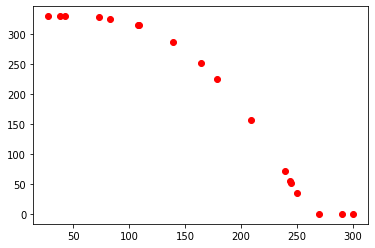

highHIIIIGHHHHHH:  40.0
rewaRD::  -81.33838941695541
returned state: [300.]
observation space:  (19,)
stepping:  21
ACTION            :  0
curtemp:  301.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300. 301.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 309.82507552458077
chisqds:  14.810244164892831
BUT ARE WE SURE?: 4.98306023075896e-10


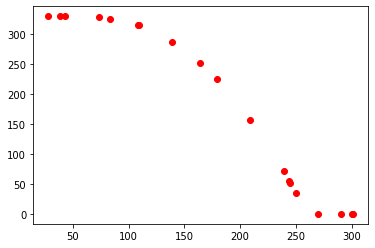

highHIIIIGHHHHHH:  39.0
rewaRD::  -72.99166741975895
returned state: [301.]
observation space:  (20,)
stepping:  21
ACTION            :  0
curtemp:  302.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300. 301. 302.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 471.1412834679092
chisqds:  42.08549321148482
BUT ARE WE SURE?: 0.21399382978382675


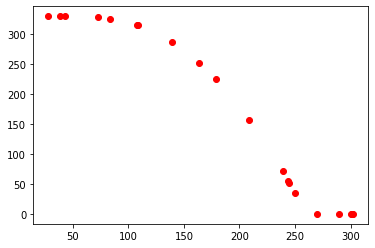

highHIIIIGHHHHHH:  38.0
rewaRD::  -90.49553731044685
returned state: [302.]
observation space:  (21,)
stepping:  21
ACTION            :  3
curtemp:  317.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300. 301. 302. 317.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 361.95076548199364
chisqds:  12.900116925990504
BUT ARE WE SURE?: 1.6599245141886747e-09


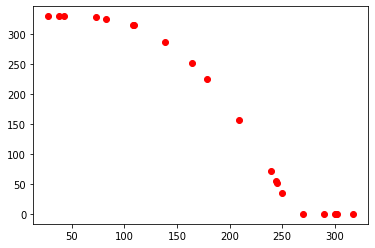

highHIIIIGHHHHHH:  23.0
rewaRD::  -68.99252911467025
returned state: [317.]
observation space:  (22,)
stepping:  21
ACTION            :  1
curtemp:  322.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300. 301. 302. 317. 322.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.23359723941695
chisqds:  11.419688429248627
BUT ARE WE SURE?: 0.30530305959549575


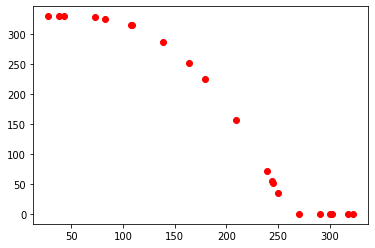

highHIIIIGHHHHHH:  18.0
rewaRD::  -64.97277465333451
returned state: [322.]
observation space:  (23,)
stepping:  21
ACTION            :  6
curtemp:  352.0
Temperature:  [ 28.  38.  43.  73.  83. 108. 109. 139. 164. 179. 209. 239. 244. 245.
 250. 270. 290. 300. 301. 302. 317. 322. 352.]
Intensity:  [3.30299928e+02 3.30294621e+02 3.30278095e+02 3.28512393e+02
 3.26428983e+02 3.15505719e+02 3.14871138e+02 2.87780248e+02
 2.52458790e+02 2.25408037e+02 1.57746464e+02 7.16646508e+01
 5.55064026e+01 5.22123569e+01 3.54297479e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 240.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 332.5369346329946
chisqds:  10.809142400601607
BUT ARE WE SURE?: 8.69826599856097e-10


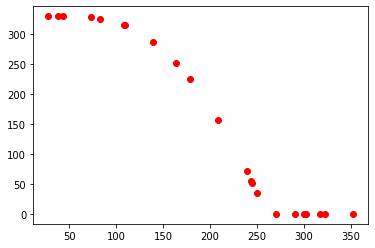

highHIIIIGHHHHHH:  -12.0
rewaRD::  -62.994288984689746
terminated: over max temp
returned state: [352.]
observation space:  (24,)
reset
fixed Tn:  40
fixed Jt:  1.0
fixed Nf:  330
stepping:  22
ACTION            :  2
curtemp:  13.0
Temperature:  [13.]
highHIIIIGHHHHHH:  327.0
rewaRD::  -100
returned state: [13.]
observation space:  (2,)
stepping:  22
ACTION            :  0
curtemp:  14.0
Temperature:  [13. 14.]
highHIIIIGHHHHHH:  326.0
rewaRD::  -100
returned state: [14.]
observation space:  (3,)
stepping:  22
ACTION            :  6
curtemp:  44.0
Temperature:  [13. 14. 44.]
highHIIIIGHHHHHH:  296.0
rewaRD::  -100
returned state: [44.]
observation space:  (4,)
stepping:  22
ACTION            :  4
curtemp:  64.0
Temperature:  [13. 14. 44. 64.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7101272379436
chisqds:  2.4332738458817564
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


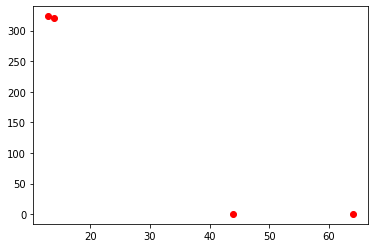

/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


highHIIIIGHHHHHH:  276.0
rewaRD::  64.3875804102313
returned state: [64.]
observation space:  (5,)
stepping:  22
ACTION            :  1
curtemp:  69.0
Temperature:  [13. 14. 44. 64. 69.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.701465119567
chisqds:  1.2171638145536041
BUT ARE WE SURE?: nan


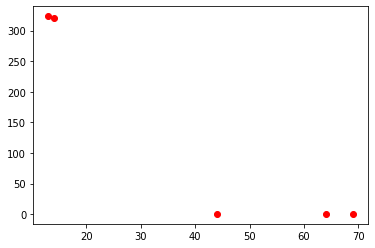

highHIIIIGHHHHHH:  271.0
rewaRD::  228.63283907819778
returned state: [69.]
observation space:  (6,)
stepping:  22
ACTION            :  0
curtemp:  70.0
Temperature:  [13. 14. 44. 64. 69. 70.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7803072926556
chisqds:  0.8082515827499105
BUT ARE WE SURE?: 2603006.8772909334


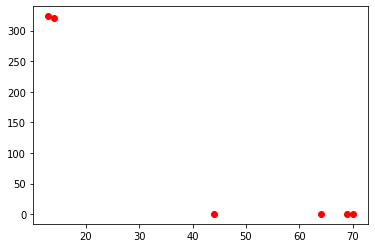

highHIIIIGHHHHHH:  270.0
rewaRD::  300
returned state: [70.]
observation space:  (7,)
stepping:  22
ACTION            :  3
curtemp:  85.0
Temperature:  [13. 14. 44. 64. 69. 70. 85.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.79651512241327
chisqds:  0.6056980001705754
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


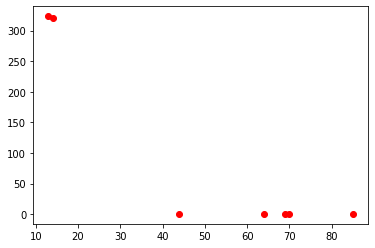

highHIIIIGHHHHHH:  255.0
rewaRD::  300
returned state: [85.]
observation space:  (8,)
stepping:  22
ACTION            :  2
curtemp:  95.0
Temperature:  [13. 14. 44. 64. 69. 70. 85. 95.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7262253076514
chisqds:  0.48626335757003075
BUT ARE WE SURE?: 79557619379.4772


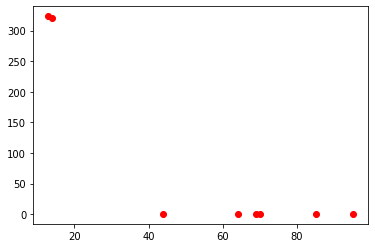

highHIIIIGHHHHHH:  245.0
rewaRD::  300
returned state: [95.]
observation space:  (9,)
stepping:  22
ACTION            :  1
curtemp:  100.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.6861944429002
chisqds:  0.4060310999986245
BUT ARE WE SURE?: 2603591.2627673666


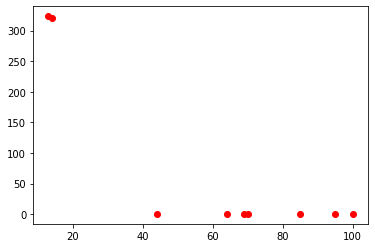

highHIIIIGHHHHHH:  240.0
rewaRD::  300
returned state: [100.]
observation space:  (10,)
stepping:  22
ACTION            :  4
curtemp:  120.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.70329959467705
chisqds:  0.3477292021951956
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


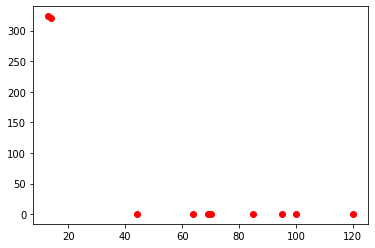

highHIIIIGHHHHHH:  220.0
rewaRD::  300
returned state: [120.]
observation space:  (11,)
stepping:  22
ACTION            :  2
curtemp:  130.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 441.35542932605114
chisqds:  0.17538212747446824
BUT ARE WE SURE?: 1.862595484429924e-10


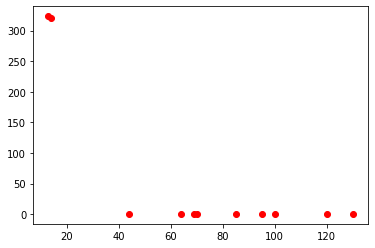

highHIIIIGHHHHHH:  210.0
rewaRD::  300
returned state: [130.]
observation space:  (12,)
stepping:  22
ACTION            :  6
curtemp:  160.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.78496531831956
chisqds:  0.2693544984887141
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


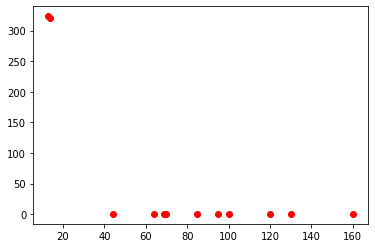

highHIIIIGHHHHHH:  180.0
rewaRD::  300
returned state: [160.]
observation space:  (13,)


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


stepping:  22
ACTION            :  1
curtemp:  165.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.701520009919
chisqds:  0.24343209498760898
BUT ARE WE SURE?: nan


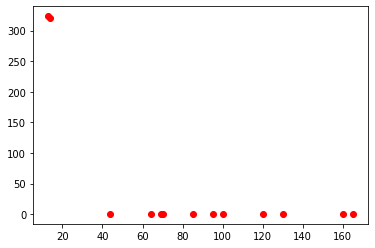

highHIIIIGHHHHHH:  175.0
rewaRD::  300
returned state: [165.]
observation space:  (14,)
stepping:  22
ACTION            :  2
curtemp:  175.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7477443987937
chisqds:  0.22079121930724932
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


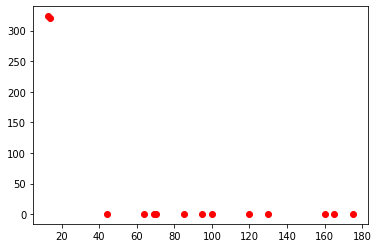

highHIIIIGHHHHHH:  165.0
rewaRD::  300
returned state: [175.]
observation space:  (15,)
stepping:  22
ACTION            :  2
curtemp:  185.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.67322275050964
chisqds:  0.20314724470077705
BUT ARE WE SURE?: 2603671.830209645


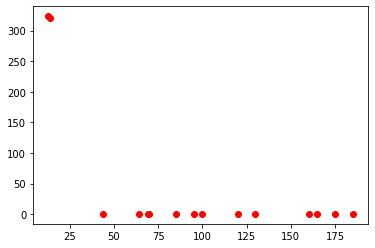

highHIIIIGHHHHHH:  155.0
rewaRD::  300
returned state: [185.]
observation space:  (16,)
stepping:  22
ACTION            :  1
curtemp:  190.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7092231325263
chisqds:  0.1871833700413388
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


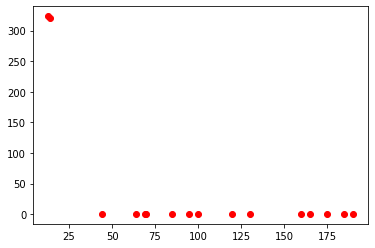

highHIIIIGHHHHHH:  150.0
rewaRD::  300
returned state: [190.]
observation space:  (17,)
stepping:  22
ACTION            :  0
curtemp:  191.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7686766394064
chisqds:  0.17329744957732443
BUT ARE WE SURE?: 2603079.0831621075


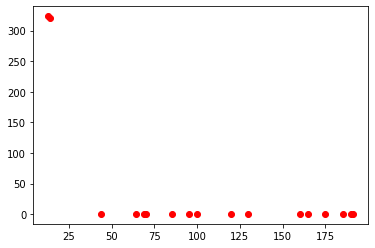

highHIIIIGHHHHHH:  149.0
rewaRD::  300
returned state: [191.]
observation space:  (18,)
stepping:  22
ACTION            :  2
curtemp:  201.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.74563795667603
chisqds:  0.16193060604904866
BUT ARE WE SURE?: 3675221944.730662


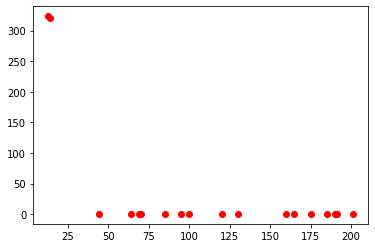

highHIIIIGHHHHHH:  139.0
rewaRD::  300
returned state: [201.]
observation space:  (19,)
stepping:  22
ACTION            :  0
curtemp:  202.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 431.1920942691073
chisqds:  0.08993358448959929
BUT ARE WE SURE?: 7.841273732110063e-10


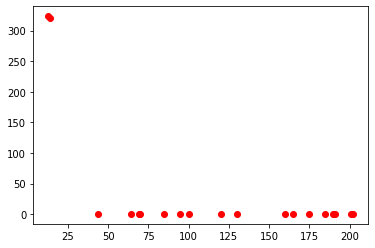

highHIIIIGHHHHHH:  138.0
rewaRD::  300
returned state: [202.]
observation space:  (20,)
stepping:  22
ACTION            :  5
curtemp:  227.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7324827411255
chisqds:  0.1429739138736613
BUT ARE WE SURE?: 2603303.80735262


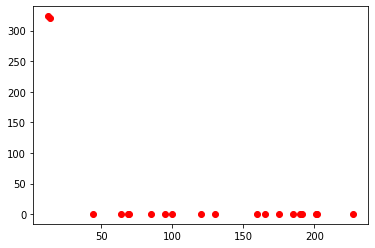

highHIIIIGHHHHHH:  113.0
rewaRD::  300
returned state: [227.]
observation space:  (21,)
stepping:  22
ACTION            :  5
curtemp:  252.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7262575138504
chisqds:  0.13507293745875812
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


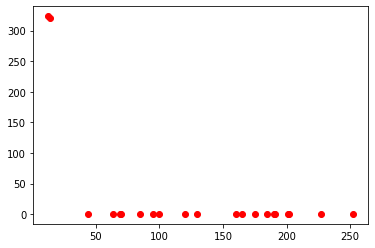

highHIIIIGHHHHHH:  88.0
rewaRD::  300
returned state: [252.]
observation space:  (22,)
stepping:  22
ACTION            :  1
curtemp:  257.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.80489904262424
chisqds:  0.1274619690395677
BUT ARE WE SURE?: 2602854.2202777946


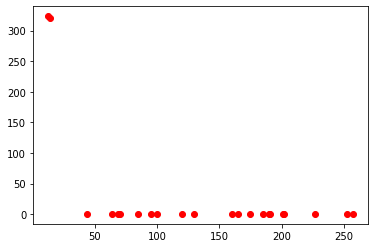

highHIIIIGHHHHHH:  83.0
rewaRD::  300
returned state: [257.]
observation space:  (23,)
stepping:  22
ACTION            :  0
curtemp:  258.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.70200997254125
chisqds:  0.121713066528834
BUT ARE WE SURE?: 210114223508.8739


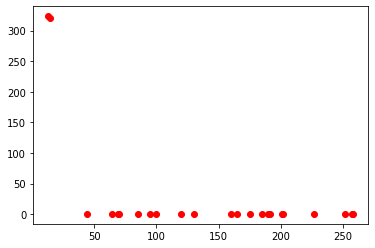

highHIIIIGHHHHHH:  82.0
rewaRD::  300
returned state: [258.]
observation space:  (24,)
stepping:  22
ACTION            :  5
curtemp:  283.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.70269960580436
chisqds:  0.11591321037260316
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


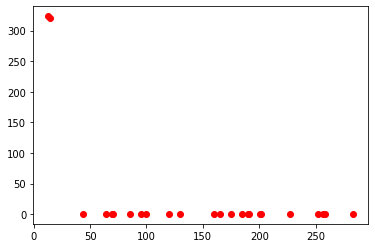

highHIIIIGHHHHHH:  57.0
rewaRD::  300
returned state: [283.]
observation space:  (25,)
stepping:  22
ACTION            :  1
curtemp:  288.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7190866843681
chisqds:  0.11055383737373391
BUT ARE WE SURE?: 309549703391.48444


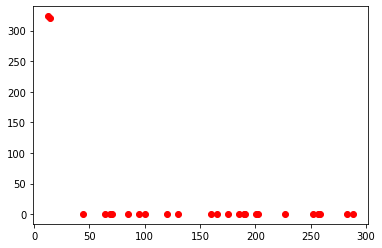

highHIIIIGHHHHHH:  52.0
rewaRD::  300
returned state: [288.]
observation space:  (26,)
stepping:  22
ACTION            :  4
curtemp:  308.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7009040451252
chisqds:  0.10584330015549757
BUT ARE WE SURE?: 2603499.9074493833


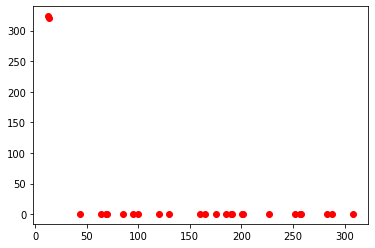

highHIIIIGHHHHHH:  32.0
rewaRD::  300
returned state: [308.]
observation space:  (27,)
stepping:  22
ACTION            :  1
curtemp:  313.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308. 313.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.73845641596506
chisqds:  0.10124295854077296
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


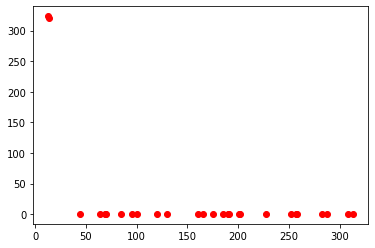

highHIIIIGHHHHHH:  27.0
rewaRD::  300
returned state: [313.]
observation space:  (28,)
stepping:  22
ACTION            :  0
curtemp:  314.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308. 313. 314.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 418.7882462808937
chisqds:  0.09695172504702695
BUT ARE WE SURE?: 54707775535.76823


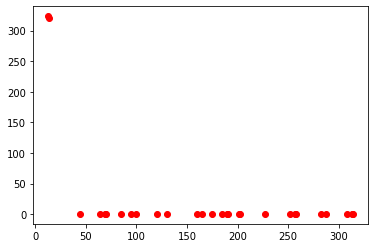

highHIIIIGHHHHHH:  26.0
rewaRD::  300
returned state: [314.]
observation space:  (29,)
stepping:  22
ACTION            :  1
curtemp:  319.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308. 313. 314.
 319.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.42418134467407
THE JT RESULT {X0}: 0.4000000546025505
THE NF RESULT {X1}: 387.7718728127337
chisqds:  0.23354614418117098
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


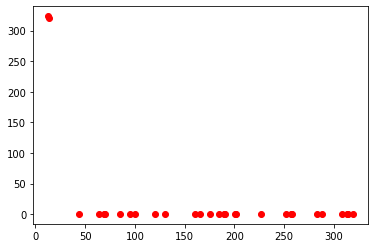

highHIIIIGHHHHHH:  21.0
rewaRD::  300
returned state: [319.]
observation space:  (30,)
stepping:  22
ACTION            :  3
curtemp:  334.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308. 313. 314.
 319. 334.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


ORDER PARAM RESULT (X2): 20.65749344807912
THE JT RESULT {X0}: 0.40000060885654215
THE NF RESULT {X1}: 374.0438800792469
chisqds:  0.31575696949587234
BUT ARE WE SURE?: nan


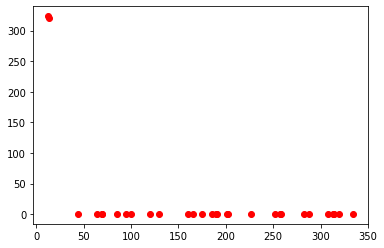

highHIIIIGHHHHHH:  6.0
rewaRD::  300
returned state: [334.]
observation space:  (31,)
stepping:  22
ACTION            :  4
curtemp:  354.0
Temperature:  [ 13.  14.  44.  64.  69.  70.  85.  95. 100. 120. 130. 160. 165. 175.
 185. 190. 191. 201. 202. 227. 252. 257. 258. 283. 288. 308. 313. 314.
 319. 334. 354.]
Intensity:  [3.23409405e+02 3.20552920e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 20.491477842576682
THE JT RESULT {X0}: 0.4000002337560567
THE NF RESULT {X1}: 358.3425549170056
chisqds:  0.5811049375325442
BUT ARE WE SURE?: 21351929.585139964


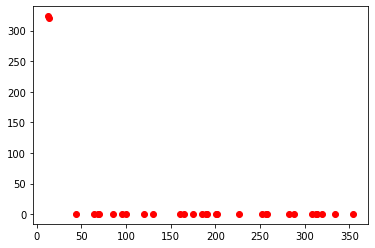

highHIIIIGHHHHHH:  -14.0
rewaRD::  300
terminated: over max temp
returned state: [354.]
observation space:  (32,)
reset
fixed Tn:  120
fixed Jt:  0.8
fixed Nf:  330
stepping:  23
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  23
ACTION            :  5
curtemp:  43.0
Temperature:  [18. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
returned state: [43.]
observation space:  (3,)
stepping:  23
ACTION            :  3
curtemp:  58.0
Temperature:  [18. 43. 58.]
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
returned state: [58.]
observation space:  (4,)
stepping:  23
ACTION            :  1
curtemp:  63.0
Temperature:  [18. 43. 58. 63.]
Intensity:  [330.28766747 321.92066602 299.30778348 287.79267392]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 340.4966810364216
chisqds:  1.5426354173866352
BUT ARE WE SURE?: 2.5676463154848723e-09


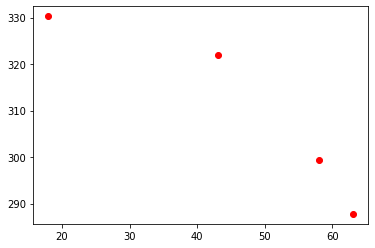

highHIIIIGHHHHHH:  277.0
rewaRD::  159.29652300971827
returned state: [63.]
observation space:  (5,)
stepping:  23
ACTION            :  4
curtemp:  83.0
Temperature:  [18. 43. 58. 63. 83.]
Intensity:  [330.28766747 321.92066602 299.30778348 287.79267392 220.26440275]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 316.75884280866387
chisqds:  17.636095532716737
BUT ARE WE SURE?: 5.684750731018643e-10


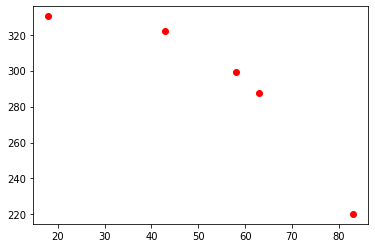

highHIIIIGHHHHHH:  257.0
rewaRD::  -77.31924284159385
returned state: [83.]
observation space:  (6,)
stepping:  23
ACTION            :  5
curtemp:  108.0
Temperature:  [ 18.  43.  58.  63.  83. 108.]
Intensity:  [330.28766747 321.92066602 299.30778348 287.79267392 220.26440275
  85.45206792]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 289.0356145420088
chisqds:  50.814483539761305
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


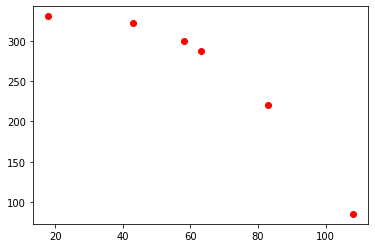

highHIIIIGHHHHHH:  232.0
rewaRD::  -92.12822856524738
returned state: [108.]
observation space:  (7,)
stepping:  23
ACTION            :  5
curtemp:  133.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 345.73490787073194
chisqds:  26.306331203577624
BUT ARE WE SURE?: 3.6437212589152843e-09


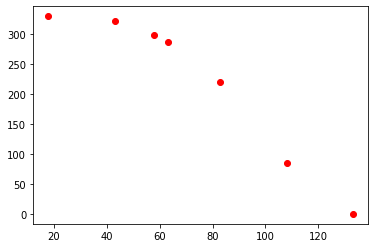

highHIIIIGHHHHHH:  207.0
rewaRD::  -84.79453493896554
returned state: [133.]
observation space:  (8,)
stepping:  23
ACTION            :  4
curtemp:  153.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 328.82353049479275
chisqds:  22.31539050852101
BUT ARE WE SURE?: 8.546546915716716e-09


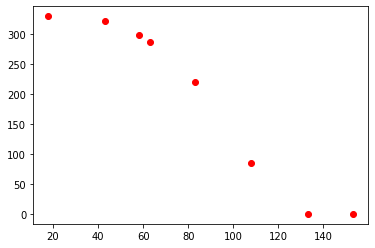

highHIIIIGHHHHHH:  187.0
rewaRD::  -82.07515123487254
returned state: [153.]
observation space:  (9,)
stepping:  23
ACTION            :  5
curtemp:  178.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 341.4179144000161
chisqds:  17.703659430784725
BUT ARE WE SURE?: 4.516108631860142e-09


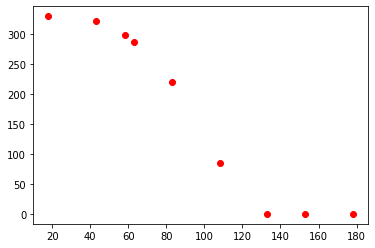

highHIIIIGHHHHHH:  162.0
rewaRD::  -77.40580123765577
returned state: [178.]
observation space:  (10,)
stepping:  23
ACTION            :  2
curtemp:  188.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.46092901507694
chisqds:  15.810655847881213
BUT ARE WE SURE?: 256971060.53811902


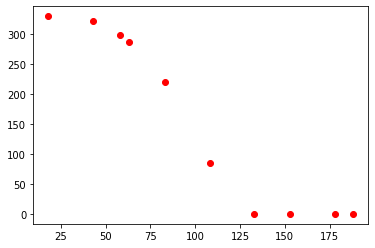

highHIIIIGHHHHHH:  152.0
rewaRD::  -74.70060673962465
returned state: [188.]
observation space:  (11,)
stepping:  23
ACTION            :  0
curtemp:  189.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 439.7930432826539
chisqds:  23.72947410091199
BUT ARE WE SURE?: 5.27019991370553e-09


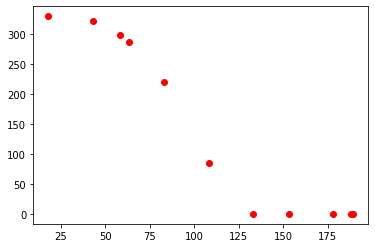

highHIIIIGHHHHHH:  151.0
rewaRD::  -83.1433263839325
returned state: [189.]
observation space:  (12,)
stepping:  23
ACTION            :  1
curtemp:  194.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 485.0896667774406
chisqds:  33.67961383132618
BUT ARE WE SURE?: 1.14157125586024e-08


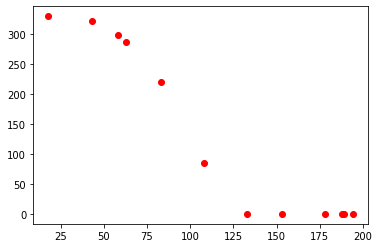

highHIIIIGHHHHHH:  146.0
rewaRD::  -88.12337926428506
returned state: [194.]
observation space:  (13,)
stepping:  23
ACTION            :  4
curtemp:  214.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 1.2388780968259028
THE NF RESULT {X1}: 402.56168280084836
chisqds:  12.736973884848808
BUT ARE WE SURE?: 0.37782192650821916


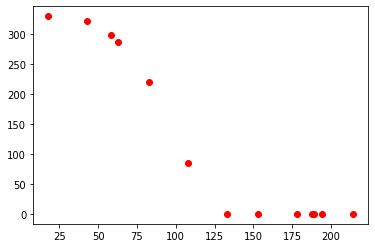

highHIIIIGHHHHHH:  126.0
rewaRD::  -68.5953662450531
returned state: [214.]
observation space:  (14,)
stepping:  23
ACTION            :  0
curtemp:  215.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 164.7317183717974
chisqds:  46.77268410527533
BUT ARE WE SURE?: 6.35787999894604e-09


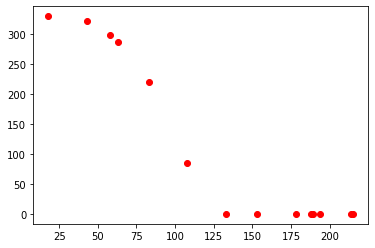

highHIIIIGHHHHHH:  125.0
rewaRD::  -91.44799988173257
returned state: [215.]
observation space:  (15,)
stepping:  23
ACTION            :  3
curtemp:  230.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.4956907169742
chisqds:  9.023830908937015
BUT ARE WE SURE?: 7.097292906697158e-09


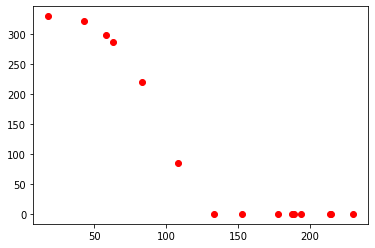

highHIIIIGHHHHHH:  110.0
rewaRD::  -55.67292826776615
returned state: [230.]
observation space:  (16,)
stepping:  23
ACTION            :  2
curtemp:  240.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.3690137954987
chisqds:  8.401834993641362
BUT ARE WE SURE?: 7.49823302961945e-09


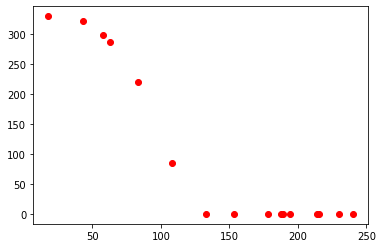

highHIIIIGHHHHHH:  100.0
rewaRD::  -52.39135256729915
returned state: [240.]
observation space:  (17,)
stepping:  23
ACTION            :  0
curtemp:  241.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 336.88426460362797
chisqds:  7.694977589274939
BUT ARE WE SURE?: 7.688043940942993e-09


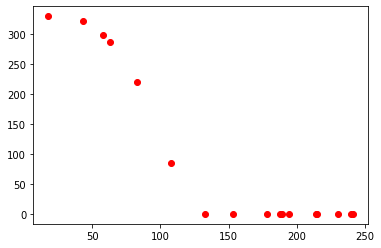

highHIIIIGHHHHHH:  99.0
rewaRD::  -48.0180422412783
returned state: [241.]
observation space:  (18,)
stepping:  23
ACTION            :  0
curtemp:  242.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.49590390752275
chisqds:  7.247595989691665
BUT ARE WE SURE?: 8.21712917782228e-09


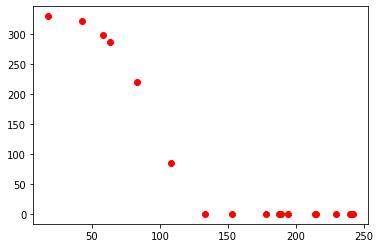

highHIIIIGHHHHHH:  98.0
rewaRD::  -44.809285648796596
returned state: [242.]
observation space:  (19,)
stepping:  23
ACTION            :  6
curtemp:  272.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.572693307156
chisqds:  6.673662982271583
BUT ARE WE SURE?: 7.924863968782213e-09


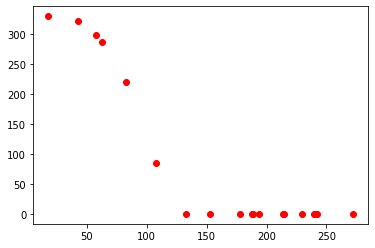

highHIIIIGHHHHHH:  68.0
rewaRD::  -40.06290082933618
returned state: [272.]
observation space:  (20,)
stepping:  23
ACTION            :  3
curtemp:  287.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272. 287.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.73528652062055
chisqds:  6.318273788946648
BUT ARE WE SURE?: 9.035354978239452e-09


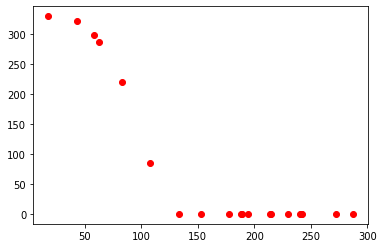

highHIIIIGHHHHHH:  53.0
rewaRD::  -36.69156903270473
returned state: [287.]
observation space:  (21,)
stepping:  23
ACTION            :  1
curtemp:  292.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272. 287. 292.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.66973417952187
chisqds:  6.0602735999596185
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


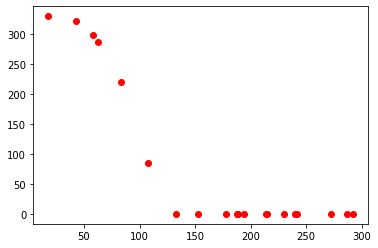

highHIIIIGHHHHHH:  48.0
rewaRD::  -33.996379304943375
returned state: [292.]
observation space:  (22,)
stepping:  23
ACTION            :  4
curtemp:  312.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272. 287. 292. 312.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.7469316790961
chisqds:  5.716017106785249
BUT ARE WE SURE?: 9.84734098709391e-09


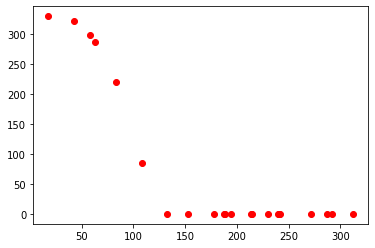

highHIIIIGHHHHHH:  28.0
rewaRD::  -30.021203133703636
returned state: [312.]
observation space:  (23,)
stepping:  23
ACTION            :  4
curtemp:  332.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272. 287. 292. 312. 332.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.9171474300145
chisqds:  5.405622251019388
BUT ARE WE SURE?: 9.685780231502332e-09


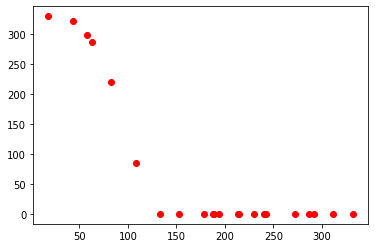

highHIIIIGHHHHHH:  8.0
rewaRD::  -26.002968497369878
returned state: [332.]
observation space:  (24,)
stepping:  23
ACTION            :  5
curtemp:  357.0
Temperature:  [ 18.  43.  58.  63.  83. 108. 133. 153. 178. 188. 189. 194. 214. 215.
 230. 240. 241. 242. 272. 287. 292. 312. 332. 357.]
Intensity:  [3.30287667e+02 3.21920666e+02 2.99307783e+02 2.87792674e+02
 2.20264403e+02 8.54520679e+01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 100.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 335.167618303185
chisqds:  5.1630415900631705
BUT ARE WE SURE?: 0.8083035505025379


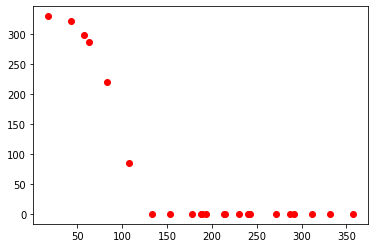

highHIIIIGHHHHHH:  -17.0
rewaRD::  -22.526287456246123
terminated: over max temp
returned state: [357.]
observation space:  (25,)
reset
fixed Tn:  210
fixed Jt:  0.8
fixed Nf:  330
stepping:  24
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  24
ACTION            :  0
curtemp:  19.0
Temperature:  [18. 19.]
highHIIIIGHHHHHH:  321.0
rewaRD::  -100
returned state: [19.]
observation space:  (3,)
stepping:  24
ACTION            :  5
curtemp:  44.0
Temperature:  [18. 19. 44.]
highHIIIIGHHHHHH:  296.0
rewaRD::  -100
returned state: [44.]
observation space:  (4,)
stepping:  24
ACTION            :  5
curtemp:  69.0
Temperature:  [18. 19. 44. 69.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 312.713932229731
chisqds:  3.515090874970744
BUT ARE WE SURE?: 3.2623541461938494e-10


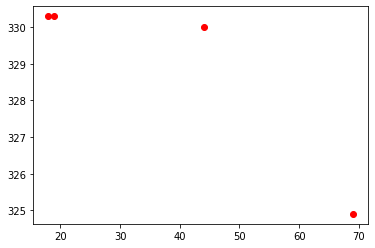

highHIIIIGHHHHHH:  271.0
rewaRD::  13.795066536744713
returned state: [69.]
observation space:  (5,)
stepping:  24
ACTION            :  1
curtemp:  74.0
Temperature:  [18. 19. 44. 69. 74.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 316.42798930466256
chisqds:  1.3192717793546958
BUT ARE WE SURE?: 6.346123639949923e-10


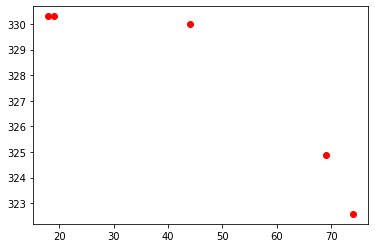

highHIIIIGHHHHHH:  266.0
rewaRD::  203.19757176618657
returned state: [74.]
observation space:  (6,)
stepping:  24
ACTION            :  1
curtemp:  79.0
Temperature:  [18. 19. 44. 69. 74. 79.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 275.6814035257472
chisqds:  17.443557823030332
BUT ARE WE SURE?: 3.4466049538411348e-09


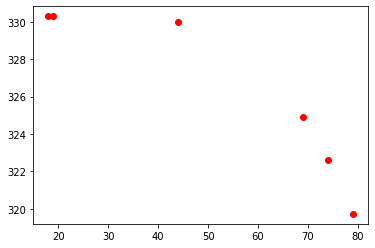

highHIIIIGHHHHHH:  261.0
rewaRD::  -77.06889821112702
returned state: [79.]
observation space:  (7,)
stepping:  24
ACTION            :  1
curtemp:  84.0
Temperature:  [18. 19. 44. 69. 74. 79. 84.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 296.36470424057404
chisqds:  5.7805778823821825
BUT ARE WE SURE?: 3.5555513518878782e-09


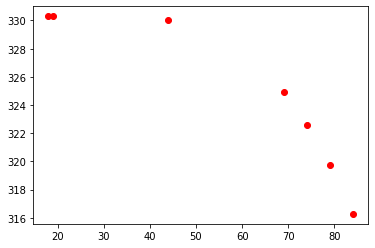

highHIIIIGHHHHHH:  256.0
rewaRD::  -30.802766066156778
returned state: [84.]
observation space:  (8,)
stepping:  24
ACTION            :  1
curtemp:  89.0
Temperature:  [18. 19. 44. 69. 74. 79. 84. 89.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717 ]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 317.3459497778781
chisqds:  0.7265001625411205
BUT ARE WE SURE?: 4.043565030660162e-09


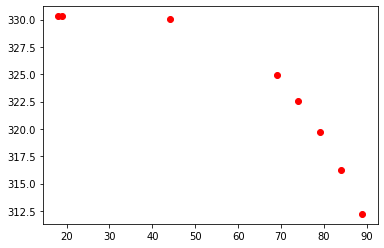

highHIIIIGHHHHHH:  251.0
rewaRD::  300
returned state: [89.]
observation space:  (9,)
stepping:  24
ACTION            :  5
curtemp:  114.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 442.5864328322234
chisqds:  54.90312269897578
BUT ARE WE SURE?: 4.503173519852019e-09


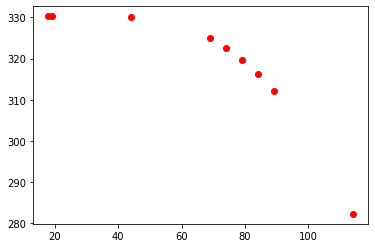

highHIIIIGHHHHHH:  226.0
rewaRD::  -92.71443990184073
returned state: [114.]
observation space:  (10,)
stepping:  24
ACTION            :  0
curtemp:  115.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.6325202835657
chisqds:  0.05334867825373895
BUT ARE WE SURE?: 4.91263856393788e-09


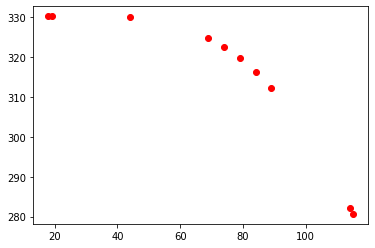

highHIIIIGHHHHHH:  225.0
rewaRD::  300
returned state: [115.]
observation space:  (11,)
stepping:  24
ACTION            :  0
curtemp:  116.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 443.4274875096984
chisqds:  26.004849457673725
BUT ARE WE SURE?: 1.271909941639526


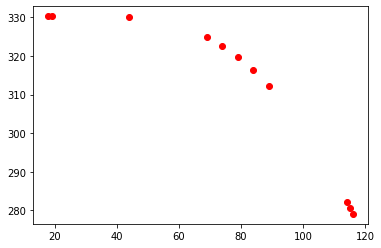

highHIIIIGHHHHHH:  224.0
rewaRD::  -84.61825358185395
returned state: [116.]
observation space:  (12,)
stepping:  24
ACTION            :  1
curtemp:  121.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 413.70990112892804
chisqds:  24.476285747008763
BUT ARE WE SURE?: 5.242091193825766e-09


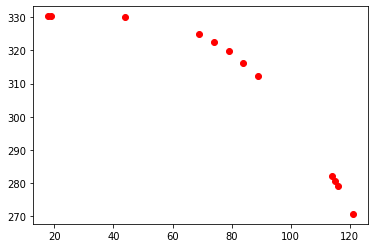

highHIIIIGHHHHHH:  219.0
rewaRD::  -83.65765115939277
returned state: [121.]
observation space:  (13,)
stepping:  24
ACTION            :  6
curtemp:  151.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681 205.78889364]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 286.35653203695165
chisqds:  8.668417071826855
BUT ARE WE SURE?: 0.7234251015542361


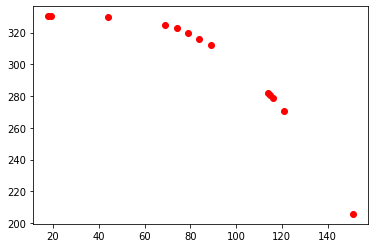

highHIIIIGHHHHHH:  189.0
rewaRD::  -53.85547364812009
returned state: [151.]
observation space:  (14,)
stepping:  24
ACTION            :  1
curtemp:  156.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681 205.78889364 192.41101961]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 384.31427110564636
chisqds:  8.246432470781107
BUT ARE WE SURE?: 2.4349025027471614e-09


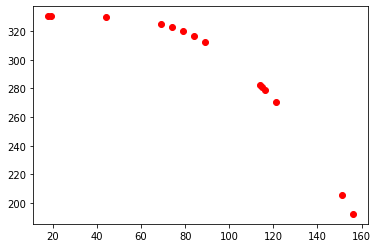

highHIIIIGHHHHHH:  184.0
rewaRD::  -51.49417624927064
returned state: [156.]
observation space:  (15,)
stepping:  24
ACTION            :  5
curtemp:  181.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681 205.78889364 192.41101961 114.37923934]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 438.94050009386217
chisqds:  33.868518696739194
BUT ARE WE SURE?: 8.560277703034066e-10


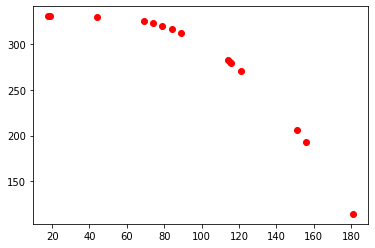

highHIIIIGHHHHHH:  159.0
rewaRD::  -88.18962223941281
returned state: [181.]
observation space:  (16,)
stepping:  24
ACTION            :  2
curtemp:  191.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681 205.78889364 192.41101961 114.37923934
  77.91844459]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 309.71661313842804
chisqds:  12.242377365224595
BUT ARE WE SURE?: 4.428664503723597e-10


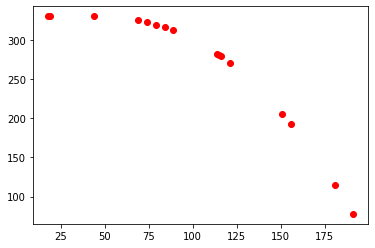

highHIIIIGHHHHHH:  149.0
rewaRD::  -67.326607564293
returned state: [191.]
observation space:  (17,)
stepping:  24
ACTION            :  2
curtemp:  201.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201.]
Intensity:  [330.29999704 330.29999175 330.0093204  324.90108053 322.58397364
 319.72005274 316.27622543 312.2254717  282.21574314 280.66270368
 279.08180408 270.75719681 205.78889364 192.41101961 114.37923934
  77.91844459  38.43346626]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 350.7747415159409
chisqds:  16.457467941133167
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


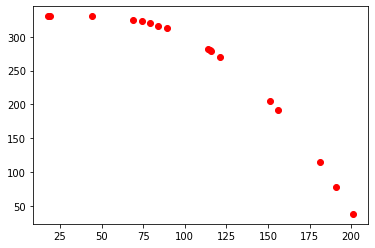

highHIIIIGHHHHHH:  139.0
rewaRD::  -75.69492455153109
returned state: [201.]
observation space:  (18,)
stepping:  24
ACTION            :  4
curtemp:  221.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.97351143849875
chisqds:  11.22196598691769
BUT ARE WE SURE?: 0.33853083033304493


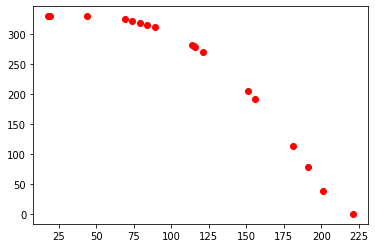

highHIIIIGHHHHHH:  119.0
rewaRD::  -64.35562178086167
returned state: [221.]
observation space:  (19,)
stepping:  24
ACTION            :  5
curtemp:  246.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.1446425644429
chisqds:  10.513335208281845
BUT ARE WE SURE?: 8.473490203155277e-09


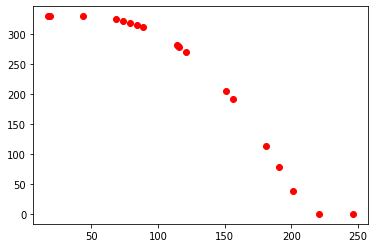

highHIIIIGHHHHHH:  94.0
rewaRD::  -61.95308224502332
returned state: [246.]
observation space:  (20,)
stepping:  24
ACTION            :  3
curtemp:  261.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246. 261.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 328.50073525024
chisqds:  9.965654802321259
BUT ARE WE SURE?: 8.013189019552795e-09


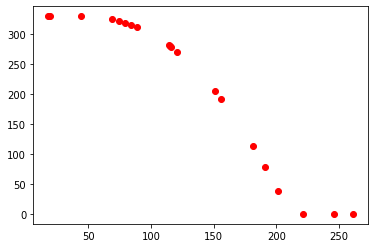

highHIIIIGHHHHHH:  79.0
rewaRD::  -59.862145746125016
returned state: [261.]
observation space:  (21,)
stepping:  24
ACTION            :  3
curtemp:  276.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246. 261. 276.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.6756723458296
chisqds:  9.36314617619904
BUT ARE WE SURE?: 8.792620930268102e-09


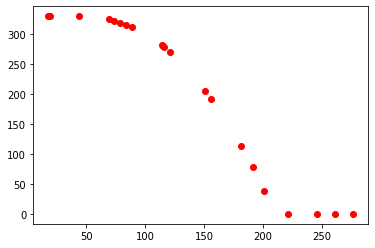

highHIIIIGHHHHHH:  64.0
rewaRD::  -57.27931696540279
returned state: [276.]
observation space:  (22,)
stepping:  24
ACTION            :  4
curtemp:  296.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246. 261. 276. 296.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.8451230048622
chisqds:  8.829475295241378
BUT ARE WE SURE?: 55446206.400198735


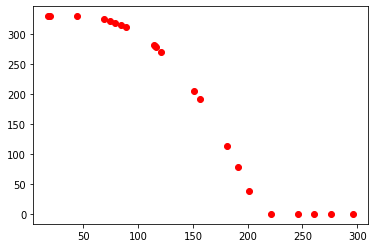

highHIIIIGHHHHHH:  44.0
rewaRD::  -54.69719472281904
returned state: [296.]
observation space:  (23,)
stepping:  24
ACTION            :  6
curtemp:  326.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246. 261. 276. 296. 326.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.1361662599499
chisqds:  8.446406292244173
BUT ARE WE SURE?: 9.423764902625695e-09


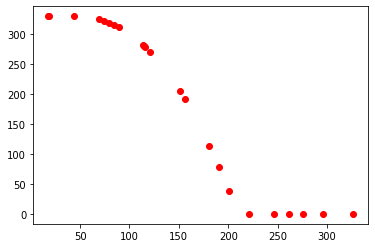

highHIIIIGHHHHHH:  14.0
rewaRD::  -52.6425812161918
returned state: [326.]
observation space:  (24,)
stepping:  24
ACTION            :  3
curtemp:  341.0
Temperature:  [ 18.  19.  44.  69.  74.  79.  84.  89. 114. 115. 116. 121. 151. 156.
 181. 191. 201. 221. 246. 261. 276. 296. 326. 341.]
Intensity:  [3.30299997e+02 3.30299992e+02 3.30009320e+02 3.24901081e+02
 3.22583974e+02 3.19720053e+02 3.16276225e+02 3.12225472e+02
 2.82215743e+02 2.80662704e+02 2.79081804e+02 2.70757197e+02
 2.05788894e+02 1.92411020e+02 1.14379239e+02 7.79184446e+01
 3.84334663e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 190.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.3746212685654
chisqds:  8.00288704769688
BUT ARE WE SURE?: 0.3381198180037211


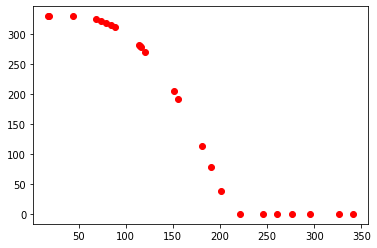

highHIIIIGHHHHHH:  -1.0
rewaRD::  -50.01803753870118
terminated: over max temp
returned state: [341.]
observation space:  (25,)
reset
fixed Tn:  80
fixed Jt:  0.7
fixed Nf:  330
stepping:  25
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
stepping:  25
ACTION            :  4
curtemp:  53.0
Temperature:  [33. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
returned state: [53.]
observation space:  (3,)
stepping:  25
ACTION            :  6
curtemp:  83.0
Temperature:  [33. 53. 83.]
highHIIIIGHHHHHH:  257.0
rewaRD::  -100
returned state: [83.]
observation space:  (4,)
stepping:  25
ACTION            :  2
curtemp:  93.0
Temperature:  [33. 53. 83. 93.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 351.27510406433265
chisqds:  64.32757139123107
BUT ARE WE SURE?: 3.0719692802539834e-10


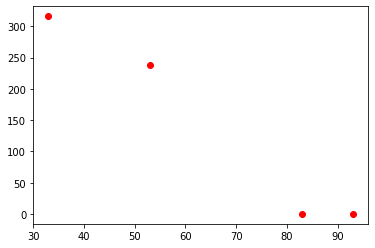

highHIIIIGHHHHHH:  247.0
rewaRD::  -93.7818264960252
returned state: [93.]
observation space:  (5,)
stepping:  25
ACTION            :  4
curtemp:  113.0
Temperature:  [ 33.  53.  83.  93. 113.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 340.9053058199742
chisqds:  34.21674921174773
BUT ARE WE SURE?: 3.668643098304699e-10


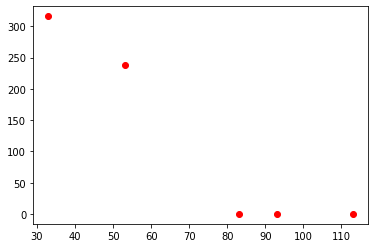

highHIIIIGHHHHHH:  227.0
rewaRD::  -88.30981875207868
returned state: [113.]
observation space:  (6,)
stepping:  25
ACTION            :  2
curtemp:  123.0
Temperature:  [ 33.  53.  83.  93. 113. 123.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 1.7958796270400705
THE NF RESULT {X1}: 409.04511505193574
chisqds:  24.93457936595672
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


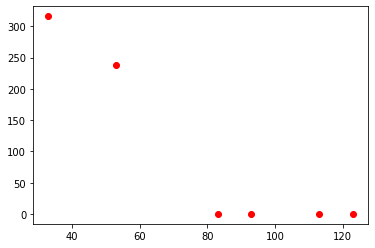

highHIIIIGHHHHHH:  217.0
rewaRD::  -83.95802094234958
returned state: [123.]
observation space:  (7,)
stepping:  25
ACTION            :  5
curtemp:  148.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 423.5301027349376
chisqds:  13.285379987770172
BUT ARE WE SURE?: 4.351821560418092e-10


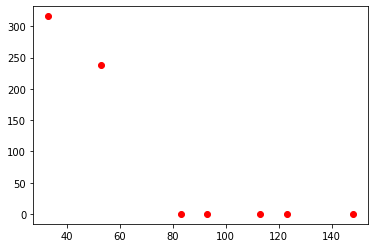

highHIIIIGHHHHHH:  192.0
rewaRD::  -69.89171552727743
returned state: [148.]
observation space:  (8,)
stepping:  25
ACTION            :  2
curtemp:  158.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 356.94242834547316
chisqds:  12.469768588020491
BUT ARE WE SURE?: 5815302022.719005


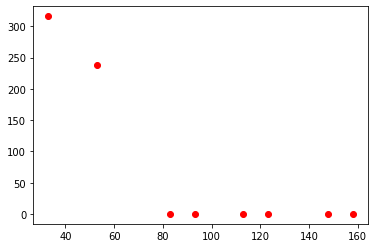

highHIIIIGHHHHHH:  182.0
rewaRD::  -67.92241995699314
returned state: [158.]
observation space:  (9,)
stepping:  25
ACTION            :  1
curtemp:  163.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 345.9238676776803
chisqds:  11.06133659270131
BUT ARE WE SURE?: 5.496750169061744e-10


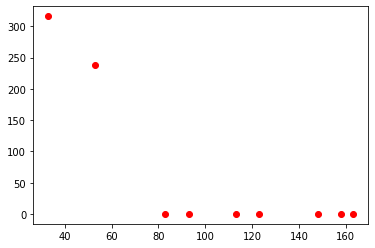

highHIIIIGHHHHHH:  177.0
rewaRD::  -63.8380048696886
returned state: [163.]
observation space:  (10,)
stepping:  25
ACTION            :  2
curtemp:  173.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 325.0079433007187
chisqds:  10.849536131182715
BUT ARE WE SURE?: 4.81441446712021e-09


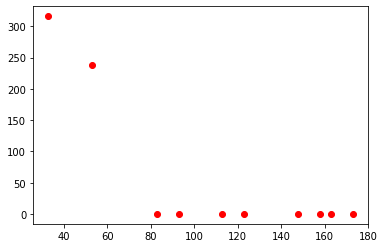

highHIIIIGHHHHHH:  167.0
rewaRD::  -63.13206434233095
returned state: [173.]
observation space:  (11,)
stepping:  25
ACTION            :  1
curtemp:  178.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 351.5991804399009
chisqds:  8.026170935313555
BUT ARE WE SURE?: 5.228961924735142e-09


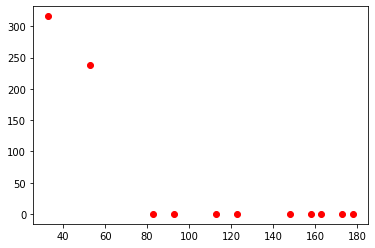

highHIIIIGHHHHHH:  162.0
rewaRD::  -50.16303499841007
returned state: [178.]
observation space:  (12,)
stepping:  25
ACTION            :  3
curtemp:  193.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 326.66760045336645
chisqds:  8.34371331449428
BUT ARE WE SURE?: 5.611762297360627e-09


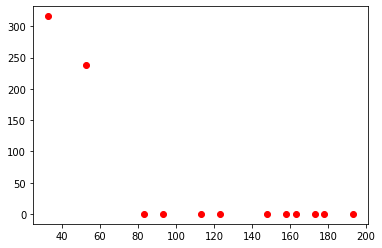

highHIIIIGHHHHHH:  147.0
rewaRD::  -52.05971431147568
returned state: [193.]
observation space:  (13,)
stepping:  25
ACTION            :  6
curtemp:  223.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 321.9370590438896
chisqds:  7.756808201438346
BUT ARE WE SURE?: 6.324733592191564e-09


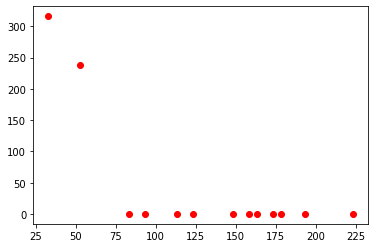

highHIIIIGHHHHHH:  117.0
rewaRD::  -48.43239775790409
returned state: [223.]
observation space:  (14,)
--------------------------------------
| approxkl           | 3.0915624e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 24.7          |
| ep_reward_mean     | 1.47e+03      |
| explained_variance | -3.93e-06     |
| fps                | 3             |
| n_updates          | 4             |
| policy_entropy     | 1.9437962     |
| policy_loss        | 0.00030999677 |
| serial_timesteps   | 512           |
| time_elapsed       | 236           |
| total_timesteps    | 512           |
| value_loss         | 1124596.5     |
--------------------------------------
stepping:  25
ACTION            :  3
curtemp:  238.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.000000

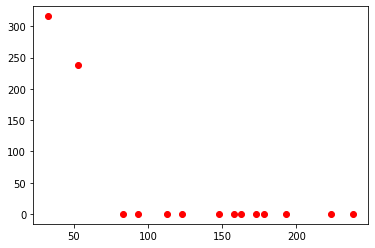

highHIIIIGHHHHHH:  102.0
rewaRD::  -45.200379318238284
returned state: [238.]
observation space:  (15,)
stepping:  25
ACTION            :  3
curtemp:  253.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 332.6368862255164
chisqds:  6.013095246677795
BUT ARE WE SURE?: 7.017772341668311e-09


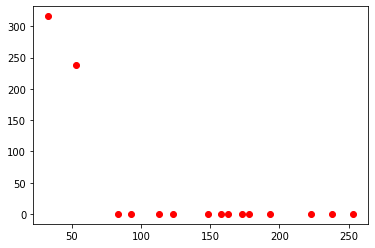

highHIIIIGHHHHHH:  87.0
rewaRD::  -33.478519200074544
returned state: [253.]
observation space:  (16,)
stepping:  25
ACTION            :  3
curtemp:  268.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253. 268.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 320.58154222542566
chisqds:  6.023174050325229
BUT ARE WE SURE?: 7.564518185466255e-09


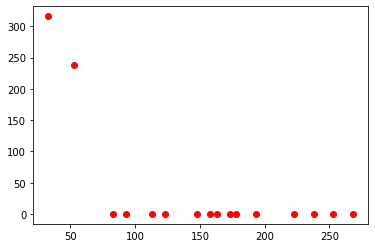

highHIIIIGHHHHHH:  72.0
rewaRD::  -33.58983209552089
returned state: [268.]
observation space:  (17,)
stepping:  25
ACTION            :  5
curtemp:  293.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253. 268. 293.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 333.04422224645185
chisqds:  5.14031113321339
BUT ARE WE SURE?: 7.852588884305201e-09


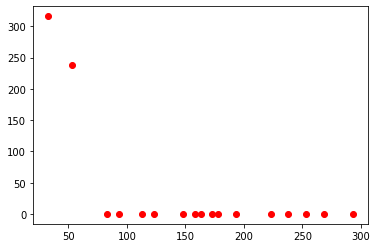

highHIIIIGHHHHHH:  47.0
rewaRD::  -22.183698684023838
returned state: [293.]
observation space:  (18,)
stepping:  25
ACTION            :  4
curtemp:  313.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253. 268. 293. 313.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 353.3882751643571
chisqds:  4.237856344671607
BUT ARE WE SURE?: 8.12596228776587e-09


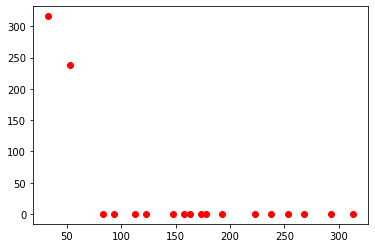

highHIIIIGHHHHHH:  27.0
rewaRD::  -5.612657091849542
returned state: [313.]
observation space:  (19,)
stepping:  25
ACTION            :  2
curtemp:  323.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253. 268. 293. 313. 323.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 353.6033576206393
chisqds:  3.968248768654574
BUT ARE WE SURE?: 8.546259846729991e-09


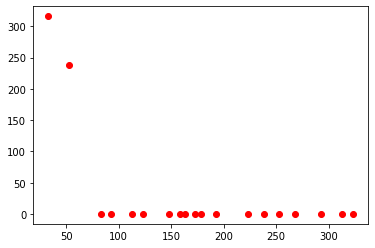

highHIIIIGHHHHHH:  17.0
rewaRD::  0.8001320783170343
returned state: [323.]
observation space:  (20,)
stepping:  25
ACTION            :  5
curtemp:  348.0
Temperature:  [ 33.  53.  83.  93. 113. 123. 148. 158. 163. 173. 178. 193. 223. 238.
 253. 268. 293. 313. 323. 348.]
Intensity:  [3.15970938e+02 2.38133380e+02 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 60.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 322.48163029646196
chisqds:  4.545679449681302
BUT ARE WE SURE?: 9.158159771610177e-09


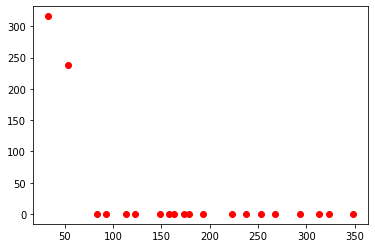

highHIIIIGHHHHHH:  -8.0
rewaRD::  -12.00435393040219
terminated: over max temp
returned state: [348.]
observation space:  (21,)
reset
fixed Tn:  70
fixed Jt:  1.2
fixed Nf:  330
stepping:  26
ACTION            :  1
curtemp:  8.0
Temperature:  [8.]
highHIIIIGHHHHHH:  332.0
rewaRD::  -100
returned state: [8.]
observation space:  (2,)
stepping:  26
ACTION            :  5
curtemp:  33.0
Temperature:  [ 8. 33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (3,)
stepping:  26
ACTION            :  1
curtemp:  38.0
Temperature:  [ 8. 33. 38.]
highHIIIIGHHHHHH:  302.0
rewaRD::  -100
returned state: [38.]
observation space:  (4,)
stepping:  26
ACTION            :  0
curtemp:  39.0
Temperature:  [ 8. 33. 38. 39.]
Intensity:  [330.29638199 292.98055553 271.05196329 266.02501013]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 464.12399004464714
chisqds:  66.70633679105717
BUT ARE WE SURE?: 5.49433838030259e-09


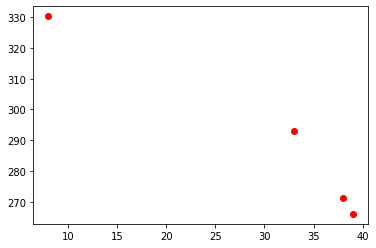

highHIIIIGHHHHHH:  301.0
rewaRD::  -94.00356818793826
returned state: [39.]
observation space:  (5,)
stepping:  26
ACTION            :  5
curtemp:  64.0
Temperature:  [ 8. 33. 38. 39. 64.]
Intensity:  [330.29638199 292.98055553 271.05196329 266.02501013  68.771056  ]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 419.058288871977
chisqds:  50.06101175177201
BUT ARE WE SURE?: 3.030206930531826e-10


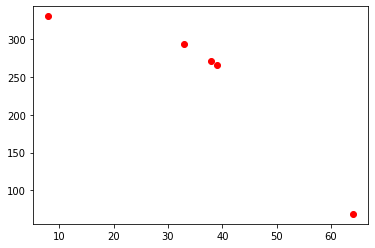

highHIIIIGHHHHHH:  276.0
rewaRD::  -92.00974998301265
returned state: [64.]
observation space:  (6,)
stepping:  26
ACTION            :  6
curtemp:  94.0
Temperature:  [ 8. 33. 38. 39. 64. 94.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 366.1471734371241
chisqds:  32.64719565976261
BUT ARE WE SURE?: 4.487561608824974e-10


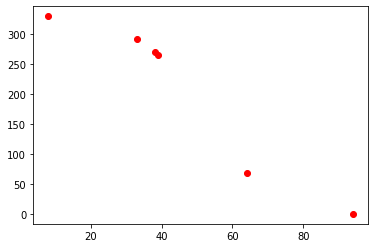

highHIIIIGHHHHHH:  246.0
rewaRD::  -87.74779910137897
returned state: [94.]
observation space:  (7,)
stepping:  26
ACTION            :  6
curtemp:  124.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 382.92058142256235
chisqds:  23.529076456653982
BUT ARE WE SURE?: 2.9553116709615687e-10


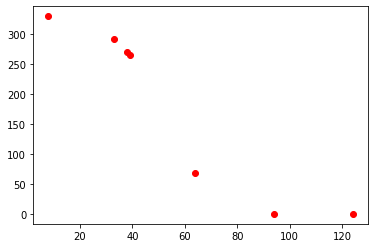

highHIIIIGHHHHHH:  216.0
rewaRD::  -82.9997577364801
returned state: [124.]
observation space:  (8,)
stepping:  26
ACTION            :  5
curtemp:  149.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 370.28832813146954
chisqds:  19.321477551705566
BUT ARE WE SURE?: 4.210419149270281e-10


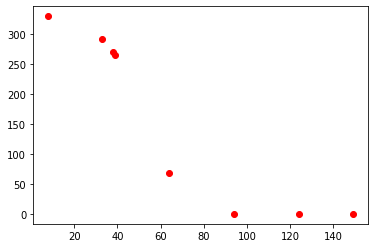

highHIIIIGHHHHHH:  191.0
rewaRD::  -79.29764952346045
returned state: [149.]
observation space:  (9,)
stepping:  26
ACTION            :  1
curtemp:  154.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 498.53741726109655
chisqds:  30.299957325806876
BUT ARE WE SURE?: 4.591989038137254e-09


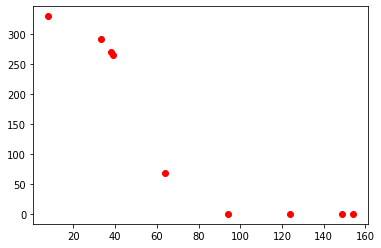

highHIIIIGHHHHHH:  186.0
rewaRD::  -86.79866127536376
returned state: [154.]
observation space:  (10,)
stepping:  26
ACTION            :  0
curtemp:  155.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 499.38710354788503
chisqds:  26.16878633213998
BUT ARE WE SURE?: 5.02896757553181e-09


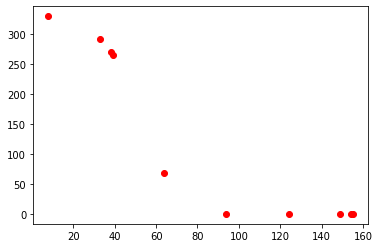

highHIIIIGHHHHHH:  185.0
rewaRD::  -84.71461400910565
returned state: [155.]
observation space:  (11,)
stepping:  26
ACTION            :  5
curtemp:  180.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 499.99896036388475
chisqds:  23.022896180800767
BUT ARE WE SURE?: 5.3733749098038546e-09


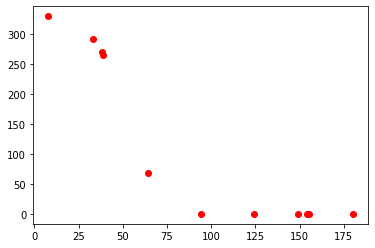

highHIIIIGHHHHHH:  160.0
rewaRD::  -82.62599123677725
returned state: [180.]
observation space:  (12,)
stepping:  26
ACTION            :  6
curtemp:  210.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  20.464986241423837
BUT ARE WE SURE?: 5.9314301696587985e-09


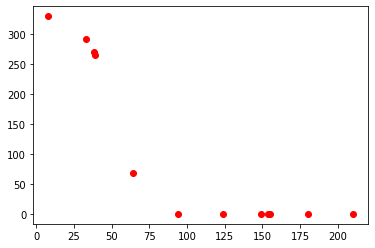

highHIIIIGHHHHHH:  130.0
rewaRD::  -80.45442125974427
returned state: [210.]
observation space:  (13,)
stepping:  26
ACTION            :  6
curtemp:  240.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 497.8705004640277
chisqds:  18.072273984480198
BUT ARE WE SURE?: 6.032326316165454e-09


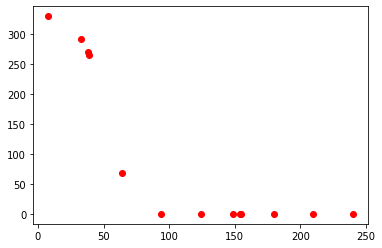

highHIIIIGHHHHHH:  100.0
rewaRD::  -77.8666480851549
returned state: [240.]
observation space:  (14,)
stepping:  26
ACTION            :  1
curtemp:  245.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 499.195697925704
chisqds:  16.62448195947446
BUT ARE WE SURE?: 6.113741180891627e-09


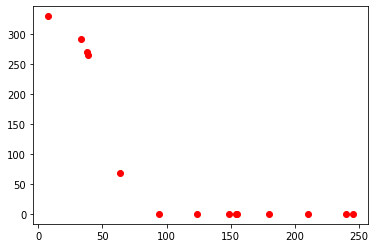

highHIIIIGHHHHHH:  95.0
rewaRD::  -75.9390998784154
returned state: [245.]
observation space:  (15,)
stepping:  26
ACTION            :  0
curtemp:  246.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  15.348739681067878
BUT ARE WE SURE?: 6.789265599024369e-09


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


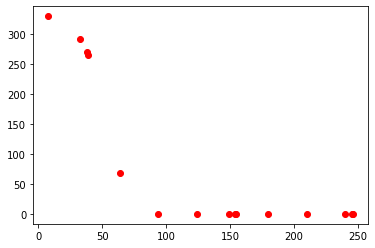

highHIIIIGHHHHHH:  94.0
rewaRD::  -73.93922834632568
returned state: [246.]
observation space:  (16,)
stepping:  26
ACTION            :  6
curtemp:  276.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246. 276.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.7328600616855571
THE NF RESULT {X1}: 485.0190321764532
chisqds:  11.738407928662053
BUT ARE WE SURE?: 0.3017681646746134


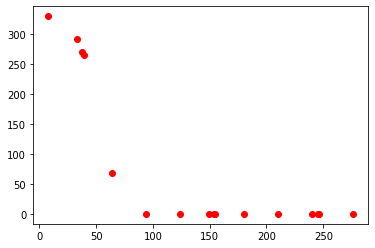

highHIIIIGHHHHHH:  64.0
rewaRD::  -65.92382864602047
returned state: [276.]
observation space:  (17,)
stepping:  26
ACTION            :  1
curtemp:  281.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246. 276. 281.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  13.156062583772467
BUT ARE WE SURE?: 0.8982550763628588


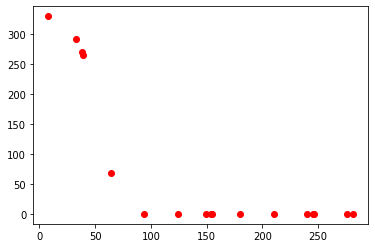

highHIIIIGHHHHHH:  59.0
rewaRD::  -69.59576640404663
returned state: [281.]
observation space:  (18,)
stepping:  26
ACTION            :  4
curtemp:  301.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246. 276. 281. 301.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  12.278991744854302
BUT ARE WE SURE?: 0.8982550763628588


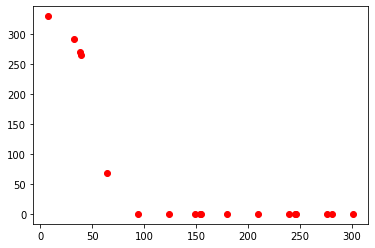

highHIIIIGHHHHHH:  39.0
rewaRD::  -67.42403543290709
returned state: [301.]
observation space:  (19,)
stepping:  26
ACTION            :  6
curtemp:  331.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246. 276. 281. 301. 331.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  11.511554760800909
BUT ARE WE SURE?: 16372799.647916663


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


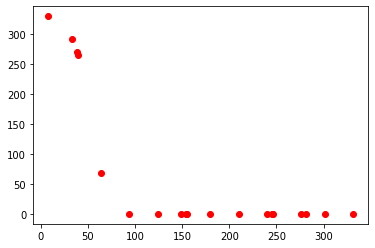

highHIIIIGHHHHHH:  9.0
rewaRD::  -65.25230446176758
returned state: [331.]
observation space:  (20,)
stepping:  26
ACTION            :  5
curtemp:  356.0
Temperature:  [  8.  33.  38.  39.  64.  94. 124. 149. 154. 155. 180. 210. 240. 245.
 246. 276. 281. 301. 331. 356.]
Intensity:  [3.30296382e+02 2.92980556e+02 2.71051963e+02 2.66025010e+02
 6.87710560e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  10.834404480753797
BUT ARE WE SURE?: 0.8982550763628588


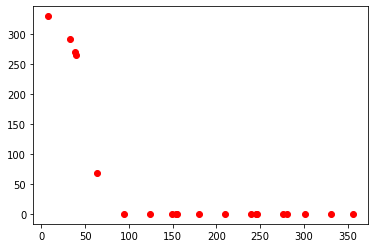

highHIIIIGHHHHHH:  -16.0
rewaRD::  -63.08057349062805
terminated: over max temp
returned state: [356.]
observation space:  (21,)
reset
fixed Tn:  60
fixed Jt:  1.0
fixed Nf:  330
stepping:  27
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  27
ACTION            :  4
curtemp:  43.0
Temperature:  [23. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
returned state: [43.]
observation space:  (3,)
stepping:  27
ACTION            :  2
curtemp:  53.0
Temperature:  [23. 43. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
returned state: [53.]
observation space:  (4,)
stepping:  27
ACTION            :  6
curtemp:  83.0
Temperature:  [23. 43. 53. 83.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 483.3234568029102
chisqds:  326.03924157801185
BUT ARE WE SURE?: 7.147550542328081e-11


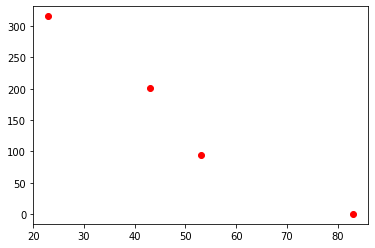

highHIIIIGHHHHHH:  257.0
rewaRD::  -100
returned state: [83.]
observation space:  (5,)
stepping:  27
ACTION            :  5
curtemp:  108.0
Temperature:  [ 23.  43.  53.  83. 108.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 451.43346190258455
chisqds:  147.43171801146894
BUT ARE WE SURE?: 45844959.45794975


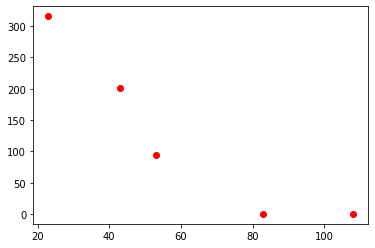

highHIIIIGHHHHHH:  232.0
rewaRD::  -97.28687961182897
returned state: [108.]
observation space:  (6,)
stepping:  27
ACTION            :  0
curtemp:  109.0
Temperature:  [ 23.  43.  53.  83. 108. 109.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 421.8624046972204
chisqds:  100.42860364710742
BUT ARE WE SURE?: 1.7854025133424283e-09


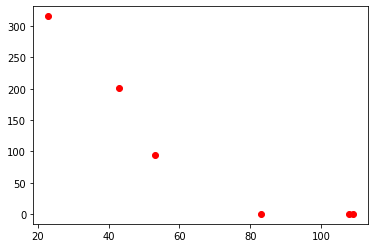

highHIIIIGHHHHHH:  231.0
rewaRD::  -96.01707097904551
returned state: [109.]
observation space:  (7,)
stepping:  27
ACTION            :  0
curtemp:  110.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.9024210573287
chisqds:  73.53726941275457
BUT ARE WE SURE?: 30158450.957373314


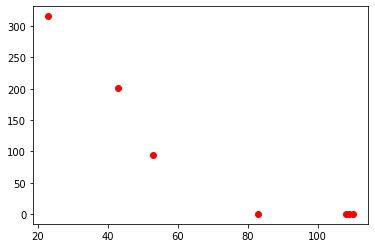

highHIIIIGHHHHHH:  230.0
rewaRD::  -94.56058127811552
returned state: [110.]
observation space:  (8,)
stepping:  27
ACTION            :  1
curtemp:  115.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 372.76144752895124
chisqds:  58.84712809700716
BUT ARE WE SURE?: 15208808.885499688


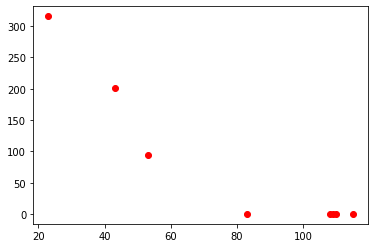

highHIIIIGHHHHHH:  225.0
rewaRD::  -93.20272691403707
returned state: [115.]
observation space:  (9,)
stepping:  27
ACTION            :  5
curtemp:  140.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 366.7170054966319
chisqds:  49.02484661560501
BUT ARE WE SURE?: 15214850.293123057


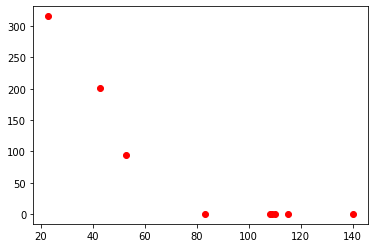

highHIIIIGHHHHHH:  200.0
rewaRD::  -91.8408719738314
returned state: [140.]
observation space:  (10,)
stepping:  27
ACTION            :  6
curtemp:  170.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 362.0545375456631
chisqds:  42.02847528916987
BUT ARE WE SURE?: 15219716.686567865


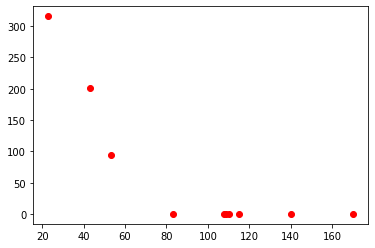

highHIIIIGHHHHHH:  170.0
rewaRD::  -90.48264308310337
returned state: [170.]
observation space:  (11,)
stepping:  27
ACTION            :  6
curtemp:  200.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.8892381351162
chisqds:  36.768634831914994
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


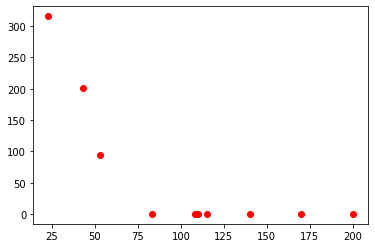

/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


highHIIIIGHHHHHH:  140.0
rewaRD::  -89.12116259337424
returned state: [200.]
observation space:  (12,)
stepping:  27
ACTION            :  1
curtemp:  205.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 1.4631231612374611
THE NF RESULT {X1}: 412.25517092612483
chisqds:  32.68323081881496
BUT ARE WE SURE?: nan


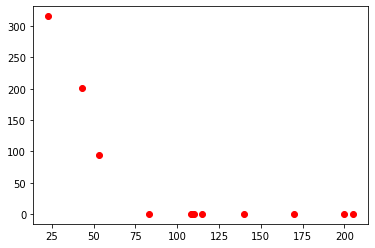

highHIIIIGHHHHHH:  135.0
rewaRD::  -87.76130786403988
returned state: [205.]
observation space:  (13,)
stepping:  27
ACTION            :  6
curtemp:  235.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.89763023569185
chisqds:  29.414907794775168
BUT ARE WE SURE?: 30158454.03736306


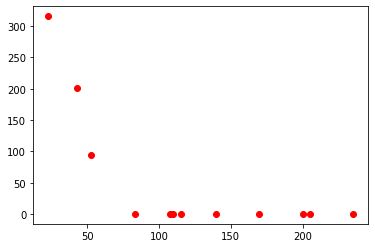

highHIIIIGHHHHHH:  105.0
rewaRD::  -86.40145320900682
returned state: [235.]
observation space:  (14,)
stepping:  27
ACTION            :  4
curtemp:  255.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 1.920633604820567
THE NF RESULT {X1}: 428.38556303682753
chisqds:  26.740825202363
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


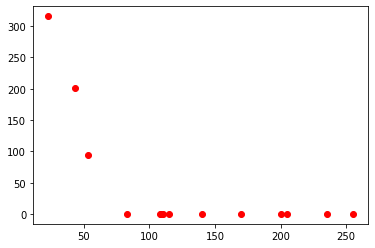

highHIIIIGHHHHHH:  85.0
rewaRD::  -85.04159849320382
returned state: [255.]
observation space:  (15,)
stepping:  27
ACTION            :  1
curtemp:  260.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.915543011532
chisqds:  24.512423103102464
BUT ARE WE SURE?: 2792349377.0069885


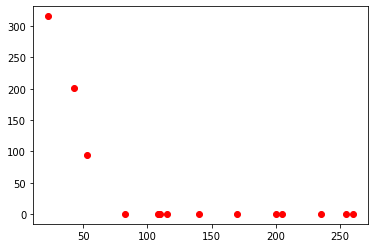

highHIIIIGHHHHHH:  80.0
rewaRD::  -83.68174381139116
returned state: [260.]
observation space:  (16,)
stepping:  27
ACTION            :  2
curtemp:  270.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.8912541834027
chisqds:  22.626852189501655
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


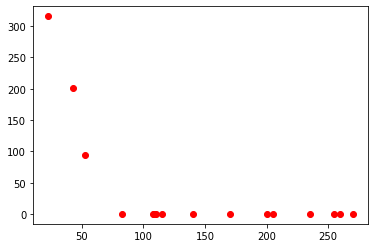

highHIIIIGHHHHHH:  70.0
rewaRD::  -82.3218892027062
returned state: [270.]
observation space:  (17,)
stepping:  27
ACTION            :  3
curtemp:  285.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270. 285.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.9039485346055
chisqds:  21.010648398056464
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


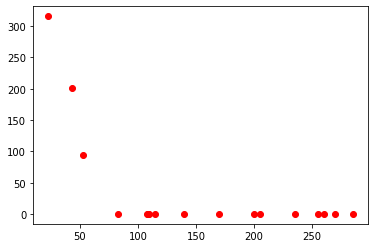

highHIIIIGHHHHHH:  55.0
rewaRD::  -80.96203446834126
returned state: [285.]
observation space:  (18,)
stepping:  27
ACTION            :  0
curtemp:  286.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270. 285. 286.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.9007125046163
chisqds:  19.609938516526928
BUT ARE WE SURE?: 30158452.055926453


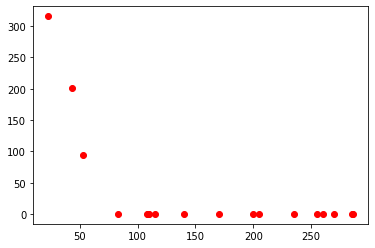

highHIIIIGHHHHHH:  54.0
rewaRD::  -79.60217979965176
returned state: [286.]
observation space:  (19,)
stepping:  27
ACTION            :  3
curtemp:  301.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270. 285. 286. 301.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.91239576369253
chisqds:  18.384317330199448
BUT ARE WE SURE?: 30158444.545726348


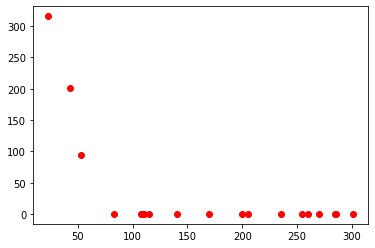

highHIIIIGHHHHHH:  39.0
rewaRD::  -78.24232508525458
returned state: [301.]
observation space:  (20,)
stepping:  27
ACTION            :  3
curtemp:  316.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270. 285. 286. 301. 316.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 460.01099658903377
chisqds:  17.387392434783063
BUT ARE WE SURE?: 65191042.567962244


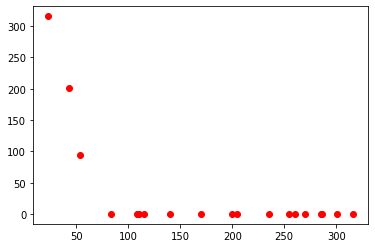

highHIIIIGHHHHHH:  24.0
rewaRD::  -76.99482533103644
returned state: [316.]
observation space:  (21,)
stepping:  27
ACTION            :  5
curtemp:  341.0
Temperature:  [ 23.  43.  53.  83. 108. 109. 110. 115. 140. 170. 200. 205. 235. 255.
 260. 270. 285. 286. 301. 316. 341.]
Intensity:  [3.15777143e+02 2.00731050e+02 9.46166273e+01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 40.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 430.89765656761296
chisqds:  16.34161544143932
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


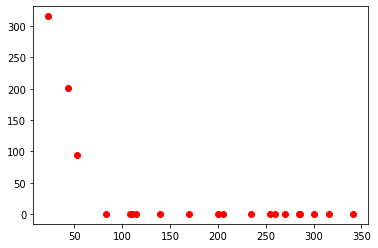

highHIIIIGHHHHHH:  -1.0
rewaRD::  -75.52261577605884
terminated: over max temp
returned state: [341.]
observation space:  (22,)
reset
fixed Tn:  70
fixed Jt:  1.4
fixed Nf:  330
stepping:  28
ACTION            :  3
curtemp:  18.0
Temperature:  [18.]
highHIIIIGHHHHHH:  322.0
rewaRD::  -100
returned state: [18.]
observation space:  (2,)
stepping:  28
ACTION            :  5
curtemp:  43.0
Temperature:  [18. 43.]
highHIIIIGHHHHHH:  297.0
rewaRD::  -100
returned state: [43.]
observation space:  (3,)
stepping:  28
ACTION            :  2
curtemp:  53.0
Temperature:  [18. 43. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
returned state: [53.]
observation space:  (4,)
stepping:  28
ACTION            :  2
curtemp:  63.0
Temperature:  [18. 43. 53. 63.]
Intensity:  [326.52788189 238.56544821 168.24344493  77.00283686]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 312.16032322352453
chisqds:  304.54500667043743
BUT ARE WE SURE?: 2.7660003388140737e-09


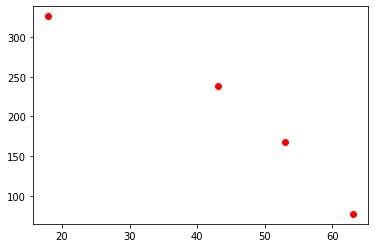

highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (5,)
stepping:  28
ACTION            :  0
curtemp:  64.0
Temperature:  [18. 43. 53. 63. 64.]
Intensity:  [326.52788189 238.56544821 168.24344493  77.00283686  66.69947139]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 301.70218284968655
chisqds:  188.08826270539703
BUT ARE WE SURE?: 13864997.03419939


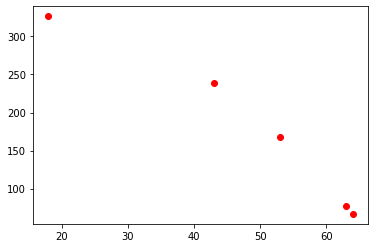

highHIIIIGHHHHHH:  276.0
rewaRD::  -97.87333885567054
returned state: [64.]
observation space:  (6,)
stepping:  28
ACTION            :  5
curtemp:  89.0
Temperature:  [18. 43. 53. 63. 64. 89.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 170.57942596302775
chisqds:  170.73580919104128
BUT ARE WE SURE?: 1.311390176777754e-09


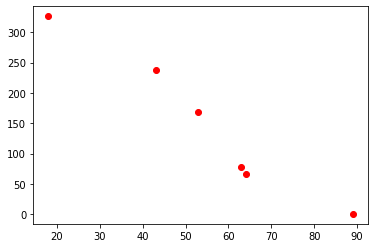

highHIIIIGHHHHHH:  251.0
rewaRD::  -97.6571991435468
returned state: [89.]
observation space:  (7,)
stepping:  28
ACTION            :  1
curtemp:  94.0
Temperature:  [18. 43. 53. 63. 64. 89. 94.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 250.16791631598693
chisqds:  103.7265443060004
BUT ARE WE SURE?: 3.547054557109863e-10


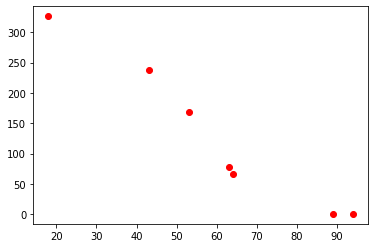

highHIIIIGHHHHHH:  246.0
rewaRD::  -96.14370648635538
returned state: [94.]
observation space:  (8,)
stepping:  28
ACTION            :  4
curtemp:  114.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 331.71517147835397
chisqds:  72.48253746179753
BUT ARE WE SURE?: 1.9416527298778173e-09


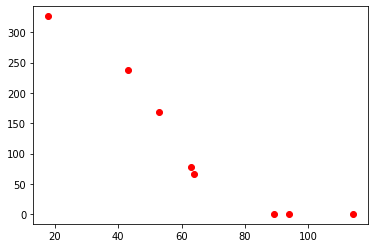

highHIIIIGHHHHHH:  226.0
rewaRD::  -94.48142940345014
returned state: [114.]
observation space:  (9,)
stepping:  28
ACTION            :  0
curtemp:  115.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 248.06405979042285
chisqds:  69.48211068953695
BUT ARE WE SURE?: 1.0856524628067788e-09


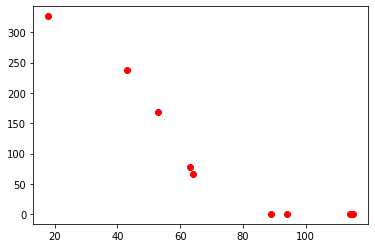

highHIIIIGHHHHHH:  225.0
rewaRD::  -94.2431224954104
returned state: [115.]
observation space:  (10,)
stepping:  28
ACTION            :  2
curtemp:  125.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 344.9821443819748
chisqds:  51.198734204139775
BUT ARE WE SURE?: 4.1798191010701454e-10


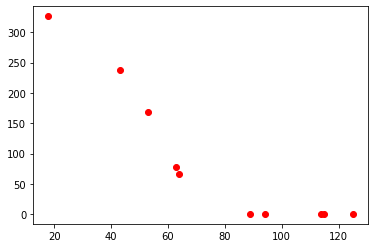

highHIIIIGHHHHHH:  215.0
rewaRD::  -92.18730685010456
returned state: [125.]
observation space:  (11,)
stepping:  28
ACTION            :  3
curtemp:  140.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 500.0
chisqds:  50.639034759701545
BUT ARE WE SURE?: 8608553.217175808


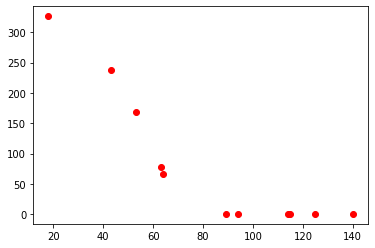

highHIIIIGHHHHHH:  200.0
rewaRD::  -92.10095528285386
returned state: [140.]
observation space:  (12,)
stepping:  28
ACTION            :  5
curtemp:  165.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.01738967752294
chisqds:  40.33539935789182
BUT ARE WE SURE?: 7.472487218778843e-10


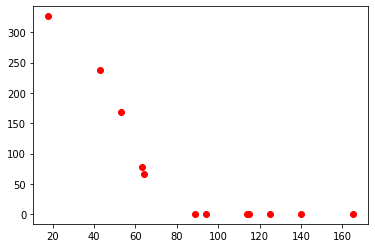

highHIIIIGHHHHHH:  175.0
rewaRD::  -90.08315260620475
returned state: [165.]
observation space:  (13,)
stepping:  28
ACTION            :  0
curtemp:  166.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4000000000000001
THE NF RESULT {X1}: 342.34778775888134
chisqds:  35.90890595750734
BUT ARE WE SURE?: 7.614058510216672e-10


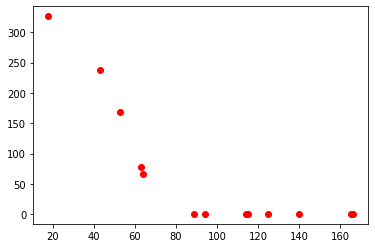

highHIIIIGHHHHHH:  174.0
rewaRD::  -88.86070212015542
returned state: [166.]
observation space:  (14,)
stepping:  28
ACTION            :  3
curtemp:  181.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.59686636709966
chisqds:  32.982678348833964
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


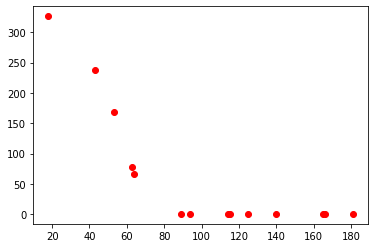

highHIIIIGHHHHHH:  159.0
rewaRD::  -87.8724221311111
returned state: [181.]
observation space:  (15,)
stepping:  28
ACTION            :  1
curtemp:  186.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.6149820187926
chisqds:  30.23358023421954
BUT ARE WE SURE?: 6621007543.205188


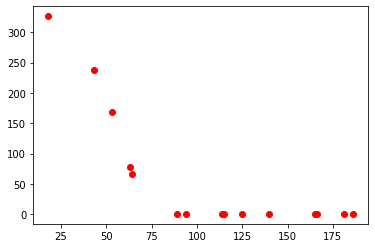

highHIIIIGHHHHHH:  154.0
rewaRD::  -86.76967805661123
returned state: [186.]
observation space:  (16,)
stepping:  28
ACTION            :  6
curtemp:  216.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.60442920467864
chisqds:  27.908211412866475
BUT ARE WE SURE?: 12746251.276888672


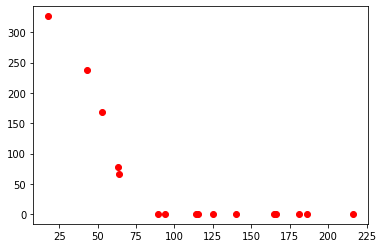

highHIIIIGHHHHHH:  124.0
rewaRD::  -85.66730077816493
returned state: [216.]
observation space:  (17,)
stepping:  28
ACTION            :  0
curtemp:  217.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 310.1661620847142
chisqds:  26.54569935436126
BUT ARE WE SURE?: 1.577483282983578e-09


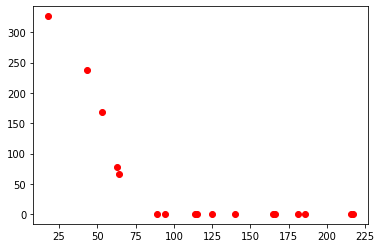

highHIIIIGHHHHHH:  123.0
rewaRD::  -84.93164581349473
returned state: [217.]
observation space:  (18,)
stepping:  28
ACTION            :  5
curtemp:  242.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.6614840310191
chisqds:  24.18575272761115
BUT ARE WE SURE?: 30886427932.013855


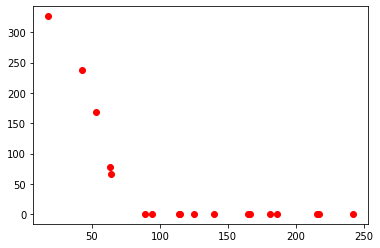

highHIIIIGHHHHHH:  98.0
rewaRD::  -83.46133756906607
returned state: [242.]
observation space:  (19,)
stepping:  28
ACTION            :  4
curtemp:  262.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 247.11582347465622
chisqds:  26.112399791868878
BUT ARE WE SURE?: 102886495.54261956


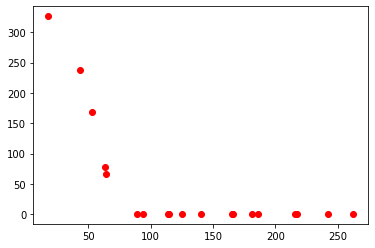

highHIIIIGHHHHHH:  78.0
rewaRD::  -84.6816070836754
returned state: [262.]
observation space:  (20,)
stepping:  28
ACTION            :  1
curtemp:  267.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 264.301860085415
chisqds:  23.6697156414251
BUT ARE WE SURE?: 6.538946728540836e-10


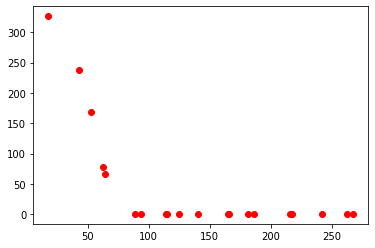

highHIIIIGHHHHHH:  73.0
rewaRD::  -83.10076867590467
returned state: [267.]
observation space:  (21,)
stepping:  28
ACTION            :  3
curtemp:  282.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267. 282.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 330.61728924269835
chisqds:  20.155674181037583
BUT ARE WE SURE?: 2340821234071.12


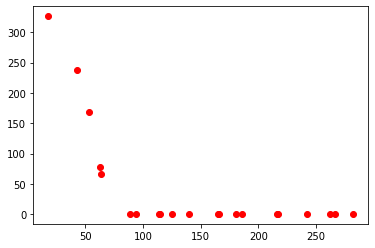

highHIIIIGHHHHHH:  58.0
rewaRD::  -80.15447181735458
returned state: [282.]
observation space:  (22,)
stepping:  28
ACTION            :  0
curtemp:  283.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267. 282. 283.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 370.64409316236845
chisqds:  18.64215632521227
BUT ARE WE SURE?: 4.350225800220557e-09


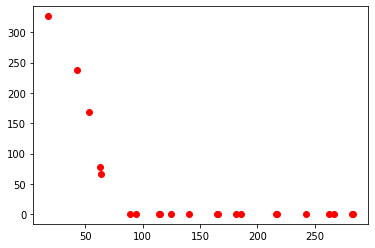

highHIIIIGHHHHHH:  57.0
rewaRD::  -78.54325470605421
returned state: [283.]
observation space:  (23,)
stepping:  28
ACTION            :  4
curtemp:  303.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267. 282. 283. 303.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 123.4462572228887
chisqds:  29.564294724372285
BUT ARE WE SURE?: 3.276528905875244e-10


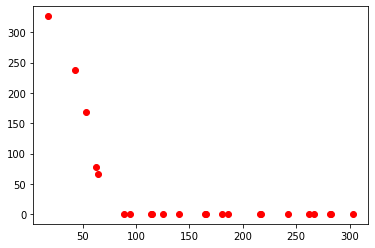

highHIIIIGHHHHHH:  37.0
rewaRD::  -86.47016599823547
returned state: [303.]
observation space:  (24,)
stepping:  28
ACTION            :  5
curtemp:  328.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267. 282. 283. 303. 328.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 367.96683218172
chisqds:  16.877003392884113
BUT ARE WE SURE?: 11534343.143131666


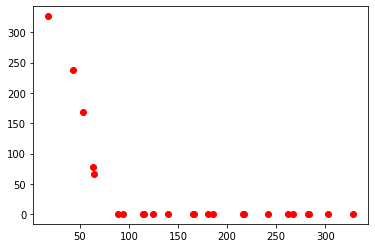

highHIIIIGHHHHHH:  12.0
rewaRD::  -76.2991100559562
returned state: [328.]
observation space:  (25,)
stepping:  28
ACTION            :  4
curtemp:  348.0
Temperature:  [ 18.  43.  53.  63.  64.  89.  94. 114. 115. 125. 140. 165. 166. 181.
 186. 216. 217. 242. 262. 267. 282. 283. 303. 328. 348.]
Intensity:  [3.26527882e+02 2.38565448e+02 1.68243445e+02 7.70028369e+01
 6.66994714e+01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 50.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 463.64762058863136
chisqds:  17.211814877796716
BUT ARE WE SURE?: 1.0134641622788011e-08


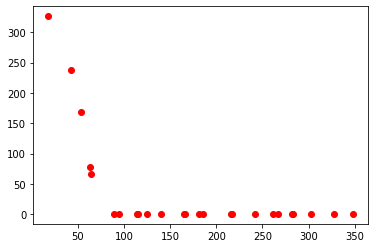

highHIIIIGHHHHHH:  -8.0
rewaRD::  -76.76014976689059
terminated: over max temp
returned state: [348.]
observation space:  (26,)
reset
fixed Tn:  90
fixed Jt:  1.1
fixed Nf:  330
stepping:  29
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
stepping:  29
ACTION            :  6
curtemp:  63.0
Temperature:  [33. 63.]
highHIIIIGHHHHHH:  277.0
rewaRD::  -100
returned state: [63.]
observation space:  (3,)
stepping:  29
ACTION            :  0
curtemp:  64.0
Temperature:  [33. 63. 64.]
highHIIIIGHHHHHH:  276.0
rewaRD::  -100
returned state: [64.]
observation space:  (4,)
stepping:  29
ACTION            :  6
curtemp:  94.0
Temperature:  [33. 63. 64. 94.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 334.1031298365476
chisqds:  130.4536544396889
BUT ARE WE SURE?: 2.746287567092695e-09

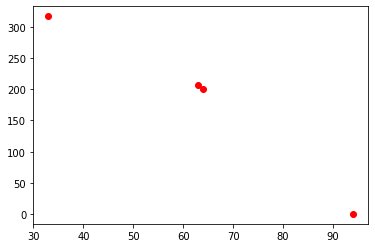

highHIIIIGHHHHHH:  246.0
rewaRD::  -96.933776966862
returned state: [94.]
observation space:  (5,)
stepping:  29
ACTION            :  2
curtemp:  104.0
Temperature:  [ 33.  63.  64.  94. 104.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 353.69533570436533
chisqds:  59.962858949160136
BUT ARE WE SURE?: 2.8898671483731363e-09


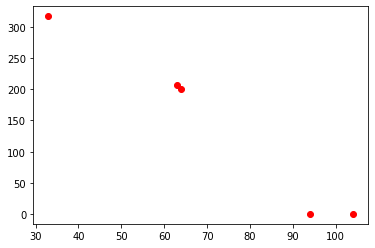

highHIIIIGHHHHHH:  236.0
rewaRD::  -93.32920399377318
returned state: [104.]
observation space:  (6,)
stepping:  29
ACTION            :  0
curtemp:  105.0
Temperature:  [ 33.  63.  64.  94. 104. 105.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 241.2985778011022
chisqds:  72.24570181033545
BUT ARE WE SURE?: 6.903423895606269e-09


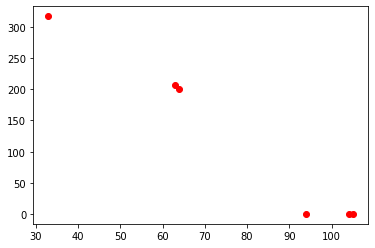

highHIIIIGHHHHHH:  235.0
rewaRD::  -94.46333844122508
returned state: [105.]
observation space:  (7,)
stepping:  29
ACTION            :  6
curtemp:  135.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 336.40741828435466
chisqds:  32.26909195630827
BUT ARE WE SURE?: 2.9400258027348347e-10


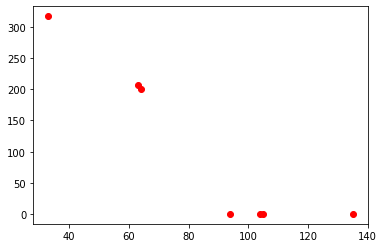

highHIIIIGHHHHHH:  205.0
rewaRD::  -87.60423749941299
returned state: [135.]
observation space:  (8,)
stepping:  29
ACTION            :  4
curtemp:  155.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 365.8300139572318
chisqds:  22.94982733549346
BUT ARE WE SURE?: 3.644628212059433e-10


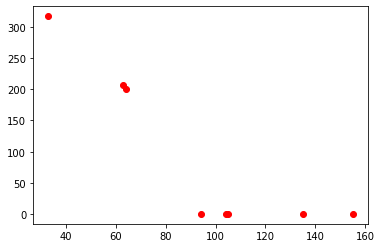

highHIIIIGHHHHHH:  185.0
rewaRD::  -82.57067497055314
returned state: [155.]
observation space:  (9,)
stepping:  29
ACTION            :  1
curtemp:  160.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 348.8030798618831
chisqds:  20.38392127053066
BUT ARE WE SURE?: 4.429316745434329e-09


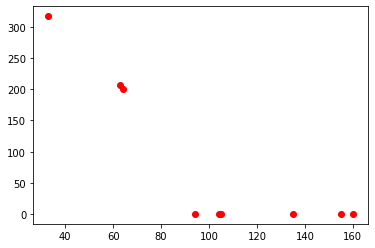

highHIIIIGHHHHHH:  180.0
rewaRD::  -80.37669029960952
returned state: [160.]
observation space:  (10,)
stepping:  29
ACTION            :  3
curtemp:  175.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 412.7953199100733
chisqds:  14.914838794742987
BUT ARE WE SURE?: 1.0854379913848394e-09


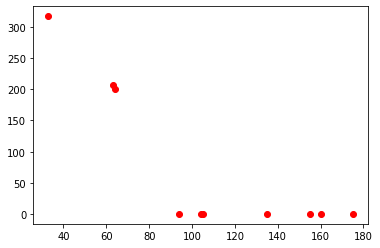

highHIIIIGHHHHHH:  165.0
rewaRD::  -73.18107117986503
returned state: [175.]
observation space:  (11,)
stepping:  29
ACTION            :  0
curtemp:  176.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 335.87775090384173
chisqds:  16.1737089603486
BUT ARE WE SURE?: 21112044403.390633


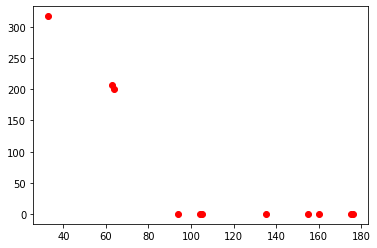

highHIIIIGHHHHHH:  164.0
rewaRD::  -75.2685051412364
returned state: [176.]
observation space:  (12,)
stepping:  29
ACTION            :  0
curtemp:  177.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 345.93462896973614
chisqds:  13.752823421986527
BUT ARE WE SURE?: 5.979429479902999e-09


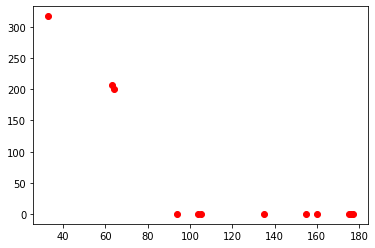

highHIIIIGHHHHHH:  163.0
rewaRD::  -70.91506320363837
returned state: [177.]
observation space:  (13,)
stepping:  29
ACTION            :  1
curtemp:  182.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 466.05023730542473
chisqds:  11.130552101497909
BUT ARE WE SURE?: 2.870805771179939e-09


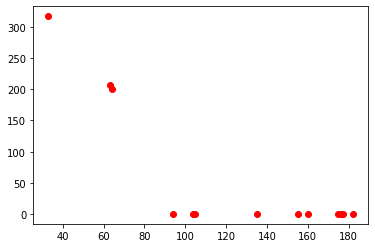

highHIIIIGHHHHHH:  158.0
rewaRD::  -64.06287879051665
returned state: [182.]
observation space:  (14,)
stepping:  29
ACTION            :  4
curtemp:  202.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 331.1001564765533
chisqds:  12.027653409051602
BUT ARE WE SURE?: 6.117433147456595e-09


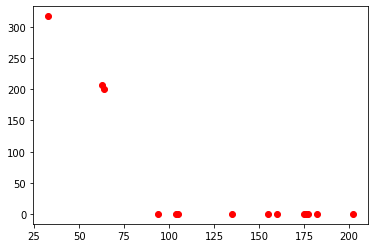

highHIIIIGHHHHHH:  138.0
rewaRD::  -66.74330508235516
returned state: [202.]
observation space:  (15,)
stepping:  29
ACTION            :  2
curtemp:  212.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 337.31171348510213
chisqds:  10.712166212346895
BUT ARE WE SURE?: 7.01552337135358e-09


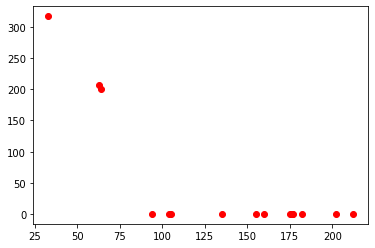

highHIIIIGHHHHHH:  128.0
rewaRD::  -62.65927991866314
returned state: [212.]
observation space:  (16,)
stepping:  29
ACTION            :  4
curtemp:  232.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.97909808014475
chisqds:  10.231627793831565
BUT ARE WE SURE?: 7.48551441655188e-09


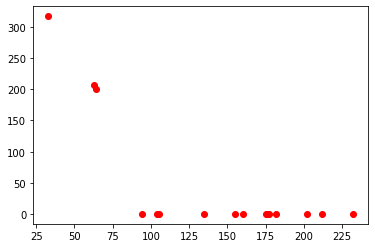

highHIIIIGHHHHHH:  108.0
rewaRD::  -60.905536434666665
returned state: [232.]
observation space:  (17,)
stepping:  29
ACTION            :  5
curtemp:  257.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 330.0673445103042
chisqds:  9.496799445338457
BUT ARE WE SURE?: 7.784295747057958e-09


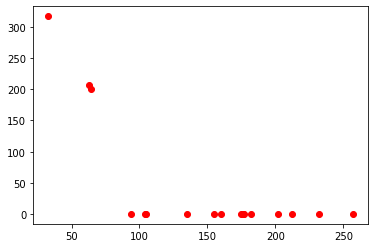

highHIIIIGHHHHHH:  83.0
rewaRD::  -57.88054677764711
returned state: [257.]
observation space:  (18,)
stepping:  29
ACTION            :  0
curtemp:  258.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 338.5283350526741
chisqds:  8.52276323321325
BUT ARE WE SURE?: 8.235218377938644e-09


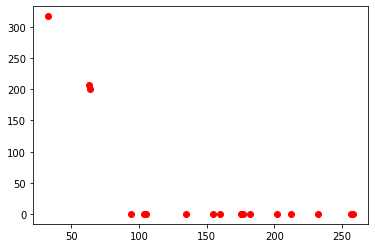

highHIIIIGHHHHHH:  82.0
rewaRD::  -53.066864694633544
returned state: [258.]
observation space:  (19,)
stepping:  29
ACTION            :  5
curtemp:  283.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 344.75467542897735
chisqds:  7.774847166100722
BUT ARE WE SURE?: 7.89277295961917e-09


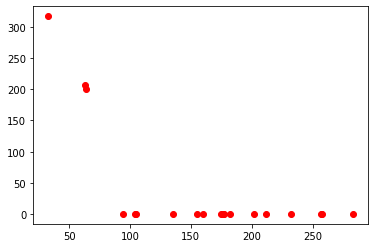

highHIIIIGHHHHHH:  57.0
rewaRD::  -48.55204334510284
returned state: [283.]
observation space:  (20,)
stepping:  29
ACTION            :  0
curtemp:  284.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 345.08090550865376
chisqds:  7.307327874700212
BUT ARE WE SURE?: 8.33709518556544e-09


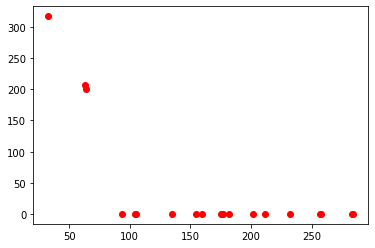

highHIIIIGHHHHHH:  56.0
rewaRD::  -45.260428044442946
returned state: [284.]
observation space:  (21,)
stepping:  29
ACTION            :  2
curtemp:  294.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 345.74980562610335
chisqds:  6.881789939851092
BUT ARE WE SURE?: nan


/usr/local/lib/python3.6/dist-packages/bumps/lsqerror.py:299: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(C))


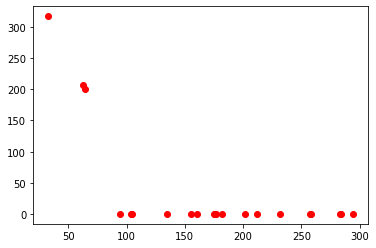

highHIIIIGHHHHHH:  46.0
rewaRD::  -41.8755870934568
returned state: [294.]
observation space:  (22,)
stepping:  29
ACTION            :  0
curtemp:  295.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294. 295.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 344.8812197322636
chisqds:  6.543703546199645
BUT ARE WE SURE?: 8.964123502292207e-09


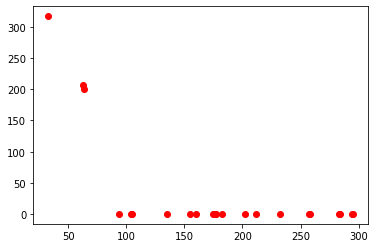

highHIIIIGHHHHHH:  45.0
rewaRD::  -38.872536450355234
returned state: [295.]
observation space:  (23,)
stepping:  29
ACTION            :  2
curtemp:  305.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294. 295. 305.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 343.3158005549367
chisqds:  6.258468623811207
BUT ARE WE SURE?: 9.833751744651184e-09


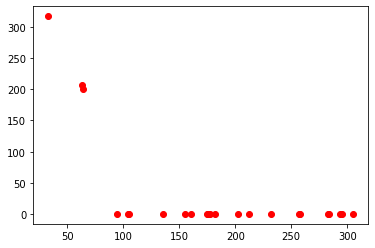

highHIIIIGHHHHHH:  35.0
rewaRD::  -36.08660136472606
returned state: [305.]
observation space:  (24,)
stepping:  29
ACTION            :  0
curtemp:  306.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294. 295. 305. 306.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 346.55958644794435
chisqds:  5.878563463906445
BUT ARE WE SURE?: 1.0163947131970528e-08


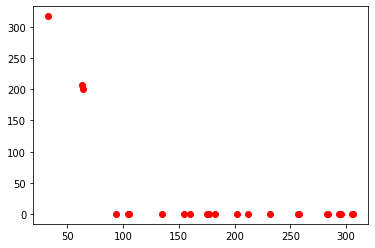

highHIIIIGHHHHHH:  34.0
rewaRD::  -31.956165404023622
returned state: [306.]
observation space:  (25,)
stepping:  29
ACTION            :  6
curtemp:  336.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294. 295. 305. 306. 336.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 339.278308731572
chisqds:  5.791467605614636
BUT ARE WE SURE?: 1.1033136232688068e-08


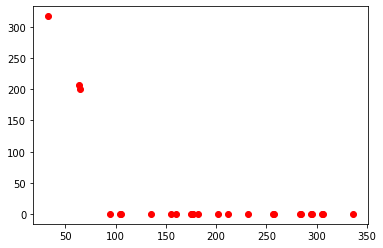

highHIIIIGHHHHHH:  4.0
rewaRD::  -30.932877944061488
returned state: [336.]
observation space:  (26,)
stepping:  29
ACTION            :  4
curtemp:  356.0
Temperature:  [ 33.  63.  64.  94. 104. 105. 135. 155. 160. 175. 176. 177. 182. 202.
 212. 232. 257. 258. 283. 284. 294. 295. 305. 306. 336. 356.]
Intensity:  [3.16947064e+02 2.06581953e+02 2.00791577e+02 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
ORDER PARAM RESULT (X2): 70.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 346.8811282687148
chisqds:  5.360147159255393
BUT ARE WE SURE?: 1.1042954066679261e-08


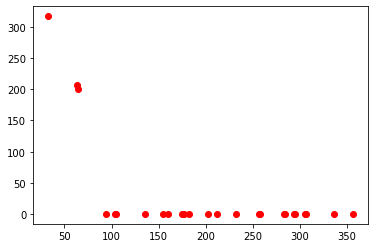

highHIIIIGHHHHHH:  -16.0
rewaRD::  -25.37518315904481
terminated: over max temp
returned state: [356.]
observation space:  (27,)
reset
fixed Tn:  280
fixed Jt:  0.8
fixed Nf:  330
stepping:  30
ACTION            :  4
curtemp:  23.0
Temperature:  [23.]
highHIIIIGHHHHHH:  317.0
rewaRD::  -100
returned state: [23.]
observation space:  (2,)
stepping:  30
ACTION            :  6
curtemp:  53.0
Temperature:  [23. 53.]
highHIIIIGHHHHHH:  287.0
rewaRD::  -100
returned state: [53.]
observation space:  (3,)
stepping:  30
ACTION            :  0
curtemp:  54.0
Temperature:  [23. 53. 54.]
highHIIIIGHHHHHH:  286.0
rewaRD::  -100
returned state: [54.]
observation space:  (4,)
stepping:  30
ACTION            :  0
curtemp:  55.0
Temperature:  [23. 53. 54. 55.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 299.5070581634105
chisqds:  11.210450977001477
BUT ARE WE SURE?: 4.1223339074509807e-10


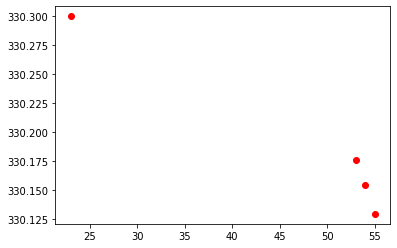

highHIIIIGHHHHHH:  285.0
rewaRD::  -64.31900903713775
returned state: [55.]
observation space:  (5,)
stepping:  30
ACTION            :  1
curtemp:  60.0
Temperature:  [23. 53. 54. 55. 60.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849 329.95290461]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 2.0
THE NF RESULT {X1}: 289.3682356004166
chisqds:  13.825920909018288
BUT ARE WE SURE?: 129.62564569176453


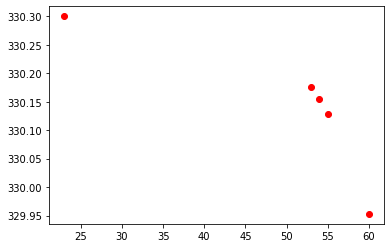

highHIIIIGHHHHHH:  280.0
rewaRD::  -71.06883493459807
returned state: [60.]
observation space:  (6,)
stepping:  30
ACTION            :  3
curtemp:  75.0
Temperature:  [23. 53. 54. 55. 60. 75.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849 329.95290461
 328.63553867]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.5694353196155869
THE NF RESULT {X1}: 267.63933973274885
chisqds:  23.49300606103822
BUT ARE WE SURE?: 217.89438150240474


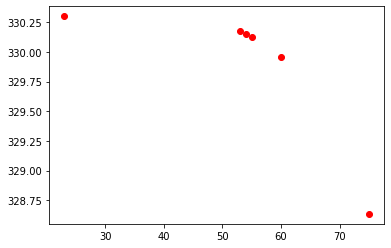

highHIIIIGHHHHHH:  265.0
rewaRD::  -82.97365611872988
returned state: [75.]
observation space:  (7,)
stepping:  30
ACTION            :  2
curtemp:  85.0
Temperature:  [23. 53. 54. 55. 60. 75. 85.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849 329.95290461
 328.63553867 326.78992564]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 303.1470618722209
chisqds:  3.726714851326997
BUT ARE WE SURE?: 83.17542819733626


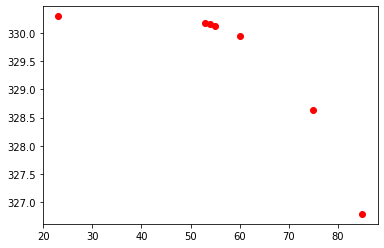

highHIIIIGHHHHHH:  255.0
rewaRD::  7.3331381545248036
returned state: [85.]
observation space:  (8,)
stepping:  30
ACTION            :  5
curtemp:  110.0
Temperature:  [ 23.  53.  54.  55.  60.  75.  85. 110.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849 329.95290461
 328.63553867 326.78992564 317.37197524]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000013
THE NF RESULT {X1}: 358.85086344886156
chisqds:  4.169227135637487
BUT ARE WE SURE?: 1.3883369457136372e-09


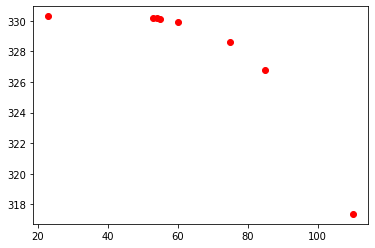

highHIIIIGHHHHHH:  230.0
rewaRD::  -4.058956975286307
returned state: [110.]
observation space:  (9,)
stepping:  30
ACTION            :  5
curtemp:  135.0
Temperature:  [ 23.  53.  54.  55.  60.  75.  85. 110. 135.]
Intensity:  [330.29999873 330.17605781 330.15406839 330.12918849 329.95290461
 328.63553867 326.78992564 317.37197524 299.60638185]
ORDER PARAM RESULT (X2): 260.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 329.0807472953455
chisqds:  0.0024365009331853912
BUT ARE WE SURE?: 4.439936908127497e-09


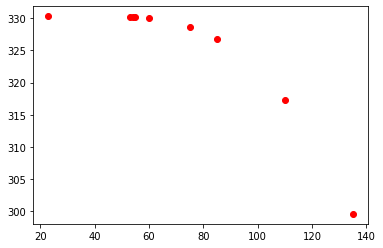

highHIIIIGHHHHHH:  205.0
rewaRD::  300
terminated: excellent conditions
returned state: [135.]
observation space:  (10,)
reset
fixed Tn:  190
fixed Jt:  1.1
fixed Nf:  330
stepping:  31
ACTION            :  6
curtemp:  33.0
Temperature:  [33.]
highHIIIIGHHHHHH:  307.0
rewaRD::  -100
returned state: [33.]
observation space:  (2,)
stepping:  31
ACTION            :  5
curtemp:  58.0
Temperature:  [33. 58.]
highHIIIIGHHHHHH:  282.0
rewaRD::  -100
returned state: [58.]
observation space:  (3,)
stepping:  31
ACTION            :  2
curtemp:  68.0
Temperature:  [33. 58. 68.]
highHIIIIGHHHHHH:  272.0
rewaRD::  -100
returned state: [68.]
observation space:  (4,)
stepping:  31
ACTION            :  0
curtemp:  69.0
Temperature:  [33. 58. 68. 69.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 331.2064040684482
chisqds:  0.22152336947278028
BUT ARE WE SURE?: 20.357214886600104


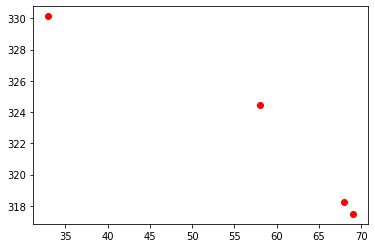

highHIIIIGHHHHHH:  271.0
rewaRD::  300
returned state: [69.]
observation space:  (5,)
stepping:  31
ACTION            :  6
curtemp:  99.0
Temperature:  [33. 58. 68. 69. 99.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114 280.84631155]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 353.5096368967986
chisqds:  4.94610356704735
BUT ARE WE SURE?: 2.8910042974637796e-09


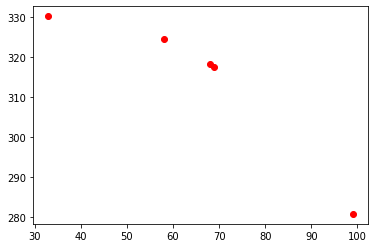

highHIIIIGHHHHHH:  241.0
rewaRD::  -19.12826034114245
returned state: [99.]
observation space:  (6,)
stepping:  31
ACTION            :  5
curtemp:  124.0
Temperature:  [ 33.  58.  68.  69.  99. 124.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114 280.84631155
 229.70567515]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 349.9892130493726
chisqds:  2.4737467907462696
BUT ARE WE SURE?: 3.1493868533443204e-09


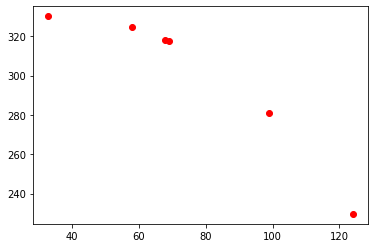

highHIIIIGHHHHHH:  216.0
rewaRD::  61.69803696009231
returned state: [124.]
observation space:  (7,)
stepping:  31
ACTION            :  3
curtemp:  139.0
Temperature:  [ 33.  58.  68.  69.  99. 124. 139.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114 280.84631155
 229.70567515 189.7587011 ]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.545891933544703
THE NF RESULT {X1}: 331.79234147768216
chisqds:  2.1355782123556564
BUT ARE WE SURE?: 1.0727663395580858


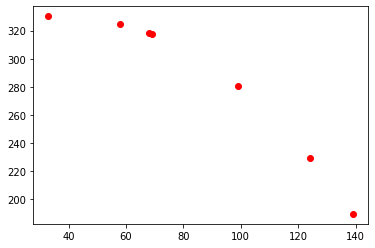

highHIIIIGHHHHHH:  201.0
rewaRD::  87.3029035816856
returned state: [139.]
observation space:  (8,)
stepping:  31
ACTION            :  4
curtemp:  159.0
Temperature:  [ 33.  58.  68.  69.  99. 124. 139. 159.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114 280.84631155
 229.70567515 189.7587011  125.44828223]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 308.84034029898845
chisqds:  10.73438704008746
BUT ARE WE SURE?: 4.0658726024369654e-10


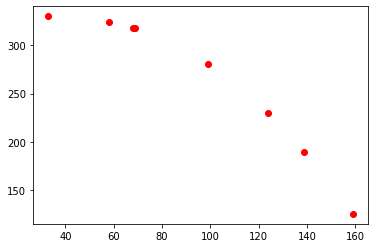

highHIIIIGHHHHHH:  181.0
rewaRD::  -62.73657745838639
returned state: [159.]
observation space:  (9,)
stepping:  31
ACTION            :  6
curtemp:  189.0
Temperature:  [ 33.  58.  68.  69.  99. 124. 139. 159. 189.]
Intensity:  [330.13894751 324.46521179 318.24896137 317.47717114 280.84631155
 229.70567515 189.7587011  125.44828223   4.82655315]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.4
THE NF RESULT {X1}: 274.3161377355631
chisqds:  19.67373342630908
BUT ARE WE SURE?: 0.5855102313868215


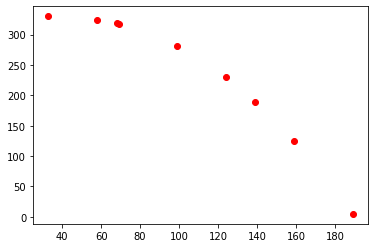

highHIIIIGHHHHHH:  151.0
rewaRD::  -79.66832266492479
returned state: [189.]
observation space:  (10,)
stepping:  31
ACTION            :  0
curtemp:  190.0
Temperature:  [ 33.  58.  68.  69.  99. 124. 139. 159. 189. 190.]
Intensity:  [3.30138948e+02 3.24465212e+02 3.18248961e+02 3.17477171e+02
 2.80846312e+02 2.29705675e+02 1.89758701e+02 1.25448282e+02
 4.82655315e+00 3.00000000e-01]
ORDER PARAM RESULT (X2): 170.0
THE JT RESULT {X0}: 0.40000000000000036
THE NF RESULT {X1}: 291.93891581819446
chisqds:  11.715514181794518
BUT ARE WE SURE?: 2.0182130564726614e-08


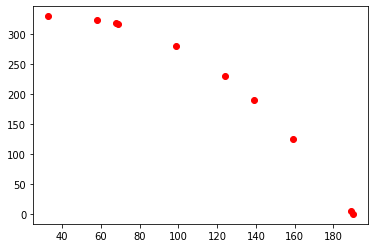

highHIIIIGHHHHHH:  150.0
rewaRD::  -65.8572390598455
returned state: [190.]
observation space:  (11,)
stepping:  31
ACTION            :  3
curtemp:  205.0
Temperature:  [ 33.  58.  68.  69.  99. 124. 139. 159. 189. 190. 205.]
Intensity:  [3.30138948e+02 3.24465212e+02 3.18248961e+02 3.17477171e+02
 2.80846312e+02 2.29705675e+02 1.89758701e+02 1.25448282e+02
 4.82655315e+00 3.00000000e-01 3.00000000e-01]


KeyboardInterrupt: ignored

In [ ]:
model = PPO2('MlpPolicy', env, verbose=1).learn(8000)

In [ ]:
model.save("models/like5_randtn_newfix")

NameError: ignored

Restart the training from a saved model.

In [ ]:
model = PPO2.load("models/unk_rand_params", env)  #if needed, instatiate env above
model = model.learn(500)

Test the trained agent.

In [ ]:
from stable_baselines import PPO2, A2C
from stable_baselines.common.cmd_util import make_vec_env

data = [[] for i in range(5)]

model = PPO2.load("models/1108_multi_params") #if you're 'playing' a saved model
for tns in np.arange(120,200, 10): #these need to be reduced.
  for jts in np.arange(.7, 1.5, .1):
    for nfs in np.arange(230, 380, 20):
      for bks in np.arange(.1, 8, .7):
        env = OrderEnv() 
        env.setTn(tns)
        env.setJt(jts)
        env.setNf(nfs)
        # wrap it
        vec_env = make_vec_env(lambda: env, n_envs=1) 
        finalTn = 0
        finalJt = 0
        finalNf = 0
        finalBk = 0

        obs = vec_env.reset()
        n_steps = 20
        for step in range(n_steps):
          action, _ = model.predict(obs, deterministic=True)
          print("Step {}".format(step + 1))
          print("Action: ", action)
          obs, reward, done, info = vec_env.step(action)
          print('obs=', obs, 'reward=', reward, 'done=', done)
          if done:
            finalTn, finalJt, finalNf, finalBk = env.getVars()
            print("Goal reached!", "reward=", reward)
            break

        if abs(finalTn - tns) < 0.1 and abs(finalJt - jts) < 0.1 and abs(finalNf - nfs) < 0.1 and abs(finalBk - bks):
          #print("Success for tn: ", tns)
          success = 1
        else:
          #print("Fail for tn:", tns)
          success = 0
        data[0].append(tns)
        data[1].append(jts)
        data[2].append(nfs)
        data[3].append(bks)
        data[4].append(success)

print(data)
#np.savetxt('logs/successdata.npy', data)

In [ ]:
np.savetxt('logs/successdata_1108multi.npy', data)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
print(np.array(data[0]))

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(data[0], data[1], data[2], c = data[3])
plt.show()

Graph the results of the training time.

In [ ]:
numTrials = 399

endParams = [[] for i in range(numTrials)]
data = [[] for i in range(numTrials)]
chis = [[] for i in range(numTrials)]
nfs = [[] for i in range(numTrials)]
jts = [[] for i in range(numTrials)]
bks = [[] for i in range(numTrials)]
endtns = []
endnfs = []
endjts = []
endbks = []
tn = 160
nf = 216
jt = .2
convergs_tn = []
convergs_nf = []
convergs_jt = []
convergs_bk = []
imagestore = "logs/"
logstore = "logs/"

for i in range(1,numTrials+1):
  data[i-1] = np.loadtxt(logstore +  "temps/tnLog-" + str(i) + ".npy")
  chis[i-1] = np.loadtxt(logstore + "chis/chiLog-" + str(i) + ".npy")
  nfs[i-1] = np.loadtxt(logstore + "nf/nfLog-" + str(i) + ".npy")
  jts[i-1] = np.loadtxt(logstore + "jt/jtLog-" + str(i) + ".npy")
  bks[i-1] = np.loadtxt(logstore + "bk/bkLog-" + str(i) + ".npy")

#plot each episode tn track, process ending values for plotting below
for i in range (0, len(data)): 
  try:
    value = data[i][-1]
  except:
    value = data[i]
  try:
    nf = nfs[i][-1]
  except:
    nf = nfs[i]
  try:
    jt = jts[i][-1]
  except:
    jt = jts[i]
  try:
    bk = bks[i][-1]
  except:
    bk = bks[i]

  #print(value)
  endtns.append(value)
  endnfs.append(nf)
  endjts.append(jt)
  endbks.append(bk)
  #print(endtns)

plt.xlabel("measurement steps")
plt.ylabel("tn value")
plt.show()
#plt.savefig(imagestore + "tns.png")
plt.close()

convergs_tn = np.loadtxt("logs/convergsTn.npy")
convergs_nf = np.loadtxt("logs/convergsNf.npy")
convergs_jt = np.loadtxt("logs/convergsJt.npy")
convergs_bk = np.loadtxt("logs/convergsBk.npy")

print("convergence for tn")
plt.plot(convergs_tn, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_tn.png')

print("convergence for nf")
plt.plot(convergs_nf, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_nf.png')

print("convergence for jt")
plt.plot(convergs_jt, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()
#plt.savefig(imagestore + 'convergs_jt.png')

print("convergence for bk")
plt.plot(convergs_bk, 'ro')
plt.xlabel("episodes")
plt.ylabel("step at which convergence is reached")
plt.show()

#actually plot final tn values for each episode
plt.plot(endtns, 'bo')
plt.xlabel("episodes")
plt.ylabel("tn value")
plt.show()
#plt.savefig(imagestore + "endtns.png")
plt.close()

print("final nfs")
plt.plot(endnfs, 'go')
plt.xlabel("episodes")
plt.ylabel("nf value")
plt.show()
#plt.savefig(imagestore + "endnfs.png")
plt.close()

print("final jts")
plt.plot(endjts, 'mo')
plt.xlabel("episodes")
plt.ylabel("jt value")
plt.show()
#plt.savefig(imagestore + "endjts.png")
plt.close()

#track chisq values through the episode
for i in range (0, len(chis)):
  plt.plot(chis[i], label = str(i))

plt.xlabel("steps")
plt.ylabel("chis")
plt.show()
plt.close()

print("rewards at the end of the episode")
rewards = np.loadtxt('logs/runrewards.npy')
plt.plot(rewards, 'ro')
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()
plt.close()


KeyboardInterrupt: ignored

Test how a classical fitter works.

In [ ]:
p=[1.0,330,.3]
T=np.arange(3, 300, 8)
#T = np.array([28, 33, 58, 88, 108, 118, 138, 168, 183, 198, 218, 243, 273, 303])
print("temperature: ", T)
#T=N.arange(10,300,2)
I=[]
error = []

I=OrderMethods.orderparameter(T, 220,p[0],p[1],p[2])
print("Intensity: ", I)
error= np.sqrt(I)
#print(error)

M = Curve(OrderMethods.orderparameter, T, I, error, Tn = 190, Jt = 1.0, Nf = 320, Bk = p[2])
M.Tn.range(200, 240)
M.Nf.range(100,500)

x, dx, chisq, params = OrderMethods.fit(M)
print(x[0])
print(x[1])
#print(x[2])

#fitI = OrderMethods.orderparameter(T, x, p[0],p[1],p[2])

# plt.errorbar(T, I, error)
# plt.plot(T, fitI,'ro', markersize = 2)
# plt.xlabel("Temperature")
# plt.ylabel("Intensity") 
# plt.show()
# plt.close()

temperature:  [  3  11  19  27  35  43  51  59  67  75  83  91  99 107 115 123 131 139
 147 155 163 171 179 187 195 203 211 219 227 235 243 251 259 267 275 283
 291 299]
Intensity:  [3.30300000e+02 3.30300000e+02 3.30299981e+02 3.30296753e+02
 3.30246898e+02 3.29992219e+02 3.29266902e+02 3.27785109e+02
 3.25307905e+02 3.21661797e+02 3.16729931e+02 3.10435997e+02
 3.02729862e+02 2.93577268e+02 2.82953179e+02 2.70837854e+02
 2.57214579e+02 2.42068501e+02 2.25385994e+02 2.07154503e+02
 1.87362201e+02 1.65998134e+02 1.43052105e+02 1.18514688e+02
 9.23771928e+01 6.46315671e+01 3.52705036e+01 4.28727300e+00
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01 3.00000000e-01 3.00000000e-01
 3.00000000e-01 3.00000000e-01]
330.0000000000002
219.9999999999865
